### K-Sil variants

#### silhouette

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from joblib import Parallel, delayed

class KSil:
    def __init__(self,
                 n_clusters=3,
                 init='random',
                 max_iter=100,
                 random_state=0,
                 learning_rate=0.2,
                 tol=1e-4,
                 n_init=1, n_jobs=1):

        # Parameters
        self.n_clusters = int(n_clusters)     # Number of clusters
        self.init = init                      # Initialization method
        self.max_iter = int(max_iter)         # Maximum number of iterations
        self.random_state = int(random_state) # Random seed
        self.learning_rate = learning_rate    # Learning rate for temperature
        self.tol = float(tol)                 # Centroid convergence tolerance

        # For multiple initializations:
        self.n_init = n_init                  # Number of initializations
        self.n_jobs = n_jobs                  # Number of cores

        # n_clusters check
        if self.n_clusters < 2:
           raise ValueError(f"n_clusters ({self.n_clusters}) must be > 1.")
        # init check
        if isinstance(self.init, str) and self.init not in ('random', 'k-means++'):
           raise ValueError(f"init ({self.init}) must be 'random' or 'k-means++'.")
        # n_init check
        if self.n_init < 1:
           raise ValueError(f"n_init ({self.n_init}) must be > 0.")

        # Attributes
        self.labels_ = None          # Cluster labels (converged partition)
        self.cluster_centers_ = None # Cluster centers (converged partition)
        self.n_iter_ = None          # Number of iterations (until convergence)
        self.sil_ = None             # silhouette (centroid-approximated) at converged partition

        # history attributes
        self.centers_history_ = None # Centroids across iterations
        self.labels_history_ = None  # Assignments across iterations
        self.sil_history_ = None     # Silhouette proxy across iterations
        self.weights_history_ = None # Weights across iterations

    def _initialization(self, X, n_clusters):
        X = np.asarray(X)
        if X.shape[0] < n_clusters:
           raise ValueError(f"n_clusters ({n_clusters}) can not exceed n_samples ({X.shape[0]}).")

        kmeans = KMeans(n_clusters=n_clusters,
                        init=self.init,
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        # Retry if some clusters are empty in the initial assignment
        if np.unique(labels).size < n_clusters:
           max_retries = 10 # 10 retries at max
           base_seed = self.random_state
           for attempt in range(1, max_retries + 1):
               seed = base_seed + attempt
               km = KMeans(n_clusters=n_clusters,
                           init=self.init,
                           random_state=seed,
                           n_init=1,
                           max_iter=1).fit(X)
               centers = km.cluster_centers_
               labels = km.labels_
               if np.unique(labels).size == n_clusters:
                  break
           else:
               raise ValueError(
                     f"KMeans (1-iter) initialization produced empty clusters after {max_retries} retries. "
                     f"Try a different random_state, or init='k-means++'.")
        return centers, labels

    def _fit_once(self, X, n_clusters, previous_centers, w):
        X = np.asarray(X)
        w = np.asarray(w)
        km = KMeans(
             n_clusters=n_clusters,
             init=previous_centers,
             n_init=1,
             max_iter=1,
             random_state=self.random_state)
        km.fit(X, sample_weight=w)

        centers = km.cluster_centers_
        labels = km.labels_
        return centers, labels

    @staticmethod
    def sil_scores(X, labels, centers):
        X = np.asarray(X, dtype=float)
        labels = np.asarray(labels, dtype=int)
        centers = np.asarray(centers, dtype=float)

        if len(X) == 0:
           raise ValueError("X is empty. Cannot compute silhouette scores.")

        n = X.shape[0]

        # Squared distances to all centroids
        D = euclidean_distances(X, centers, squared=True)

        # Distance to own centroid (a: intra cluster distance proxy)
        D_diag = D[np.arange(n), labels]  # a^2
        a_vals = np.sqrt(D_diag)  # a

        # Nearest other centroid distance (b: inter cluster distance)
        D_others = D.copy()
        D_others[np.arange(n), labels] = np.inf
        b_sq = D_others.min(axis=1)  # b^2
        b_vals = np.sqrt(b_sq)  # b

        # Silhouette surrogate (b-a)/[max{a,b}+epsilon]
        max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-12)
        s_vals = (b_vals - a_vals) / max_ab

        return s_vals, a_vals, b_vals

    @staticmethod
    def micro_sil(s_vals):
        s_vals = np.asarray(s_vals, dtype=float)
        if s_vals.size == 0:
           return 0.0
        return float(s_vals.mean())

    @staticmethod
    def macro_sil(s_vals, labels):
        s_vals = np.asarray(s_vals, dtype=float)
        labels = np.asarray(labels, dtype=int)

        if s_vals.size == 0 or labels.size == 0:
           return 0.0

        uniq, inv = np.unique(labels, return_inverse=True)
        if uniq.size == 0:
           return 0.0
        sum_per_cluster = np.bincount(inv, weights=s_vals)
        cnt_per_cluster = np.bincount(inv)

        valid = cnt_per_cluster > 0
        if not np.any(valid):
           return 0.0
        cluster_means = sum_per_cluster[valid] / cnt_per_cluster[valid]
        return float(cluster_means.mean())

    def _weights(self, s_vals, temperature):
        s_vals = np.asarray(s_vals, dtype=float)
        weights = np.exp(s_vals * temperature)
        return weights

    def _KSil(self, X, n_clusters, max_iter):

        # Initialize centroids
        centers, labels = self._initialization(X, n_clusters)
        tau = 1.0 # initial temperature
        prev_score =  None

        centers_history = [centers.copy()]
        labels_history = [labels.copy()]
        sil_history = []
        weights_history = []

        n_iter = 0

        while n_iter < max_iter:

            n_iter += 1

            # Compute point-silhouette scores
            sil_vals, a_vals, b_vals = KSil.sil_scores(X, labels, centers)
            score = KSil.macro_sil(sil_vals, labels)

            micro_sil = KSil.micro_sil(sil_vals)
            sil_history.append(micro_sil)

            # Update temperature
            if prev_score is not None:
               r = (score - prev_score) / max(1 - prev_score, 1e-12)

               r = float(np.clip(r, -1.0, 1.0))

               # data-driven bounds to avoid softmax saturation
               counts = np.bincount(labels, minlength=n_clusters)
               m_max = int(max(counts.max(), 2))
               L     = float(np.sqrt(2.0 * np.log(m_max)))
               z_max = (m_max - 1) / m_max
               tau_min, tau_max = 1e-12, L / max(z_max, 1e-8)

               # multiplicative update (no logs needed)
               eta = self.learning_rate # default: 0.2 (small stable learning rate)

               # Update temperature based on the rate of change of the silhouette objective
               tau = float(np.clip(tau * np.exp(eta * r), tau_min, tau_max))

            # store for next iteration’s drift calc
            prev_score = score

            # Retain previous centroids for convergence checking
            previous_centers = centers.copy()

            # Compute weights based on silhouette scores
            weights = self._weights(sil_vals, tau)

            weights_history.append(weights.copy())

            # Update centroids and assignments
            centers, labels = self._fit_once(X, n_clusters, previous_centers, weights)

            centers_history.append(centers.copy())
            labels_history.append(labels.copy())

            avg_move = np.linalg.norm(centers - previous_centers, axis=1).mean()

            # Centroid stability
            if avg_move < self.tol:
               break

        return centers, labels, n_iter, sil_history, centers_history, labels_history, weights_history

    def fit(self, X):
        """
        Run KSil on X and store the converged partition.
        X: array-like, shape (n_samples, n_features)
        """
        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)

        if self.n_init == 1:
           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = self._KSil(X_arr, self.n_clusters, self.max_iter)
        else:
           base_seed = self.random_state
           seeds = [int(base_seed) + i for i in range(self.n_init)]

           # Helper: directly call _KSil with a seed
           def _run_one(seed):
               self.random_state = seed
               return self._KSil(X_arr, self.n_clusters, self.max_iter)

           if self.n_jobs in (None, 1):
              results = [_run_one(seed) for seed in seeds]
           else:
              results = Parallel(n_jobs=self.n_jobs)(delayed(_run_one)(seed) for seed in seeds)

           # Pick best run by final silhouette
           best_idx = None
           best_sil = -np.inf

           for i, res in enumerate(results):
               (_, _, _, sil_history_i,
               _, _, _) = res
               if sil_history_i:
                  final_sil_i = sil_history_i[-1]
               else:
                  final_sil_i = -np.inf
               if final_sil_i > best_sil:
                   best_sil = final_sil_i
                   best_idx = i

           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = results[best_idx]

           self.random_state = base_seed # restore base random_state

        self.cluster_centers_ = centers
        self.labels_ = labels
        self.n_iter_ = n_iter

        self.sil_history_ = sil_history
        self.sil_ = sil_history[-1] if sil_history else None
        self.centers_history_ = centers_history
        self.labels_history_ = labels_history
        self.weights_history_ = weights_history

        return self

    def predict(self, X):
        """
        Assign new points to the nearest learned centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        dist_matrix = euclidean_distances(X_arr, self.cluster_centers_, squared=True)
        labels = np.argmin(dist_matrix, axis=1)
        return labels.astype(int)

    def transform(self, X):
        """
        Return distances of each sample to each centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        distances = euclidean_distances(X_arr, self.cluster_centers_, squared=False)
        return distances

    def fit_predict(self, X):
        """
        Equivalent to: fit(X); return labels_.
        """
        self.fit(X)
        return self.labels_

    def fit_transform(self, X):
        """
        Equivalent to: fit(X); return transform(X).
        """
        self.fit(X)
        return self.transform(X)

#### Inversed a_vals

In [2]:
class a_valsKSil:
    def __init__(self,
                 n_clusters=3,
                 init='random',
                 max_iter=100,
                 random_state=0,
                 learning_rate=0.2,
                 tol=1e-4,
                 n_init=1, n_jobs=1):

        # Parameters
        self.n_clusters = int(n_clusters)     # Number of clusters
        self.init = init                      # Initialization method
        self.max_iter = int(max_iter)         # Maximum number of iterations
        self.random_state = int(random_state) # Random seed
        self.learning_rate = learning_rate    # Learning rate for temperature
        self.tol = float(tol)                 # Centroid convergence tolerance

        # For multiple initializations:
        self.n_init = n_init                  # Number of initializations
        self.n_jobs = n_jobs                  # Number of cores

        # n_clusters check
        if self.n_clusters < 2:
           raise ValueError(f"n_clusters ({self.n_clusters}) must be > 1.")
        # init check
        if isinstance(self.init, str) and self.init not in ('random', 'k-means++'):
           raise ValueError(f"init ({self.init}) must be 'random' or 'k-means++'.")
        # n_init check
        if self.n_init < 1:
           raise ValueError(f"n_init ({self.n_init}) must be > 0.")

        # Attributes
        self.labels_ = None          # Cluster labels (converged partition)
        self.cluster_centers_ = None # Cluster centers (converged partition)
        self.n_iter_ = None          # Number of iterations (until convergence)
        self.sil_ = None             # silhouette (centroid-approximated) at converged partition

        # history attributes
        self.centers_history_ = None # Centroids across iterations
        self.labels_history_ = None  # Assignments across iterations
        self.sil_history_ = None     # Silhouette proxy across iterations
        self.weights_history_ = None # Weights across iterations

    def _initialization(self, X, n_clusters):
        X = np.asarray(X)
        if X.shape[0] < n_clusters:
           raise ValueError(f"n_clusters ({n_clusters}) can not exceed n_samples ({X.shape[0]}).")

        kmeans = KMeans(n_clusters=n_clusters,
                        init=self.init,
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        # Retry if some clusters are empty in the initial assignment
        if np.unique(labels).size < n_clusters:
           max_retries = 10 # 10 retries at max
           base_seed = self.random_state
           for attempt in range(1, max_retries + 1):
               seed = base_seed + attempt
               km = KMeans(n_clusters=n_clusters,
                           init=self.init,
                           random_state=seed,
                           n_init=1,
                           max_iter=1).fit(X)
               centers = km.cluster_centers_
               labels = km.labels_
               if np.unique(labels).size == n_clusters:
                  break
           else:
               raise ValueError(
                     f"KMeans (1-iter) initialization produced empty clusters after {max_retries} retries. "
                     f"Try a different random_state, or init='k-means++'.")
        return centers, labels

    def _fit_once(self, X, n_clusters, previous_centers, w):
        X = np.asarray(X)
        w = np.asarray(w)
        km = KMeans(
             n_clusters=n_clusters,
             init=previous_centers,
             n_init=1,
             max_iter=1,
             random_state=self.random_state)
        km.fit(X, sample_weight=w)

        centers = km.cluster_centers_
        labels = km.labels_
        return centers, labels

    @staticmethod
    def sil_scores(X, labels, centers):
        X = np.asarray(X, dtype=float)
        labels = np.asarray(labels, dtype=int)
        centers = np.asarray(centers, dtype=float)

        if len(X) == 0:
           raise ValueError("X is empty. Cannot compute silhouette scores.")

        n = X.shape[0]

        # Squared distances to all centroids
        D = euclidean_distances(X, centers, squared=True)

        # Distance to own centroid (a: intra cluster distance proxy)
        D_diag = D[np.arange(n), labels]  # a^2
        a_vals = np.sqrt(D_diag)  # a

        # Nearest other centroid distance (b: inter cluster distance)
        D_others = D.copy()
        D_others[np.arange(n), labels] = np.inf
        b_sq = D_others.min(axis=1)  # b^2
        b_vals = np.sqrt(b_sq)  # b

        # Silhouette surrogate (b-a)/[max{a,b}+epsilon]
        max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-12)
        s_vals = (b_vals - a_vals) / max_ab

        return s_vals, a_vals, b_vals

    @staticmethod
    def micro_sil(s_vals):
        s_vals = np.asarray(s_vals, dtype=float)
        if s_vals.size == 0:
           return 0.0
        return float(s_vals.mean())

    @staticmethod
    def macro_sil(s_vals, labels):
        s_vals = np.asarray(s_vals, dtype=float)
        labels = np.asarray(labels, dtype=int)

        if s_vals.size == 0 or labels.size == 0:
           return 0.0

        uniq, inv = np.unique(labels, return_inverse=True)
        if uniq.size == 0:
           return 0.0
        sum_per_cluster = np.bincount(inv, weights=s_vals)
        cnt_per_cluster = np.bincount(inv)

        valid = cnt_per_cluster > 0
        if not np.any(valid):
           return 0.0
        cluster_means = sum_per_cluster[valid] / cnt_per_cluster[valid]
        return float(cluster_means.mean())

    def _weights(self, a_vals, temperature):
        a = np.asarray(a_vals, dtype=float)

        x = 1.0 / (a + 1e-8)                 # unbounded signal
        z = x * float(temperature)
        z = z - np.max(z)                    # exp-stability

        w = np.exp(z)

        w = w + 1e-12
        w = w / max(w.mean(), 1e-12)

        return w


    def _KSil(self, X, n_clusters, max_iter):

        # Initialize centroids
        centers, labels = self._initialization(X, n_clusters)
        tau = 1.0 # initial temperature
        prev_score =  None

        centers_history = [centers.copy()]
        labels_history = [labels.copy()]
        sil_history = []
        weights_history = []

        n_iter = 0

        while n_iter < max_iter:

            n_iter += 1

            # Compute point-silhouette scores
            sil_vals, a_vals, b_vals = KSil.sil_scores(X, labels, centers)
            score = KSil.macro_sil(sil_vals, labels)

            micro_sil = KSil.micro_sil(sil_vals)
            sil_history.append(micro_sil)

            # Update temperature
            if prev_score is not None:
               r = (score - prev_score) / max(1 - prev_score, 1e-12)

               r = float(np.clip(r, -1.0, 1.0))

               # data-driven bounds to avoid softmax saturation
               counts = np.bincount(labels, minlength=n_clusters)
               m_max = int(max(counts.max(), 2))
               L     = float(np.sqrt(2.0 * np.log(m_max)))
               z_max = (m_max - 1) / m_max
               tau_min, tau_max = 1e-12, L / max(z_max, 1e-8)

               # multiplicative update (no logs needed)
               eta = self.learning_rate # default: 0.2 (small stable learning rate)

               # Update temperature based on the rate of change of the silhouette objective
               tau = float(np.clip(tau * np.exp(eta * r), tau_min, tau_max))

            # store for next iteration’s drift calc
            prev_score = score

            # Retain previous centroids for convergence checking
            previous_centers = centers.copy()

            # Compute weights based on silhouette scores
            weights = self._weights(a_vals, tau)

            weights_history.append(weights.copy())

            # Update centroids and assignments
            centers, labels = self._fit_once(X, n_clusters, previous_centers, weights)

            centers_history.append(centers.copy())
            labels_history.append(labels.copy())

            avg_move = np.linalg.norm(centers - previous_centers, axis=1).mean()

            # Centroid stability
            if avg_move < self.tol:
               break

        return centers, labels, n_iter, sil_history, centers_history, labels_history, weights_history

    def fit(self, X):
        """
        Run KSil on X and store the converged partition.
        X: array-like, shape (n_samples, n_features)
        """
        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)

        if self.n_init == 1:
           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = self._KSil(X_arr, self.n_clusters, self.max_iter)
        else:
           base_seed = self.random_state
           seeds = [int(base_seed) + i for i in range(self.n_init)]

           # Helper: directly call _KSil with a seed
           def _run_one(seed):
               self.random_state = seed
               return self._KSil(X_arr, self.n_clusters, self.max_iter)

           if self.n_jobs in (None, 1):
              results = [_run_one(seed) for seed in seeds]
           else:
              results = Parallel(n_jobs=self.n_jobs)(delayed(_run_one)(seed) for seed in seeds)

           # Pick best run by final silhouette
           best_idx = None
           best_sil = -np.inf

           for i, res in enumerate(results):
               (_, _, _, sil_history_i,
               _, _, _) = res
               if sil_history_i:
                  final_sil_i = sil_history_i[-1]
               else:
                  final_sil_i = -np.inf
               if final_sil_i > best_sil:
                   best_sil = final_sil_i
                   best_idx = i

           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = results[best_idx]

           self.random_state = base_seed # restore base random_state

        self.cluster_centers_ = centers
        self.labels_ = labels
        self.n_iter_ = n_iter

        self.sil_history_ = sil_history
        self.sil_ = sil_history[-1] if sil_history else None
        self.centers_history_ = centers_history
        self.labels_history_ = labels_history
        self.weights_history_ = weights_history

        return self

    def predict(self, X):
        """
        Assign new points to the nearest learned centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        dist_matrix = euclidean_distances(X_arr, self.cluster_centers_, squared=True)
        labels = np.argmin(dist_matrix, axis=1)
        return labels.astype(int)

    def transform(self, X):
        """
        Return distances of each sample to each centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        distances = euclidean_distances(X_arr, self.cluster_centers_, squared=False)
        return distances

    def fit_predict(self, X):
        """
        Equivalent to: fit(X); return labels_.
        """
        self.fit(X)
        return self.labels_

    def fit_transform(self, X):
        """
        Equivalent to: fit(X); return transform(X).
        """
        self.fit(X)
        return self.transform(X)

#### b_vals

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from joblib import Parallel, delayed

class b_valsKSil:
    def __init__(self,
                 n_clusters=3,
                 init='random',
                 max_iter=100,
                 random_state=0,
                 learning_rate=0.2,
                 tol=1e-4,
                 n_init=1, n_jobs=1):

        # Parameters
        self.n_clusters = int(n_clusters)     # Number of clusters
        self.init = init                      # Initialization method
        self.max_iter = int(max_iter)         # Maximum number of iterations
        self.random_state = int(random_state) # Random seed
        self.learning_rate = learning_rate    # Learning rate for temperature
        self.tol = float(tol)                 # Centroid convergence tolerance

        # For multiple initializations:
        self.n_init = n_init                  # Number of initializations
        self.n_jobs = n_jobs                  # Number of cores

        # n_clusters check
        if self.n_clusters < 2:
           raise ValueError(f"n_clusters ({self.n_clusters}) must be > 1.")
        # init check
        if isinstance(self.init, str) and self.init not in ('random', 'k-means++'):
           raise ValueError(f"init ({self.init}) must be 'random' or 'k-means++'.")
        # n_init check
        if self.n_init < 1:
           raise ValueError(f"n_init ({self.n_init}) must be > 0.")

        # Attributes
        self.labels_ = None          # Cluster labels (converged partition)
        self.cluster_centers_ = None # Cluster centers (converged partition)
        self.n_iter_ = None          # Number of iterations (until convergence)
        self.sil_ = None             # silhouette (centroid-approximated) at converged partition

        # history attributes
        self.centers_history_ = None # Centroids across iterations
        self.labels_history_ = None  # Assignments across iterations
        self.sil_history_ = None     # Silhouette proxy across iterations
        self.weights_history_ = None # Weights across iterations

    def _initialization(self, X, n_clusters):
        X = np.asarray(X)
        if X.shape[0] < n_clusters:
           raise ValueError(f"n_clusters ({n_clusters}) can not exceed n_samples ({X.shape[0]}).")

        kmeans = KMeans(n_clusters=n_clusters,
                        init=self.init,
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        # Retry if some clusters are empty in the initial assignment
        if np.unique(labels).size < n_clusters:
           max_retries = 10 # 10 retries at max
           base_seed = self.random_state
           for attempt in range(1, max_retries + 1):
               seed = base_seed + attempt
               km = KMeans(n_clusters=n_clusters,
                           init=self.init,
                           random_state=seed,
                           n_init=1,
                           max_iter=1).fit(X)
               centers = km.cluster_centers_
               labels = km.labels_
               if np.unique(labels).size == n_clusters:
                  break
           else:
               raise ValueError(
                     f"KMeans (1-iter) initialization produced empty clusters after {max_retries} retries. "
                     f"Try a different random_state, or init='k-means++'.")
        return centers, labels

    def _fit_once(self, X, n_clusters, previous_centers, w):
        X = np.asarray(X)
        w = np.asarray(w)
        km = KMeans(
             n_clusters=n_clusters,
             init=previous_centers,
             n_init=1,
             max_iter=1,
             random_state=self.random_state)
        km.fit(X, sample_weight=w)

        centers = km.cluster_centers_
        labels = km.labels_
        return centers, labels

    @staticmethod
    def sil_scores(X, labels, centers):
        X = np.asarray(X, dtype=float)
        labels = np.asarray(labels, dtype=int)
        centers = np.asarray(centers, dtype=float)

        if len(X) == 0:
           raise ValueError("X is empty. Cannot compute silhouette scores.")

        n = X.shape[0]

        # Squared distances to all centroids
        D = euclidean_distances(X, centers, squared=True)

        # Distance to own centroid (a: intra cluster distance proxy)
        D_diag = D[np.arange(n), labels]  # a^2
        a_vals = np.sqrt(D_diag)  # a

        # Nearest other centroid distance (b: inter cluster distance)
        D_others = D.copy()
        D_others[np.arange(n), labels] = np.inf
        b_sq = D_others.min(axis=1)  # b^2
        b_vals = np.sqrt(b_sq)  # b

        # Silhouette surrogate (b-a)/[max{a,b}+epsilon]
        max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-12)
        s_vals = (b_vals - a_vals) / max_ab

        return s_vals, a_vals, b_vals

    @staticmethod
    def micro_sil(s_vals):
        s_vals = np.asarray(s_vals, dtype=float)
        if s_vals.size == 0:
           return 0.0
        return float(s_vals.mean())

    @staticmethod
    def macro_sil(s_vals, labels):
        s_vals = np.asarray(s_vals, dtype=float)
        labels = np.asarray(labels, dtype=int)

        if s_vals.size == 0 or labels.size == 0:
           return 0.0

        uniq, inv = np.unique(labels, return_inverse=True)
        if uniq.size == 0:
           return 0.0
        sum_per_cluster = np.bincount(inv, weights=s_vals)
        cnt_per_cluster = np.bincount(inv)

        valid = cnt_per_cluster > 0
        if not np.any(valid):
           return 0.0
        cluster_means = sum_per_cluster[valid] / cnt_per_cluster[valid]
        return float(cluster_means.mean())

    def _weights(self, b_vals, temperature):
        b = np.asarray(b_vals, dtype=float)

        x = b                                # unbounded signal
        z = x * float(temperature)
        z = z - np.max(z)                    # exp-stability

        w = np.exp(z)

        w = w + 1e-12
        w = w / max(w.mean(), 1e-12)

        return w



    def _KSil(self, X, n_clusters, max_iter):

        # Initialize centroids
        centers, labels = self._initialization(X, n_clusters)
        tau = 1.0 # initial temperature
        prev_score =  None

        centers_history = [centers.copy()]
        labels_history = [labels.copy()]
        sil_history = []
        weights_history = []

        n_iter = 0

        while n_iter < max_iter:

            n_iter += 1

            # Compute point-silhouette scores
            sil_vals, a_vals, b_vals = KSil.sil_scores(X, labels, centers)
            score = KSil.macro_sil(sil_vals, labels)

            micro_sil = KSil.micro_sil(sil_vals)
            sil_history.append(micro_sil)

            # Update temperature
            if prev_score is not None:
               r = (score - prev_score) / max(1 - prev_score, 1e-12)

               r = float(np.clip(r, -1.0, 1.0))

               # data-driven bounds to avoid softmax saturation
               counts = np.bincount(labels, minlength=n_clusters)
               m_max = int(max(counts.max(), 2))
               L     = float(np.sqrt(2.0 * np.log(m_max)))
               z_max = (m_max - 1) / m_max
               tau_min, tau_max = 1e-12, L / max(z_max, 1e-8)

               # multiplicative update (no logs needed)
               eta = self.learning_rate # default: 0.2 (small stable learning rate)

               # Update temperature based on the rate of change of the silhouette objective
               tau = float(np.clip(tau * np.exp(eta * r), tau_min, tau_max))

            # store for next iteration’s drift calc
            prev_score = score

            # Retain previous centroids for convergence checking
            previous_centers = centers.copy()

            # Compute weights based on silhouette scores
            weights = self._weights(b_vals, tau)

            weights_history.append(weights.copy())

            # Update centroids and assignments
            centers, labels = self._fit_once(X, n_clusters, previous_centers, weights)

            centers_history.append(centers.copy())
            labels_history.append(labels.copy())

            avg_move = np.linalg.norm(centers - previous_centers, axis=1).mean()

            # Centroid stability
            if avg_move < self.tol:
               break

        return centers, labels, n_iter, sil_history, centers_history, labels_history, weights_history

    def fit(self, X):
        """
        Run KSil on X and store the converged partition.
        X: array-like, shape (n_samples, n_features)
        """
        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)

        if self.n_init == 1:
           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = self._KSil(X_arr, self.n_clusters, self.max_iter)
        else:
           base_seed = self.random_state
           seeds = [int(base_seed) + i for i in range(self.n_init)]

           # Helper: directly call _KSil with a seed
           def _run_one(seed):
               self.random_state = seed
               return self._KSil(X_arr, self.n_clusters, self.max_iter)

           if self.n_jobs in (None, 1):
              results = [_run_one(seed) for seed in seeds]
           else:
              results = Parallel(n_jobs=self.n_jobs)(delayed(_run_one)(seed) for seed in seeds)

           # Pick best run by final silhouette
           best_idx = None
           best_sil = -np.inf

           for i, res in enumerate(results):
               (_, _, _, sil_history_i,
               _, _, _) = res
               if sil_history_i:
                  final_sil_i = sil_history_i[-1]
               else:
                  final_sil_i = -np.inf
               if final_sil_i > best_sil:
                   best_sil = final_sil_i
                   best_idx = i

           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = results[best_idx]

           self.random_state = base_seed # restore base random_state

        self.cluster_centers_ = centers
        self.labels_ = labels
        self.n_iter_ = n_iter

        self.sil_history_ = sil_history
        self.sil_ = sil_history[-1] if sil_history else None
        self.centers_history_ = centers_history
        self.labels_history_ = labels_history
        self.weights_history_ = weights_history

        return self

    def predict(self, X):
        """
        Assign new points to the nearest learned centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        dist_matrix = euclidean_distances(X_arr, self.cluster_centers_, squared=True)
        labels = np.argmin(dist_matrix, axis=1)
        return labels.astype(int)

    def transform(self, X):
        """
        Return distances of each sample to each centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        distances = euclidean_distances(X_arr, self.cluster_centers_, squared=False)
        return distances

    def fit_predict(self, X):
        """
        Equivalent to: fit(X); return labels_.
        """
        self.fit(X)
        return self.labels_

    def fit_transform(self, X):
        """
        Equivalent to: fit(X); return transform(X).
        """
        self.fit(X)
        return self.transform(X)

#### Imports

In [4]:
!pip install ucimlrepo
import copy
import json
import math
import random
import re
import sys
import time
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import wilcoxon
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.covariance import LedoitWolf
from sklearn.datasets import (
    make_blobs,
    load_iris,
    load_wine,
    load_digits,
    load_breast_cancer,
    fetch_openml,
    fetch_20newsgroups,
)
from sklearn.decomposition import PCA
import umap
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    silhouette_samples,
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    pairwise_distances,
)
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    PowerTransformer,
    Normalizer,
    LabelEncoder,
    normalize,
)
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from joblib import Parallel, delayed
from ucimlrepo import fetch_ucirepo
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline,
)
from huggingface_hub import login
from getpass import getpass

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*Duplicate values are leading to incorrect results.*",
    category=UserWarning
)

from google.colab import userdata
# Get HF token from Colab Secrets
hf_token = userdata.get('HF_TOKEN')
if not hf_token:
    raise ValueError("No secret named 'HF_TOKEN' found in Colab.")
login(token = hf_token.strip())

### Datasets

In [5]:
data_leuk = fetch_openml(name="leukemia", version=1, as_frame=False)
X_leuk_raw = data_leuk.data
y_leuk_txt = data_leuk.target

le = LabelEncoder()
y_leuk = le.fit_transform(np.asarray(y_leuk_txt))

imputer = SimpleImputer(strategy='mean')
X_leuk_imputed = imputer.fit_transform(X_leuk_raw)

scaler = StandardScaler()
X_leuk_scaled = scaler.fit_transform(X_leuk_imputed)

X_leuk = X_leuk_scaled

k_leuk = len(np.unique(y_leuk))
name_leuk = "Leukemia"

import numpy as np
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

bbc_ds = load_dataset("SetFit/bbc-news")
train_ds_bbc = bbc_ds["train"]
test_ds_bbc  = bbc_ds["test"]

texts_bbc = list(train_ds_bbc["text"]) + list(test_ds_bbc["text"])
labels_raw_bbc = list(train_ds_bbc["label"]) + list(test_ds_bbc["label"])
label_texts_bbc = list(train_ds_bbc["label_text"]) + list(test_ds_bbc["label_text"])

y_bbc = np.array(labels_raw_bbc, dtype=int)
k_bbc = len(np.unique(y_bbc))

label_map = {}
for lab, lab_txt in zip(labels_raw_bbc, label_texts_bbc):
    lab = int(lab)
    if lab not in label_map:
        label_map[lab] = lab_txt

model = SentenceTransformer("all-MiniLM-L6-v2")
X_embed_bbc = model.encode(
    texts_bbc,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
)

pca = PCA(n_components=50, random_state=0)
X_bbc_embed_50 = pca.fit_transform(X_embed_bbc)

import os
import glob
import numpy as np
import pandas as pd
import kagglehub

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
import umap

path = kagglehub.dataset_download("prashant111/ionosphere")
print("Path to dataset files:", path)

csv_files = glob.glob(os.path.join(path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {path}")
csv_path = csv_files[0]
print("Using CSV:", csv_path)

df = pd.read_csv(csv_path)

y_ion_txt = df.iloc[:, -1].astype(str).values
X_ion_df = df.iloc[:, :-1]

X_ion_df = X_ion_df.select_dtypes(include=[np.number])
X_ion_raw = X_ion_df.to_numpy(dtype=np.float32)

le_ion = LabelEncoder()
y_ion = le_ion.fit_transform(y_ion_txt)
k_ion = len(np.unique(y_ion))
name_ion = "Ionosphere"

imputer_ion = SimpleImputer(strategy="mean")
X_ion_imputed = imputer_ion.fit_transform(X_ion_raw)

scaler_ion = StandardScaler()
X_ion_scaled = scaler_ion.fit_transform(X_ion_imputed)

reducer_ion = umap.UMAP(
    n_components=10,
    n_neighbors=10,
    min_dist=0.0,
    metric="euclidean",
    random_state=0,
)

X_ion_umap = reducer_ion.fit_transform(X_ion_scaled)

normalizer_ion = Normalizer(norm="l2", copy=False)
X_ion = normalizer_ion.fit_transform(X_ion_umap)

data = fetch_openml("diabetes", version=1, as_frame=True)

X_d = data.data
y_d = data.target

le = LabelEncoder()
y_enc_d = le.fit_transform(y_d.to_numpy())

scaler = StandardScaler()
X_scaled_d = scaler.fit_transform(X_d.to_numpy(dtype=float))

n_clusters_d = len(np.unique(y_enc_d))

from ucimlrepo import fetch_ucirepo

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer
import umap

mice_protein_expression = fetch_ucirepo(id=342)

X_full = mice_protein_expression.data.features
y_full = mice_protein_expression.data.targets


X_mice_df = X_full.select_dtypes(include=[np.number])

if "class" in y_full.columns:
    y_mice_txt = y_full["class"].values
else:
    y_mice_txt = y_full.iloc[:, -1].values

le = LabelEncoder()
y_mice = le.fit_transform(y_mice_txt)

imputer = SimpleImputer(strategy='mean')
X_mice_imputed = imputer.fit_transform(X_mice_df)

scaler = StandardScaler()
X_mice = scaler.fit_transform(X_mice_imputed)

k_mice = len(np.unique(y_mice))
name_mice = "Mice Protein"

reducer_mice = umap.UMAP(
    n_components=10,
    n_neighbors=15,
    min_dist=0.0,
    metric="euclidean",
    random_state=0
)

X_mice_umap = reducer_mice.fit_transform(X_mice)


from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = load_wine()
X_wine = data.data
y_wine = data.target
X_wine = StandardScaler().fit_transform(X_wine)

from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = load_breast_cancer()
X_bc = data.data
y_bc = data.target

X_bc = StandardScaler().fit_transform(X_bc)

data_vehicle = fetch_openml(name="vehicle", version=1, as_frame=False)
X_vehicle_raw = data_vehicle.data
y_vehicle_txt = data_vehicle.target

le = LabelEncoder()
y_vehicle = le.fit_transform(np.asarray(y_vehicle_txt))

imputer = SimpleImputer(strategy='mean')
X_vehicle_imputed = imputer.fit_transform(X_vehicle_raw)

scaler = StandardScaler()
X_vehicle_scaled = scaler.fit_transform(X_vehicle_imputed)

reducer = umap.UMAP(n_components=15, n_neighbors=10, min_dist=0.0, random_state=42)
X_vehicle_umap = reducer.fit_transform(X_vehicle_scaled)

X_vehicle = X_vehicle_umap

k_vehicle = len(np.unique(y_vehicle))
name_vehicle = "Vehicle"

htru2 = fetch_ucirepo(id=372)
X_htru2 = htru2.data.features.to_numpy()
y_raw_htru2 = htru2.data.targets.iloc[:, 0]

le_htru2 = LabelEncoder()
y_htru2 = le_htru2.fit_transform(y_raw_htru2)
num_classes_htru2 = len(np.unique(y_htru2))

X_htru2_scaled = StandardScaler().fit_transform(X_htru2)
X_htru2 = X_htru2_scaled
y_htru2 = y_htru2
k_htru2 = num_classes_htru2
name_htru2 = "HTRU2"

encoder_minilm = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def build_minilm_pca_features(
    texts,
    n_components=50,
    encoder=encoder_minilm,
    random_state=0,
):
    """
    texts -> MiniLM embeddings -> PCA(n_components) -> L2-normalized
    """
    X_emb = encoder.encode(
        list(map(str, texts)),
        convert_to_numpy=True,
        show_progress_bar=True
    ).astype(np.float64)

    pca = PCA(
        n_components=n_components,
        whiten=False,
        random_state=random_state
    )
    X_pca = pca.fit_transform(X_emb)

    normalizer = Normalizer(norm="l2", copy=False)
    X_final = normalizer.fit_transform(X_pca)

    return X_final, pca, normalizer

ds_sms = load_dataset("ucirvine/sms_spam", split="train")

texts_sms  = list(map(str, ds_sms["sms"]))
labels_sms_raw = list(ds_sms["label"])

le_sms = LabelEncoder()
y_sms = le_sms.fit_transform(labels_sms_raw)
k_sms = len(np.unique(y_sms))

X_sms_minilm, pca_sms, norm_sms_emb = build_minilm_pca_features(
    texts_sms,
    n_components=100,
    encoder=encoder_minilm,
    random_state=0,
)

ds_minds_train = load_dataset("DeepPavlov/minds14", split="train")
ds_minds_test  = load_dataset("DeepPavlov/minds14", split="test")

texts_minds = (
    list(map(str, ds_minds_train["utterance"])) +
    list(map(str, ds_minds_test["utterance"]))
)
labels_minds_raw = (
    list(ds_minds_train["label"]) +
    list(ds_minds_test["label"])
)

le_minds = LabelEncoder()
y_minds = le_minds.fit_transform(labels_minds_raw)
k_minds = len(np.unique(y_minds))

print(f"MINDS-14: {len(texts_minds)} docs, {k_minds} classes")

X_minds_minilm, pca_minds, norm_minds_emb = build_minilm_pca_features(
    texts_minds,
    n_components=100,
    encoder=encoder_minilm,
    random_state=0,
)

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import numpy as np

ds_r8 = load_dataset("dxgp/R8")
texts_r8 = ds_r8["train"]["text"]
labels_r8 = ds_r8["train"]["label"]

le = LabelEncoder()
y_r8 = le.fit_transform(labels_r8)
k_r8 = len(np.unique(y_r8))
name_r8 = "R8"

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

X_emb_r8 = model.encode(
    list(texts_r8),
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False,
)

pca = PCA(n_components=20, random_state=0)
X_r8_pca = pca.fit_transform(X_emb_r8)
y_r8 = y_r8

import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

ds_train = load_dataset("PolyAI/banking77", split="train", revision="refs/convert/parquet")
ds_test  = load_dataset("PolyAI/banking77", split="test",  revision="refs/convert/parquet")

texts_b77 = list(map(str, ds_train["text"])) + list(map(str, ds_test["text"]))
labels_b77_raw = list(ds_train["label"]) + list(ds_test["label"])

le = LabelEncoder()
y_b77 = le.fit_transform(labels_b77_raw)

k_b77 = len(np.unique(y_b77))
name_b77 = "BANKING77"

encoder_b77 = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X_b77_embed = encoder_b77.encode(
    texts_b77,
    convert_to_numpy=True,
    show_progress_bar=False
).astype(np.float64)

pca_b77 = PCA(
    n_components=50,
    whiten=False,
    random_state=0
)
X_b77_pca = pca_b77.fit_transform(X_b77_embed)

normalizer = Normalizer(norm="l2", copy=False)
X_b77 = normalizer.fit_transform(X_b77_pca)

import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

ds_train = load_dataset("DeepPavlov/clinc150", split="train")
ds_val   = load_dataset("DeepPavlov/clinc150", split="validation")
ds_test  = load_dataset("DeepPavlov/clinc150", split="test")

texts_clinc = (
    list(map(str, ds_train["utterance"])) +
    list(map(str, ds_val["utterance"])) +
    list(map(str, ds_test["utterance"]))
)

labels_clinc_raw = (
    list(ds_train["label"]) +
    list(ds_val["label"]) +
    list(ds_test["label"])
)

le_clinc = LabelEncoder()
y_clinc = le_clinc.fit_transform(labels_clinc_raw)

k_clinc = len(np.unique(y_clinc))
name_clinc = "CLINC150"

encoder_clinc = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

X_clinc_embed = encoder_clinc.encode(
    texts_clinc,
    convert_to_numpy=True,
    show_progress_bar=True
).astype(np.float64)

pca_clinc = PCA(
    n_components=50,
    whiten=False,
    random_state=0
)
X_clinc_pca = pca_clinc.fit_transform(X_clinc_embed)

normalizer_clinc = Normalizer(norm="l2", copy=False)
X_clinc = normalizer_clinc.fit_transform(X_clinc_pca)

import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.decomposition import PCA
!pip install git+https://github.com/openai/CLIP.git
import clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

ds_train = datasets.STL10(
    root="data",
    split="train",
    download=True,
    transform=clip_preprocess,
)

ds_test = datasets.STL10(
    root="data",
    split="test",
    download=True,
    transform=clip_preprocess,
)

full_dataset = ConcatDataset([ds_train, ds_test])

loader = DataLoader(
    full_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)


feats_list = []
labels_list = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        # CLIP image embeddings
        feats = clip_model.encode_image(imgs)

        feats = feats / feats.norm(dim=-1, keepdim=True).clamp(min=1e-12)

        feats_list.append(feats.cpu().numpy())
        labels_list.append(labels.numpy())

X_stl_raw = np.concatenate(feats_list, axis=0)
y_stl_raw = np.concatenate(labels_list, axis=0)

le = LabelEncoder()
y_stl = le.fit_transform(y_stl_raw)

pca_stl = PCA(
    n_components=100,
    whiten=False,
    random_state=0,
)
X_stl_pca = pca_stl.fit_transform(X_stl_raw)

normalizer = Normalizer(norm="l2", copy=False)
X_stl = normalizer.fit_transform(X_stl_pca)

k_stl = len(np.unique(y_stl))
name_stl = "STL-10"

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Using Colab cache for faster access to the 'ionosphere' dataset.
Path to dataset files: /kaggle/input/ionosphere
Using CSV: /kaggle/input/ionosphere/ionosphere_data.csv


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Batches:   0%|          | 0/175 [00:00<?, ?it/s]

MINDS-14: 539 docs, 14 classes


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/744 [00:00<?, ?it/s]

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gi5rupkv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gi5rupkv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [6]:
name_list = ['Lkm',
             'Inr',
             'Dbt',
             'MiP',
             'Wne',
             'BrC',
             'Vcl',
             'Htr',
             'Sms',
             'Mds',
             'Bbc',
             'Re8',
             'B77',
             'Clc',
             'Stl']

labels_sc = [rf"$\textsc{{{n}}}$" for n in name_list]

X_list = [X_leuk,
          X_ion,
          X_scaled_d,
          X_mice_umap,
          X_wine,
          X_bc,
          X_vehicle,
          X_htru2,
          X_sms_minilm,
          X_minds_minilm,
          X_bbc_embed_50,
          X_r8_pca,
          X_b77,
          X_clinc,
          X_stl]

y_list = [y_leuk,
          y_ion,
          y_enc_d,
          y_mice,
          y_wine,
          y_bc,
          y_vehicle,
          y_htru2,
          y_sms,
          y_minds,
          y_bbc,
          y_r8,
          y_b77,
          y_clinc,
          y_stl]

k_list = []
for y in y_list:
    k_y = len(np.unique(y))
    k_list.append(k_y)

def check_dims(X_list,y_list,k_list, pr=False):
    for X, y, k in zip(X_list, y_list, k_list):
        if pr:
           print(X.shape[0], len(y), k)
        if X.shape[0]!=len(y) or k!=len(np.unique(y)):
            return False
    return True

print(check_dims(X_list,y_list,k_list, pr=False))

True


### Ablation: K-Sil sil vs K-Sil a_vals vs K-Sil b_vals

In [7]:
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cost_matrix = cm.max() - cm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_correct = cm[row_ind, col_ind].sum()

    acc = total_correct / y_true.shape[0]

    return float(np.clip(acc, 0.0, 1.0))

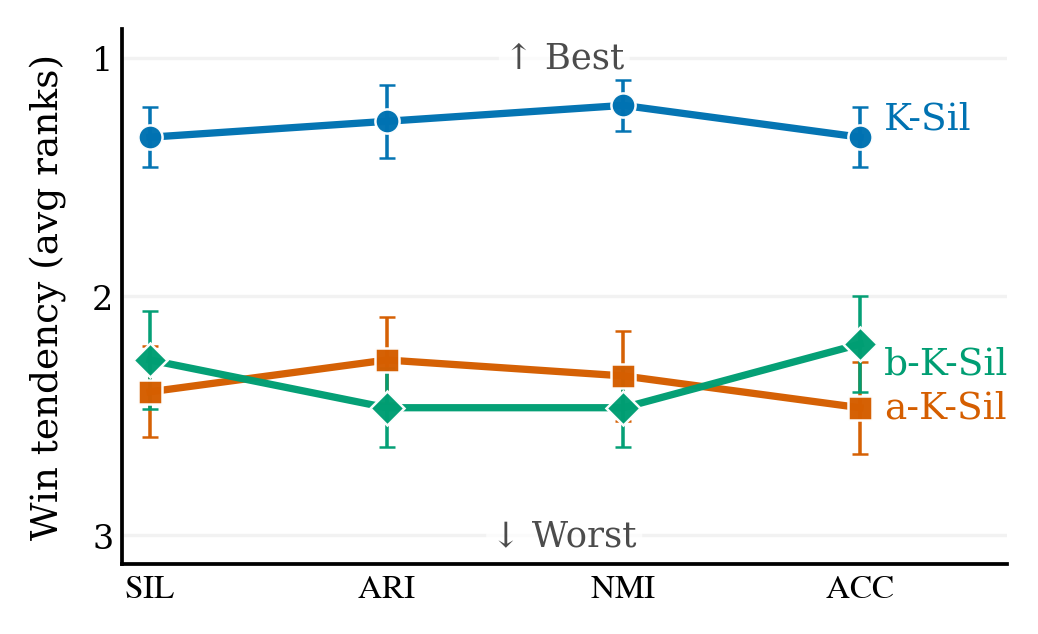

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as mtransforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def proxy_micro_sil(X, labels, centers):
    s_vals, _, _ = KSil.sil_scores(X, labels, centers)
    return KSil.micro_sil(s_vals)

def run_method(ModelClass, X, y, k, seed,
               init="random", max_iter=100, learning_rate=0.2, tol=1e-4,
               n_init=1, n_jobs=1):
    model = ModelClass(
        n_clusters=int(k),
        init=init,
        max_iter=int(max_iter),
        random_state=int(seed),
        learning_rate=float(learning_rate),
        tol=float(tol),
        n_init=int(n_init),
        n_jobs=int(n_jobs),
    )
    model.fit(X)

    labels = model.labels_
    centers = model.cluster_centers_

    return {
        "SIL": proxy_micro_sil(X, labels, centers),
        "ARI": adjusted_rand_score(y, labels),
        "NMI": normalized_mutual_info_score(y, labels),
        "ACC": clustering_accuracy(y, labels),
    }

def run_all_three(X_list, y_list, k_list, name_list,
                  n_runs=10, base_seed=0,
                  init="random", max_iter=100, learning_rate=0.2, tol=1e-4,
                  n_init=1, n_jobs=1):

    method_classes = {
        "KSil": KSil,
        "a_valsKSil": a_valsKSil,
        "b_valsKSil": b_valsKSil,
    }

    results = {name: {m: [] for m in method_classes} for name in name_list}

    for name, X, y, k in zip(name_list, X_list, y_list, k_list):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)

        for r in range(int(n_runs)):
            seed = int(base_seed) + r
            for mkey, MClass in method_classes.items():
                res = run_method(
                    MClass, X, y, k, seed,
                    init=init, max_iter=max_iter, learning_rate=learning_rate, tol=tol,
                    n_init=n_init, n_jobs=n_jobs
                )
                results[name][mkey].append(res)

    agg = {}
    for name in name_list:
        agg[name] = {}
        for mkey in results[name]:
            runs = results[name][mkey]
            agg[name][mkey] = {metric: float(np.mean([r[metric] for r in runs]))
                               for metric in ["SIL", "ARI", "NMI", "ACC"]}
    return agg

def mean_rankscore_across_datasets(agg, name_list, method_keys,
                                  metrics=("SIL","ARI","NMI","ACC"), err="sem"):
    M = len(method_keys)
    means_scores, errs_scores = {}, {}

    for metric in metrics:
        scores_per_method = [[] for _ in method_keys]

        for name in name_list:
            vals = np.array([agg[name][m][metric] for m in method_keys], dtype=float)
            order = np.argsort(-vals)
            ranks = np.empty(M, dtype=int)
            ranks[order] = np.arange(1, M + 1)

            rankscore = (M + 1) - ranks  # rank 1 -> M, rank M -> 1

            for i in range(M):
                scores_per_method[i].append(rankscore[i])

        means, errs = [], []
        for i in range(M):
            s = np.asarray(scores_per_method[i], dtype=float)
            mu = float(s.mean())
            if err == "std":
                e = float(s.std(ddof=1)) if s.size > 1 else 0.0
            else:
                e = float(s.std(ddof=1) / np.sqrt(s.size)) if s.size > 1 else 0.0
            means.append(mu)
            errs.append(e)

        means_scores[metric] = np.asarray(means, dtype=float)
        errs_scores[metric]  = np.asarray(errs, dtype=float)

    return means_scores, errs_scores

def plot_mean_rank_connected(means_scores, errs_scores, method_labels,
                             err_label="SEM across datasets (ranks)",
                             savepath=None, dpi=300,
                             width="column", show_title=False, band_labels=True):
    metrics = ["SIL", "ARI", "NMI", "ACC"]
    x = np.arange(len(metrics))
    M = len(method_labels)

    if width == "column":
        figsize = (3.35, 2)
        ms = 5.8
        lw = 1.75
        cap = 2.0
        label_fs = 8.5
    else:
        figsize = (6.8, 3.6)
        ms = 8.2
        lw = 2.1
        cap = 3.0
        label_fs = 10.5

    colors  = ["#0072B2", "#D55E00", "#009E73"]
    markers = ["o", "s", "D"]

    rc = {
        "figure.dpi": dpi,
        "savefig.dpi": dpi,
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "STIXGeneral", "DejaVu Serif"],
        "mathtext.fontset": "stix",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 9 if width == "column" else 11,
        "axes.labelsize": 9 if width == "column" else 11,
        "xtick.labelsize": 8 if width == "column" else 10,
        "ytick.labelsize": 8 if width == "column" else 10,
        "axes.linewidth": 0.9,
    }

    with mpl.rc_context(rc):
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
        ax.set_axisbelow(True)

        if band_labels:
            trans = mtransforms.blended_transform_factory(ax.transAxes, ax.transData)
            bbox = dict(boxstyle="round,pad=0.15", facecolor="white", edgecolor="none", alpha=0.70)
            ax.text(0.50, 1.0, "↑ Best",  transform=trans, va="center", ha="center",
                    alpha=0.70, fontsize=label_fs, bbox=bbox, zorder=2)
            ax.text(0.50, 3.0, "↓ Worst", transform=trans, va="center", ha="center",
                    alpha=0.70, fontsize=label_fs, bbox=bbox, zorder=2)

        for i, label in enumerate(method_labels):
            y_score = np.array([means_scores[met][i] for met in metrics], dtype=float)
            e_score = np.array([errs_scores[met][i]  for met in metrics], dtype=float)

            y_rank = (M + 1) - y_score
            e_rank = e_score

            ax.errorbar(
                x, y_rank, yerr=e_rank,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                linestyle="-",
                linewidth=lw,
                markersize=ms,
                capsize=cap,
                elinewidth=0.85,
                capthick=0.85,
                alpha=0.98,
                zorder=3,
                markeredgecolor="white",
                markeredgewidth=0.6,
            )

            dy = (i - (M - 1) / 2) * 0.08
            ax.text(x[-1] + 0.10, y_rank[-1] + dy, label,
                    va="center", ha="left",
                    color=colors[i % len(colors)],
                    fontsize=rc["font.size"],
                    clip_on=False)

        ax.set_xticks(x)
        ax.set_xticklabels([r"$\mathrm{SIL}$", r"$\mathrm{ARI}$", r"$\mathrm{NMI}$", r"$\mathrm{ACC}$"])
        ax.set_xlim(x[0] - 0.12, x[-1] + 0.62)

        ax.set_ylabel("Win tendency (avg ranks)", labelpad=6)
        ax.set_yticks(np.arange(1, M + 1))
        ax.set_ylim(M + 0.12, 0.88)

        ax.grid(True, axis="y", alpha=0.16, linewidth=0.8)
        ax.grid(False, axis="x")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="both", length=0, pad=2)

        if show_title:
            ax.set_title(f"Mean rank across datasets ({err_label})", pad=6)

        if savepath is not None:
            fig.savefig(savepath, bbox_inches="tight")

        return fig

agg = run_all_three(
    X_list, y_list, k_list, name_list,
    n_runs=10, base_seed=0,
    init="random", max_iter=100, learning_rate=0.2, tol=1e-4
)

method_keys   = ["KSil", "a_valsKSil", "b_valsKSil"]
method_labels = ["K-Sil", "a-K-Sil", "b-K-Sil"]

means_scores, errs_scores = mean_rankscore_across_datasets(
    agg, name_list=name_list, method_keys=method_keys,
    metrics=("SIL","ARI","NMI","ACC"),
    err="sem"
)

fig = plot_mean_rank_connected(
    means_scores, errs_scores, method_labels,
    err_label="SEM across datasets (ranks)",
    width="column",
    show_title=False,
    band_labels=True
)
plt.show()


### Ablation: K-Sil vs learning rate $\eta$

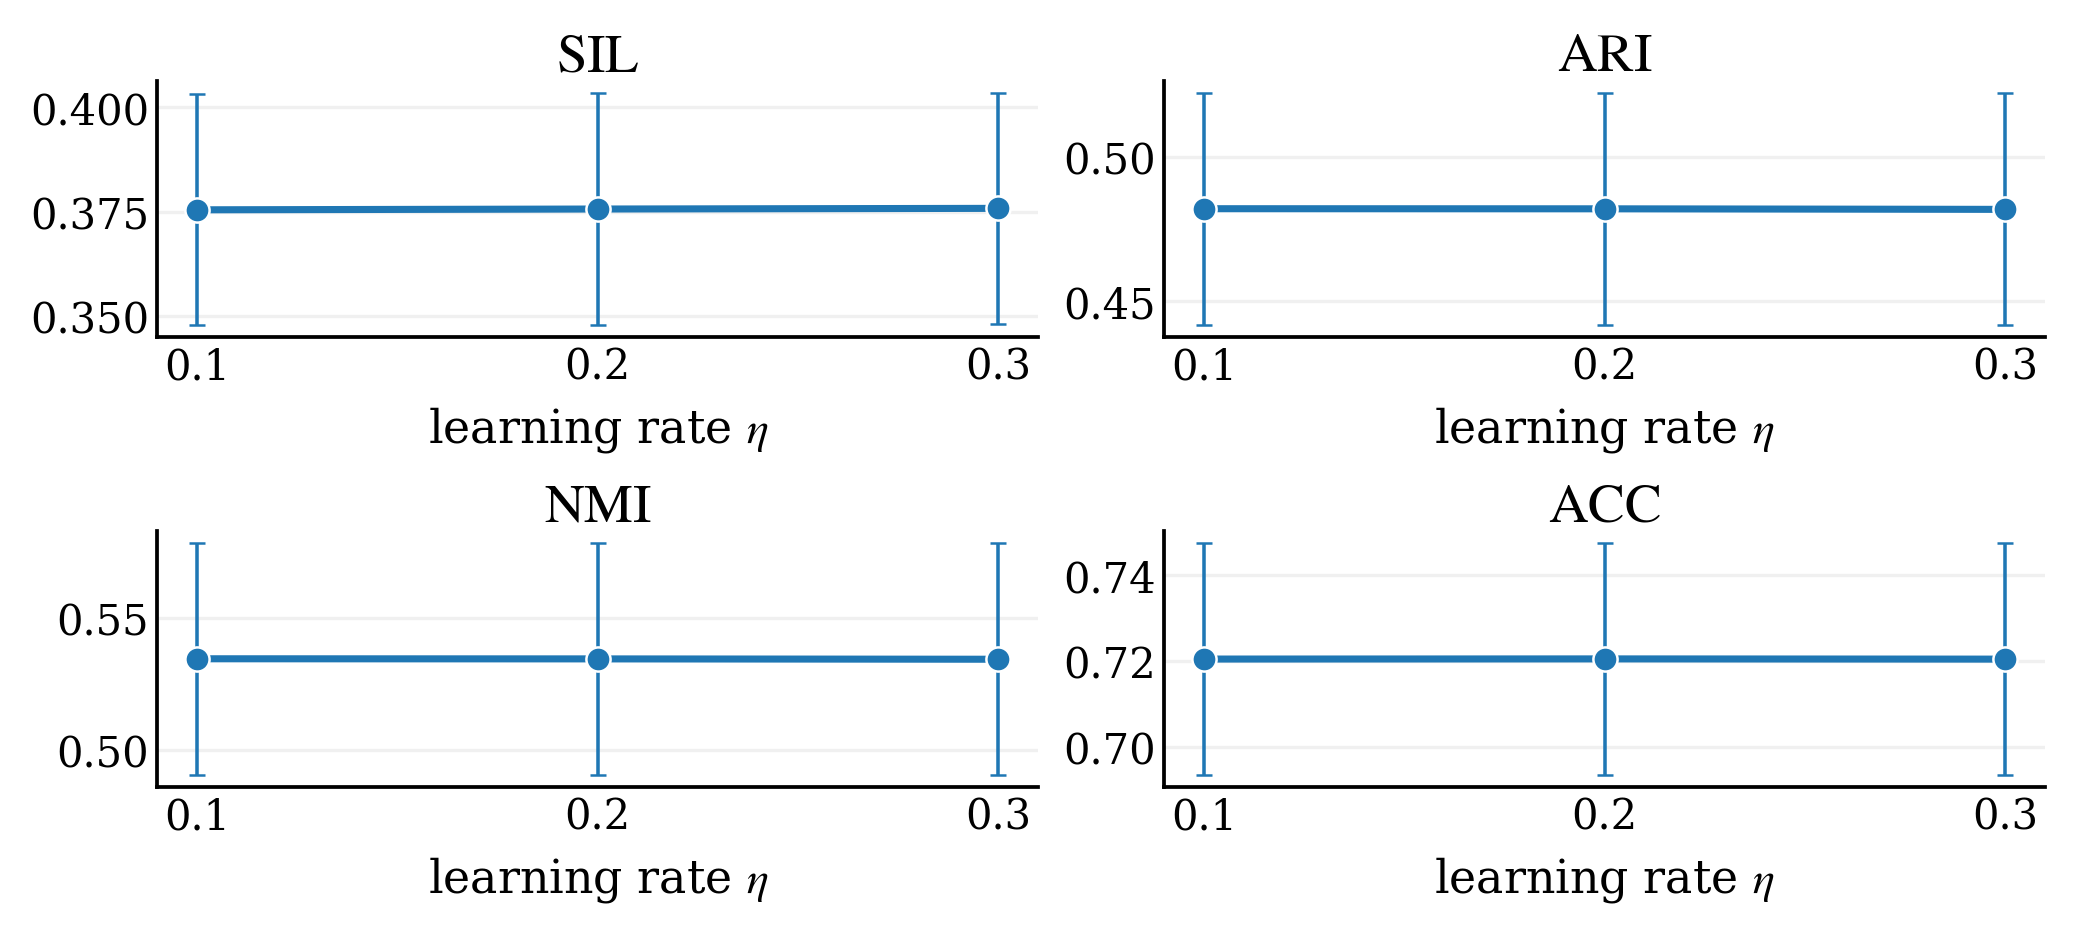

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def proxy_micro_sil(X, labels, centers):
    s_vals, _, _ = KSil.sil_scores(X, labels, centers)
    return KSil.micro_sil(s_vals)

def run_ksil_once(X, y, k, seed, init="random", max_iter=100, learning_rate=0.2, tol=1e-4):
    model = KSil(
        n_clusters=int(k),
        init=init,
        max_iter=int(max_iter),
        random_state=int(seed),
        learning_rate=float(learning_rate),
        tol=float(tol),
        n_init=1,
        n_jobs=1,
    ).fit(X)

    labels = model.labels_
    centers = model.cluster_centers_

    return {
        "SIL": proxy_micro_sil(X, labels, centers),
        "ARI": adjusted_rand_score(y, labels),
        "NMI": normalized_mutual_info_score(y, labels),
        "ACC": clustering_accuracy(y, labels),
    }

def lr_sweep_across_datasets(
    X_list, y_list, k_list, name_list,
    lrs=(0.1, 0.2, 0.3),
    n_runs=3, base_seed=0,
    init="random", max_iter=100, tol=1e-4,
    err="sem",  # "sem" / "std"
):
    metrics = ["SIL", "ARI", "NMI", "ACC"]
    lrs = list(map(float, lrs))

    # collect per (lr, dataset, run)
    per_lr = {lr: {m: [] for m in metrics} for lr in lrs}

    for (X, y, k, nm) in zip(X_list, y_list, k_list, name_list):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)

        for r in range(int(n_runs)):
            seed = int(base_seed) + r
            for lr in lrs:
                out = run_ksil_once(
                    X, y, k, seed,
                    init=init, max_iter=max_iter, learning_rate=lr, tol=tol
                )
                for met in metrics:
                    per_lr[lr][met].append(out[met])

    # aggregate across datasets (and runs)
    means = {m: [] for m in metrics}
    errs  = {m: [] for m in metrics}

    for met in metrics:
        for lr in lrs:
            arr = np.asarray(per_lr[lr][met], dtype=float)
            mu = float(arr.mean())
            if err == "std":
                e = float(arr.std(ddof=1)) if arr.size > 1 else 0.0
            else:
                e = float(arr.std(ddof=1) / np.sqrt(arr.size)) if arr.size > 1 else 0.0
            means[met].append(mu)
            errs[met].append(e)

        means[met] = np.asarray(means[met], dtype=float)
        errs[met]  = np.asarray(errs[met], dtype=float)

    return np.asarray(lrs, dtype=float), means, errs

def plot_lr_ablation(
    lrs, means, errs,
    err_label="SEM across datasets",
    savepath=None, dpi=300,
    width="wide",
    show_title=False,
):
    metrics = ["SIL", "ARI", "NMI", "ACC"]
    titles  = [r"$\mathrm{SIL}$", r"$\mathrm{ARI}$", r"$\mathrm{NMI}$", r"$\mathrm{ACC}$"]

    if width == "column":
        figsize = (3.35, 2.35)
        fs = 9
    else:
        figsize = (6.8, 3.0)
        fs = 11

    rc = {
        "figure.dpi": dpi,
        "savefig.dpi": dpi,
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "STIXGeneral", "DejaVu Serif"],
        "mathtext.fontset": "stix",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": fs,
        "axes.labelsize": fs,
        "xtick.labelsize": fs - 1,
        "ytick.labelsize": fs - 1,
        "axes.linewidth": 0.9,
    }

    with mpl.rc_context(rc):
        fig, axes = plt.subplots(2, 2, figsize=figsize, constrained_layout=True)
        axes = axes.ravel()

        for ax, met, ttl in zip(axes, metrics, titles):
            ax.errorbar(
                lrs, means[met], yerr=errs[met],
                marker="o", linestyle="-",
                linewidth=1.7, markersize=5.8,
                capsize=2.0, elinewidth=0.85, capthick=0.85,
                markeredgecolor="white", markeredgewidth=0.6,
                zorder=3
            )

            ax.set_title(ttl, pad=2)
            ax.set_xticks(lrs)
            ax.set_xlabel(r"learning rate $\eta$")
            ax.grid(True, axis="y", alpha=0.18, linewidth=0.8)
            ax.grid(False, axis="x")
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.tick_params(axis="both", which="both", length=0, pad=2)

        axes[0].set_ylabel("")
        axes[2].set_ylabel("")


        if savepath is not None:
            fig.savefig(savepath, bbox_inches="tight")
        return fig

lrs, means_lr, errs_lr = lr_sweep_across_datasets(
    X_list, y_list, k_list, name_list,
    lrs=(0.1, 0.2, 0.3),
    n_runs=3, base_seed=0,
    init="random", max_iter=100, tol=1e-4,
    err="sem",
)

fig = plot_lr_ablation(
    lrs, means_lr, errs_lr,
    err_label="SEM across datasets",
    width="wide",
    show_title=False
    )
plt.show()


### Ablation: Initial temperature $\tau_0$

In [10]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from joblib import Parallel, delayed

class KSil:
    def __init__(self,
                 n_clusters=3,
                 init='random',
                 max_iter=100,
                 random_state=0,
                 init_temp=1.0,
                 learning_rate=0.2,
                 tol=1e-4,
                 n_init=1, n_jobs=1):

        # Parameters
        self.n_clusters = int(n_clusters)     # Number of clusters
        self.init = init                      # Initialization method
        self.max_iter = int(max_iter)         # Maximum number of iterations
        self.random_state = int(random_state) # Random seed
        self.init_temp = init_temp
        self.learning_rate = learning_rate    # Learning rate for temperature
        self.tol = float(tol)                 # Centroid convergence tolerance

        # For multiple initializations:
        self.n_init = n_init                  # Number of initializations
        self.n_jobs = n_jobs                  # Number of cores

        # n_clusters check
        if self.n_clusters < 2:
           raise ValueError(f"n_clusters ({self.n_clusters}) must be > 1.")
        # init check
        if isinstance(self.init, str) and self.init not in ('random', 'k-means++'):
           raise ValueError(f"init ({self.init}) must be 'random' or 'k-means++'.")
        # n_init check
        if self.n_init < 1:
           raise ValueError(f"n_init ({self.n_init}) must be > 0.")

        # Attributes
        self.labels_ = None          # Cluster labels (converged partition)
        self.cluster_centers_ = None # Cluster centers (converged partition)
        self.n_iter_ = None          # Number of iterations (until convergence)
        self.sil_ = None             # silhouette (centroid-approximated) at converged partition

        # history attributes
        self.centers_history_ = None # Centroids across iterations
        self.labels_history_ = None  # Assignments across iterations
        self.sil_history_ = None     # Silhouette proxy across iterations
        self.weights_history_ = None # Weights across iterations

    def _initialization(self, X, n_clusters):
        X = np.asarray(X)
        if X.shape[0] < n_clusters:
           raise ValueError(f"n_clusters ({n_clusters}) can not exceed n_samples ({X.shape[0]}).")

        kmeans = KMeans(n_clusters=n_clusters,
                        init=self.init,
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        # Retry if some clusters are empty in the initial assignment
        if np.unique(labels).size < n_clusters:
           max_retries = 10 # 10 retries at max
           base_seed = self.random_state
           for attempt in range(1, max_retries + 1):
               seed = base_seed + attempt
               km = KMeans(n_clusters=n_clusters,
                           init=self.init,
                           random_state=seed,
                           n_init=1,
                           max_iter=1).fit(X)
               centers = km.cluster_centers_
               labels = km.labels_
               if np.unique(labels).size == n_clusters:
                  break
           else:
               raise ValueError(
                     f"KMeans (1-iter) initialization produced empty clusters after {max_retries} retries. "
                     f"Try a different random_state, or init='k-means++'.")
        return centers, labels

    def _fit_once(self, X, n_clusters, previous_centers, w):
        X = np.asarray(X)
        w = np.asarray(w)
        km = KMeans(
             n_clusters=n_clusters,
             init=previous_centers,
             n_init=1,
             max_iter=1,
             random_state=self.random_state)
        km.fit(X, sample_weight=w)

        centers = km.cluster_centers_
        labels = km.labels_
        return centers, labels

    @staticmethod
    def sil_scores(X, labels, centers):
        X = np.asarray(X, dtype=float)
        labels = np.asarray(labels, dtype=int)
        centers = np.asarray(centers, dtype=float)

        if len(X) == 0:
           raise ValueError("X is empty. Cannot compute silhouette scores.")

        n = X.shape[0]

        # Squared distances to all centroids
        D = euclidean_distances(X, centers, squared=True)

        # Distance to own centroid (a: intra cluster distance proxy)
        D_diag = D[np.arange(n), labels]  # a^2
        a_vals = np.sqrt(D_diag)  # a

        # Nearest other centroid distance (b: inter cluster distance)
        D_others = D.copy()
        D_others[np.arange(n), labels] = np.inf
        b_sq = D_others.min(axis=1)  # b^2
        b_vals = np.sqrt(b_sq)  # b

        # Silhouette surrogate (b-a)/[max{a,b}+epsilon]
        max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-12)
        s_vals = (b_vals - a_vals) / max_ab

        return s_vals, a_vals, b_vals

    @staticmethod
    def micro_sil(s_vals):
        s_vals = np.asarray(s_vals, dtype=float)
        if s_vals.size == 0:
           return 0.0
        return float(s_vals.mean())

    @staticmethod
    def macro_sil(s_vals, labels):
        s_vals = np.asarray(s_vals, dtype=float)
        labels = np.asarray(labels, dtype=int)

        if s_vals.size == 0 or labels.size == 0:
           return 0.0

        uniq, inv = np.unique(labels, return_inverse=True)
        if uniq.size == 0:
           return 0.0
        sum_per_cluster = np.bincount(inv, weights=s_vals)
        cnt_per_cluster = np.bincount(inv)

        valid = cnt_per_cluster > 0
        if not np.any(valid):
           return 0.0
        cluster_means = sum_per_cluster[valid] / cnt_per_cluster[valid]
        return float(cluster_means.mean())

    def _weights(self, s_vals, temperature):
        s_vals = np.asarray(s_vals, dtype=float)
        weights = np.exp(s_vals * temperature)
        return weights

    def _KSil(self, X, n_clusters, max_iter):

        # Initialize centroids
        centers, labels = self._initialization(X, n_clusters)
        tau = self.init_temp # initial temperature
        prev_score =  None

        centers_history = [centers.copy()]
        labels_history = [labels.copy()]
        sil_history = []
        weights_history = []

        n_iter = 0

        while n_iter < max_iter:

            n_iter += 1

            # Compute point-silhouette scores
            sil_vals, a_vals, b_vals = KSil.sil_scores(X, labels, centers)
            score = KSil.macro_sil(sil_vals, labels)

            micro_sil = KSil.micro_sil(sil_vals)
            sil_history.append(micro_sil)

            # Update temperature
            if prev_score is not None:
               r = (score - prev_score) / max(1 - prev_score, 1e-12)

               r = float(np.clip(r, -1.0, 1.0))

               # data-driven bounds to avoid softmax saturation
               counts = np.bincount(labels, minlength=n_clusters)
               m_max = int(max(counts.max(), 2))
               L     = float(np.sqrt(2.0 * np.log(m_max)))
               z_max = (m_max - 1) / m_max
               tau_min, tau_max = 1e-12, L / max(z_max, 1e-8)

               # multiplicative update (no logs needed)
               eta = self.learning_rate # default: 0.2 (small stable learning rate)

               # Update temperature based on the rate of change of the silhouette objective
               tau = float(np.clip(tau * np.exp(eta * r), tau_min, tau_max))

            # store for next iteration’s drift calc
            prev_score = score

            # Retain previous centroids for convergence checking
            previous_centers = centers.copy()

            # Compute weights based on silhouette scores
            weights = self._weights(sil_vals, tau)

            weights_history.append(weights.copy())

            # Update centroids and assignments
            centers, labels = self._fit_once(X, n_clusters, previous_centers, weights)

            centers_history.append(centers.copy())
            labels_history.append(labels.copy())

            avg_move = np.linalg.norm(centers - previous_centers, axis=1).mean()

            # Centroid stability
            if avg_move < self.tol:
               break

        return centers, labels, n_iter, sil_history, centers_history, labels_history, weights_history

    def fit(self, X):
        """
        Run KSil on X and store the converged partition.
        X: array-like, shape (n_samples, n_features)
        """
        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)

        if self.n_init == 1:
           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = self._KSil(X_arr, self.n_clusters, self.max_iter)
        else:
           base_seed = self.random_state
           seeds = [int(base_seed) + i for i in range(self.n_init)]

           # Helper: directly call _KSil with a seed
           def _run_one(seed):
               self.random_state = seed
               return self._KSil(X_arr, self.n_clusters, self.max_iter)

           if self.n_jobs in (None, 1):
              results = [_run_one(seed) for seed in seeds]
           else:
              results = Parallel(n_jobs=self.n_jobs)(delayed(_run_one)(seed) for seed in seeds)

           # Pick best run by final silhouette
           best_idx = None
           best_sil = -np.inf

           for i, res in enumerate(results):
               (_, _, _, sil_history_i,
               _, _, _) = res
               if sil_history_i:
                  final_sil_i = sil_history_i[-1]
               else:
                  final_sil_i = -np.inf
               if final_sil_i > best_sil:
                   best_sil = final_sil_i
                   best_idx = i

           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = results[best_idx]

           self.random_state = base_seed # restore base random_state

        self.cluster_centers_ = centers
        self.labels_ = labels
        self.n_iter_ = n_iter

        self.sil_history_ = sil_history
        self.sil_ = sil_history[-1] if sil_history else None
        self.centers_history_ = centers_history
        self.labels_history_ = labels_history
        self.weights_history_ = weights_history

        return self

    def predict(self, X):
        """
        Assign new points to the nearest learned centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        dist_matrix = euclidean_distances(X_arr, self.cluster_centers_, squared=True)
        labels = np.argmin(dist_matrix, axis=1)
        return labels.astype(int)

    def transform(self, X):
        """
        Return distances of each sample to each centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        distances = euclidean_distances(X_arr, self.cluster_centers_, squared=False)
        return distances

    def fit_predict(self, X):
        """
        Equivalent to: fit(X); return labels_.
        """
        self.fit(X)
        return self.labels_

    def fit_transform(self, X):
        """
        Equivalent to: fit(X); return transform(X).
        """
        self.fit(X)
        return self.transform(X)

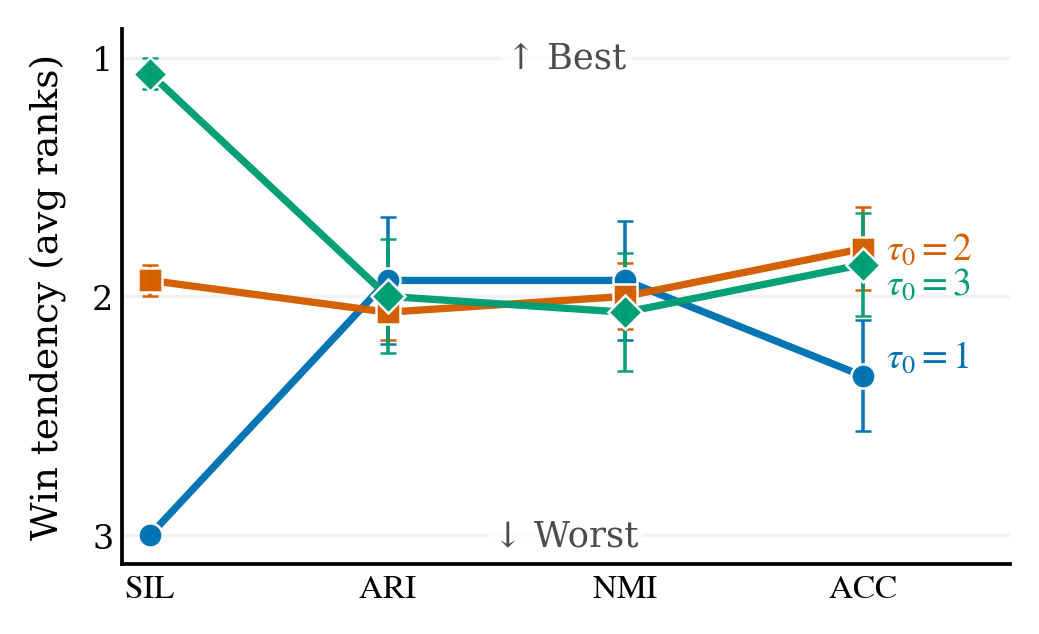

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as mtransforms
from functools import partial
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def proxy_micro_sil(X, labels, centers):
    s_vals, _, _ = KSil.sil_scores(X, labels, centers)
    return KSil.micro_sil(s_vals)

def run_method(ModelClass, X, y, k, seed,
               init="random", max_iter=100, learning_rate=0.2, tol=1e-4,
               n_init=1, n_jobs=1):
    model = ModelClass(
        n_clusters=int(k),
        init=init,
        max_iter=int(max_iter),
        random_state=int(seed),
        learning_rate=float(learning_rate),
        tol=float(tol),
        n_init=int(n_init),
        n_jobs=int(n_jobs),
    )
    model.fit(X)

    labels = model.labels_
    centers = model.cluster_centers_

    return {
        "SIL": proxy_micro_sil(X, labels, centers),
        "ARI": adjusted_rand_score(y, labels),
        "NMI": normalized_mutual_info_score(y, labels),
        "ACC": clustering_accuracy(y, labels),
    }

def run_all_three(X_list, y_list, k_list, name_list,
                  n_runs=10, base_seed=0,
                  init="random", max_iter=100, learning_rate=0.2, tol=1e-4,
                  n_init=1, n_jobs=1):

    method_classes = {
        r"$\tau_0 = 1$": partial(KSil, init_temp=1.0),
        r"$\tau_0 = 2$": partial(KSil, init_temp=2.0),
        r"$\tau_0 = 3$": partial(KSil, init_temp=3.0),
    }

    results = {name: {m: [] for m in method_classes} for name in name_list}

    for name, X, y, k in zip(name_list, X_list, y_list, k_list):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)

        for r in range(int(n_runs)):
            seed = int(base_seed) + r
            for mkey, MClass in method_classes.items():
                res = run_method(
                    MClass, X, y, k, seed,
                    init=init, max_iter=max_iter, learning_rate=learning_rate, tol=tol,
                    n_init=n_init, n_jobs=n_jobs
                )
                results[name][mkey].append(res)

    agg = {}
    for name in name_list:
        agg[name] = {}
        for mkey in results[name]:
            runs = results[name][mkey]
            agg[name][mkey] = {metric: float(np.mean([r[metric] for r in runs]))
                               for metric in ["SIL", "ARI", "NMI", "ACC"]}
    return agg

def mean_rankscore_across_datasets(agg, name_list, method_keys,
                                  metrics=("SIL","ARI","NMI","ACC"), err="sem"):
    M = len(method_keys)
    means_scores, errs_scores = {}, {}

    for metric in metrics:
        scores_per_method = [[] for _ in method_keys]

        for name in name_list:
            vals = np.array([agg[name][m][metric] for m in method_keys], dtype=float)
            order = np.argsort(-vals)
            ranks = np.empty(M, dtype=int)
            ranks[order] = np.arange(1, M + 1)
            rankscore = (M + 1) - ranks

            for i in range(M):
                scores_per_method[i].append(rankscore[i])

        means, errs = [], []
        for i in range(M):
            s = np.asarray(scores_per_method[i], dtype=float)
            mu = float(s.mean())
            if err == "std":
                e = float(s.std(ddof=1)) if s.size > 1 else 0.0
            else:
                e = float(s.std(ddof=1) / np.sqrt(s.size)) if s.size > 1 else 0.0
            means.append(mu)
            errs.append(e)

        means_scores[metric] = np.asarray(means, dtype=float)
        errs_scores[metric]  = np.asarray(errs, dtype=float)

    return means_scores, errs_scores

def plot_mean_rank_connected(means_scores, errs_scores, method_labels,
                             err_label="SEM across datasets (ranks)",
                             savepath=None, dpi=300,
                             width="column", show_title=False, band_labels=True):
    metrics = ["SIL", "ARI", "NMI", "ACC"]
    x = np.arange(len(metrics))
    M = len(method_labels)

    if width == "column":
        figsize = (3.35, 2)
        ms = 5.8
        lw = 1.75
        cap = 2.0
        label_fs = 8.5
    else:
        figsize = (6.8, 3.6)
        ms = 8.2
        lw = 2.1
        cap = 3.0
        label_fs = 10.5

    colors  = ["#0072B2", "#D55E00", "#009E73"]
    markers = ["o", "s", "D"]

    rc = {
        "figure.dpi": dpi,
        "savefig.dpi": dpi,
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "STIXGeneral", "DejaVu Serif"],
        "mathtext.fontset": "stix",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 9 if width == "column" else 11,
        "axes.labelsize": 9 if width == "column" else 11,
        "xtick.labelsize": 8 if width == "column" else 10,
        "ytick.labelsize": 8 if width == "column" else 10,
        "axes.linewidth": 0.9,
    }

    with mpl.rc_context(rc):
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
        ax.set_axisbelow(True)

        if band_labels:
            trans = mtransforms.blended_transform_factory(ax.transAxes, ax.transData)
            bbox = dict(boxstyle="round,pad=0.15", facecolor="white", edgecolor="none", alpha=0.70)
            ax.text(0.50, 1.0, "↑ Best",  transform=trans, va="center", ha="center",
                    alpha=0.70, fontsize=label_fs, bbox=bbox, zorder=2)
            ax.text(0.50, 3.0, "↓ Worst", transform=trans, va="center", ha="center",
                    alpha=0.70, fontsize=label_fs, bbox=bbox, zorder=2)

        for i, label in enumerate(method_labels):
            y_score = np.array([means_scores[met][i] for met in metrics], dtype=float)
            e_score = np.array([errs_scores[met][i]  for met in metrics], dtype=float)

            y_rank = (M + 1) - y_score
            e_rank = e_score

            ax.errorbar(
                x, y_rank, yerr=e_rank,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                linestyle="-",
                linewidth=lw,
                markersize=ms,
                capsize=cap,
                elinewidth=0.85,
                capthick=0.85,
                alpha=0.98,
                zorder=3,
                markeredgecolor="white",
                markeredgewidth=0.6,
            )

            dy = (i - (M - 1) / 2) * 0.08
            ax.text(x[-1] + 0.10, y_rank[-1] + dy, label,
                    va="center", ha="left",
                    color=colors[i % len(colors)],
                    fontsize=rc["font.size"],
                    clip_on=False)

        ax.set_xticks(x)
        ax.set_xticklabels([r"$\mathrm{SIL}$", r"$\mathrm{ARI}$", r"$\mathrm{NMI}$", r"$\mathrm{ACC}$"])
        ax.set_xlim(x[0] - 0.12, x[-1] + 0.62)

        ax.set_ylabel("Win tendency (avg ranks)", labelpad=6)
        ax.set_yticks(np.arange(1, M + 1))
        ax.set_ylim(M + 0.12, 0.88)

        ax.grid(True, axis="y", alpha=0.16, linewidth=0.8)
        ax.grid(False, axis="x")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="both", length=0, pad=2)

        if show_title:
            ax.set_title(f"Mean rank across datasets ({err_label})", pad=6)

        if savepath is not None:
            fig.savefig(savepath, bbox_inches="tight")

        return fig

agg = run_all_three(
    X_list, y_list, k_list, name_list,
    n_runs=10, base_seed=0,
    init="random", max_iter=100, learning_rate=0.2, tol=1e-4
)

method_keys   = [r"$\tau_0 = 1$", r"$\tau_0 = 2$", r"$\tau_0 = 3$"]
method_labels = [r"$\tau_0 = 1$", r"$\tau_0 = 2$", r"$\tau_0 = 3$"]

means_scores, errs_scores = mean_rankscore_across_datasets(
    agg, name_list=name_list, method_keys=method_keys,
    metrics=("SIL","ARI","NMI","ACC"),
    err="sem"
)

fig = plot_mean_rank_connected(
    means_scores, errs_scores, method_labels,
    err_label="SEM across datasets (ranks)",
    width="column",
    show_title=False,
    band_labels=True
)
plt.show()

#### Silhouette scores distributions in initialization

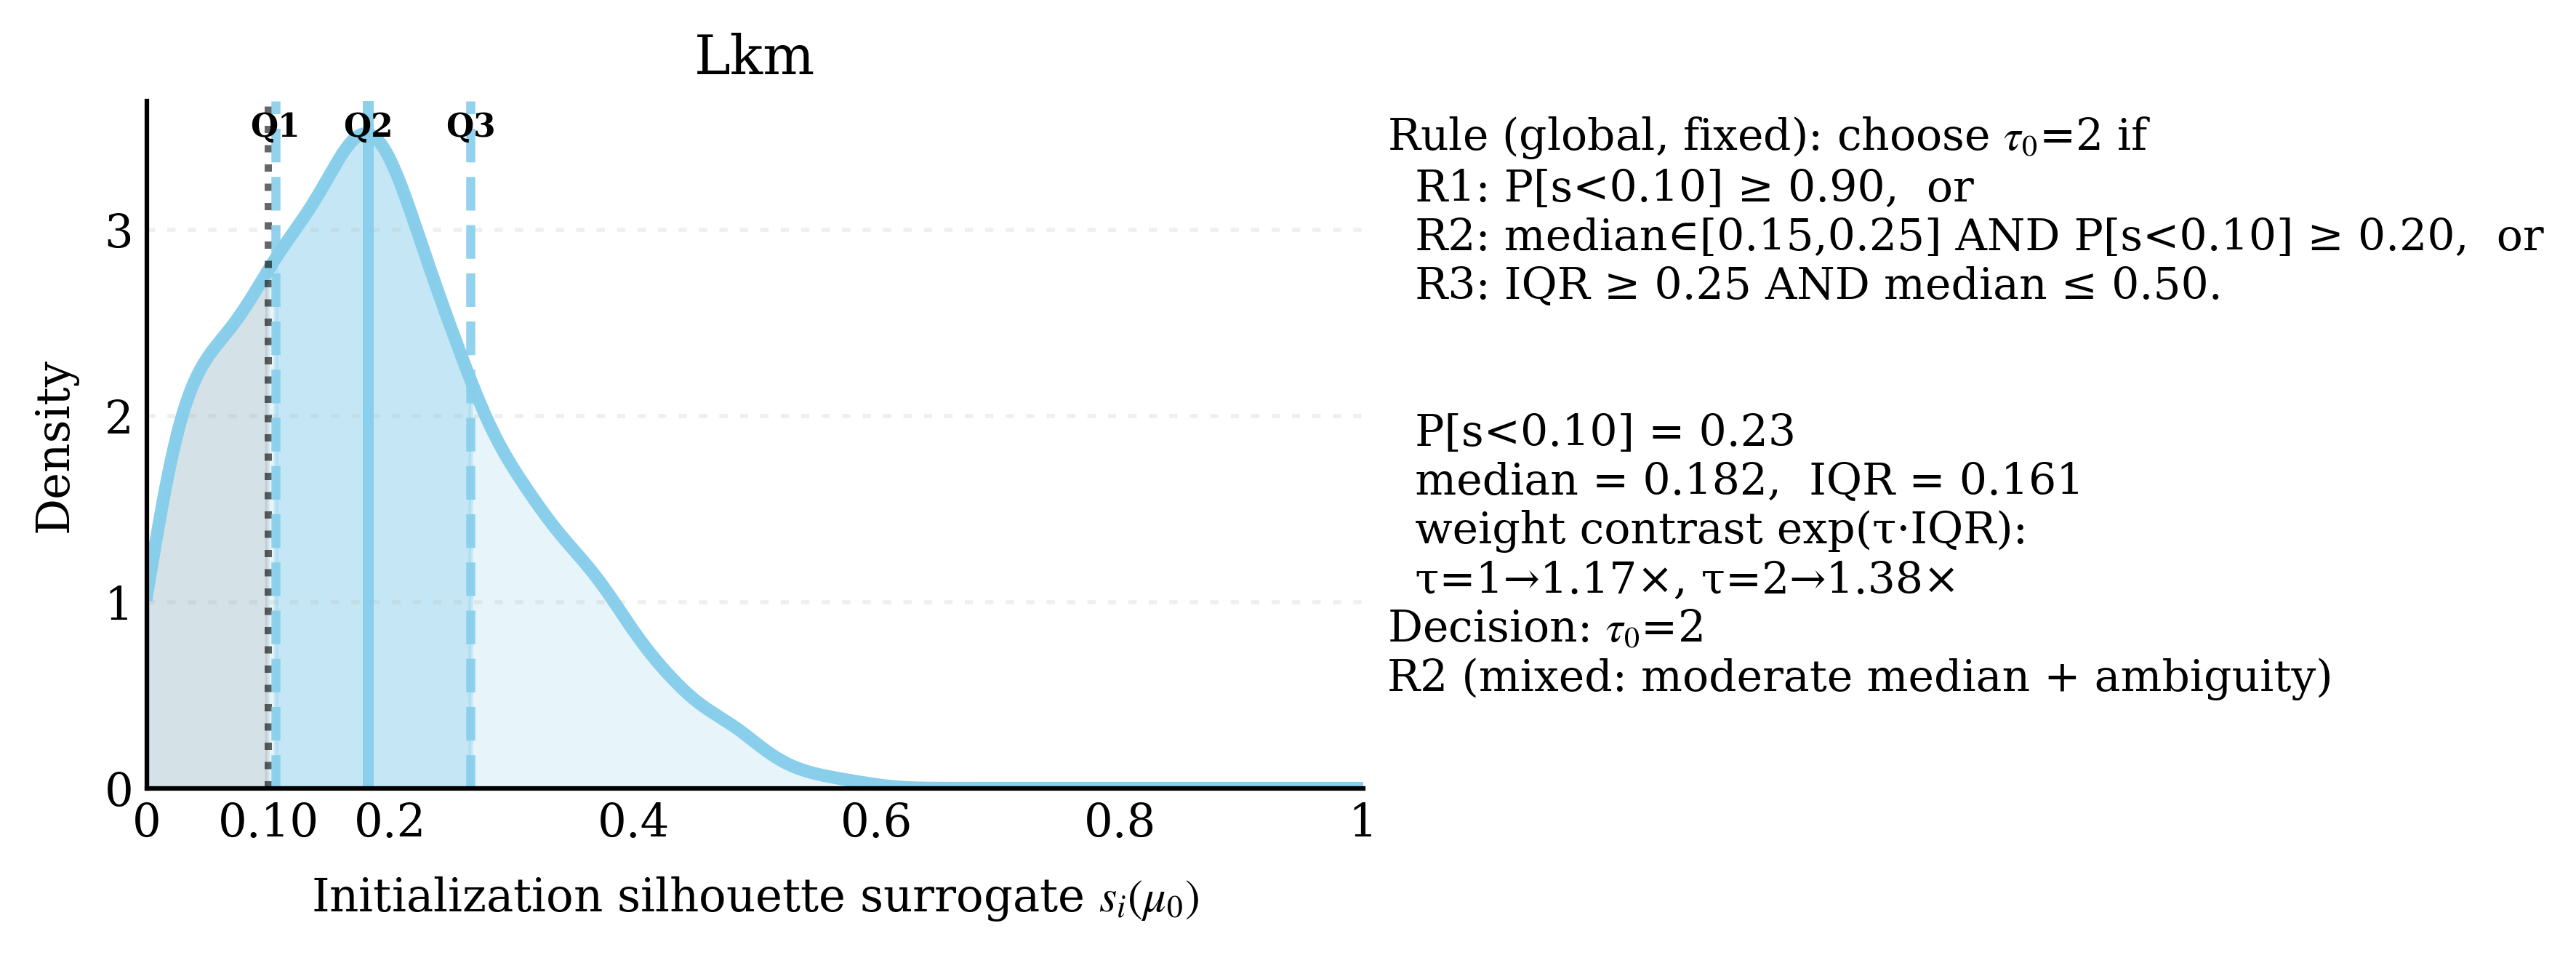

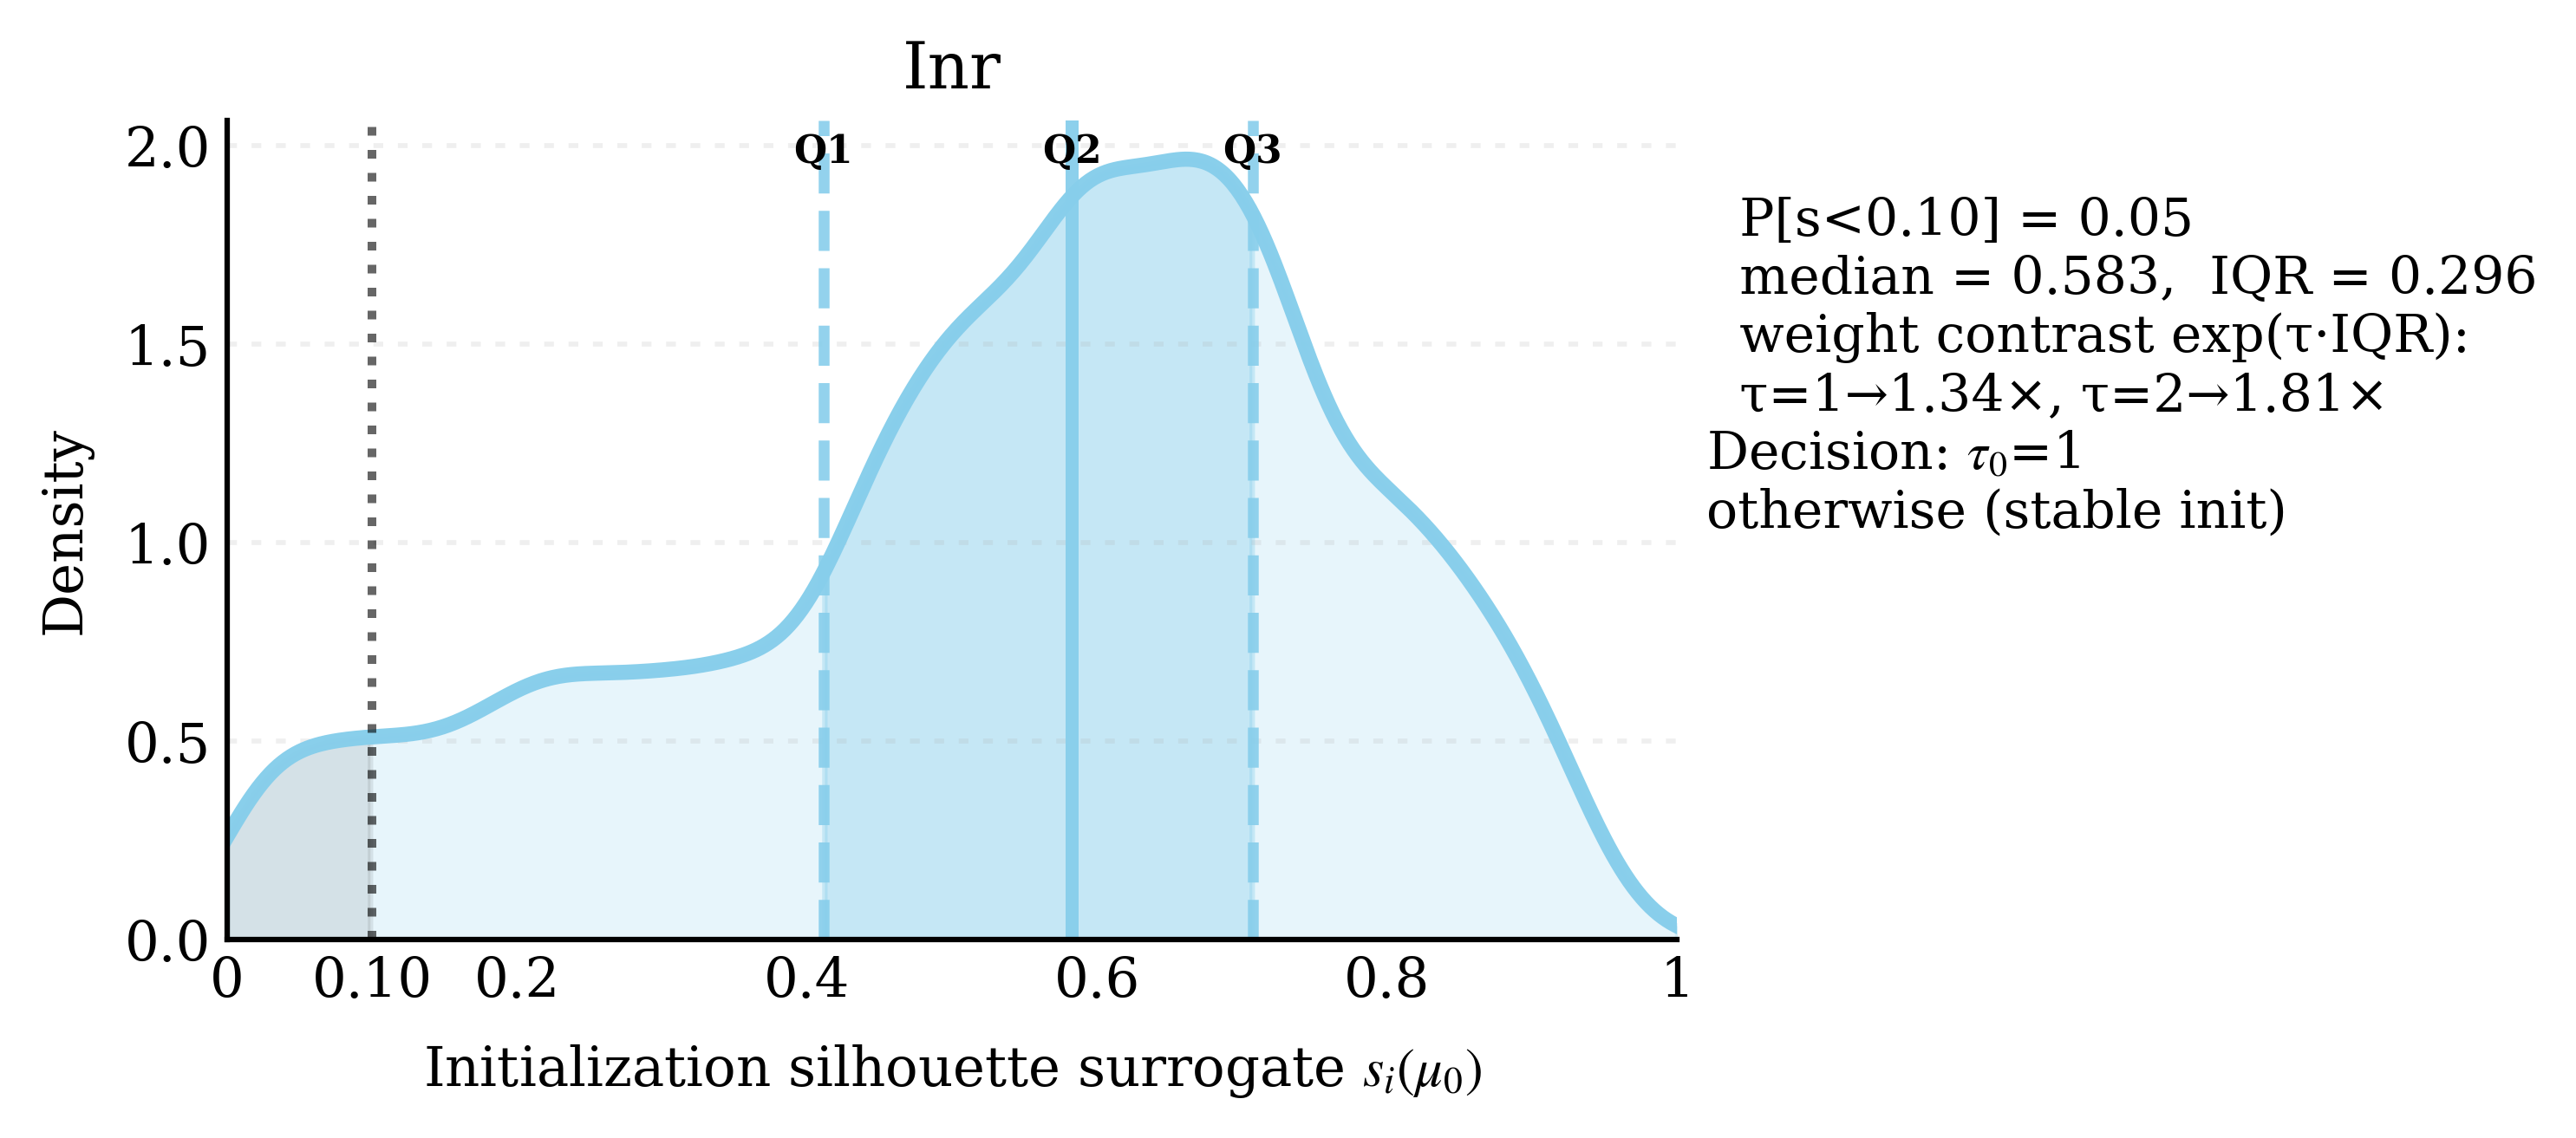

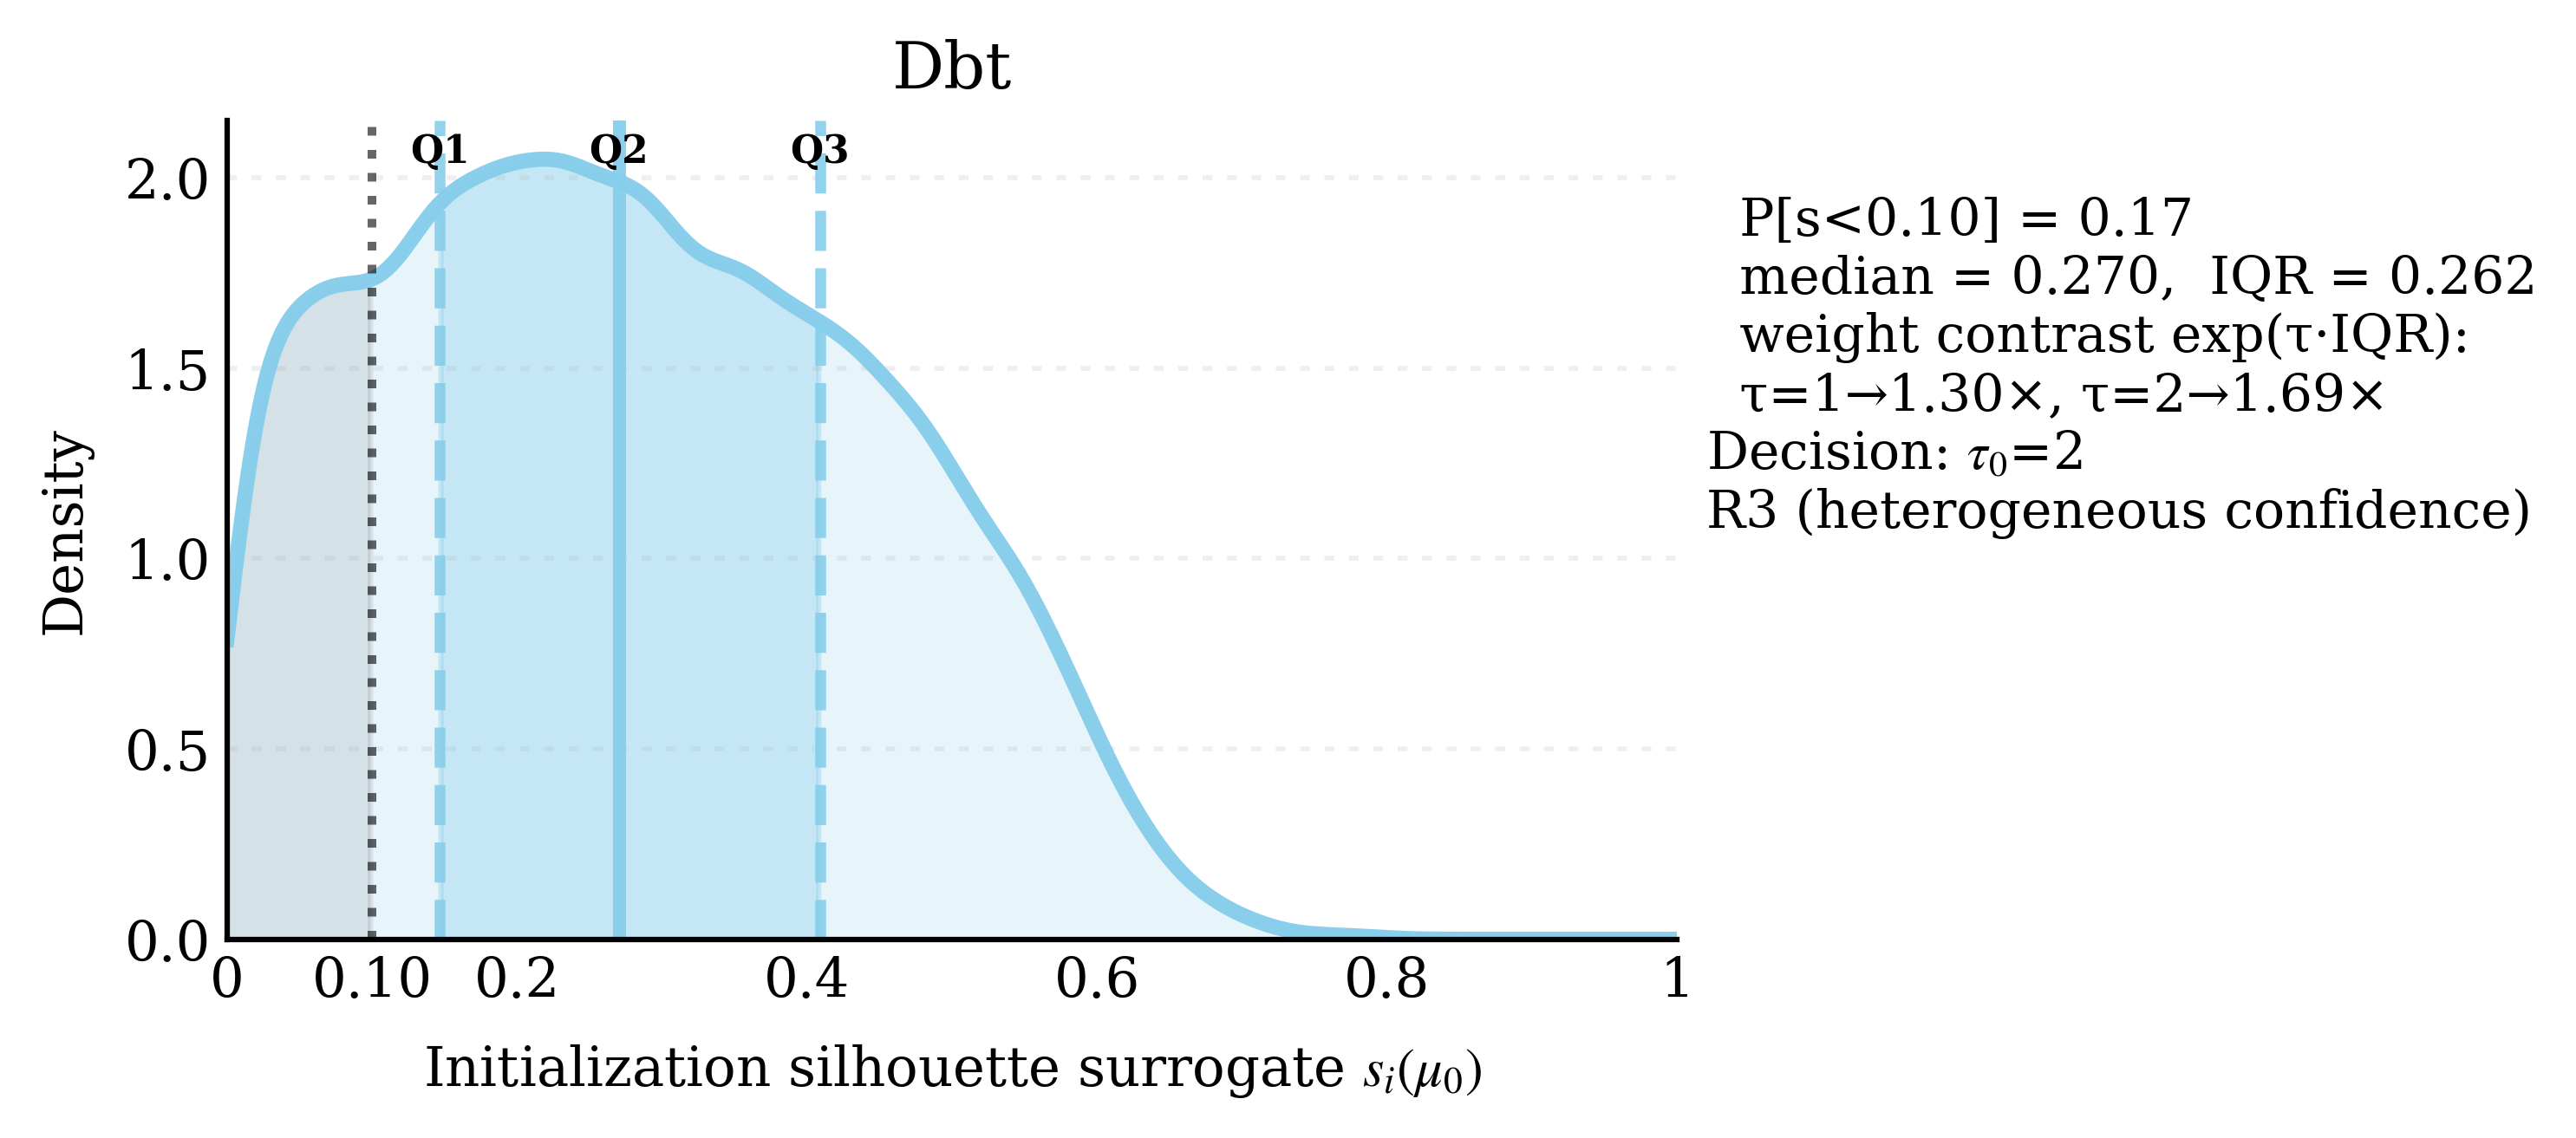

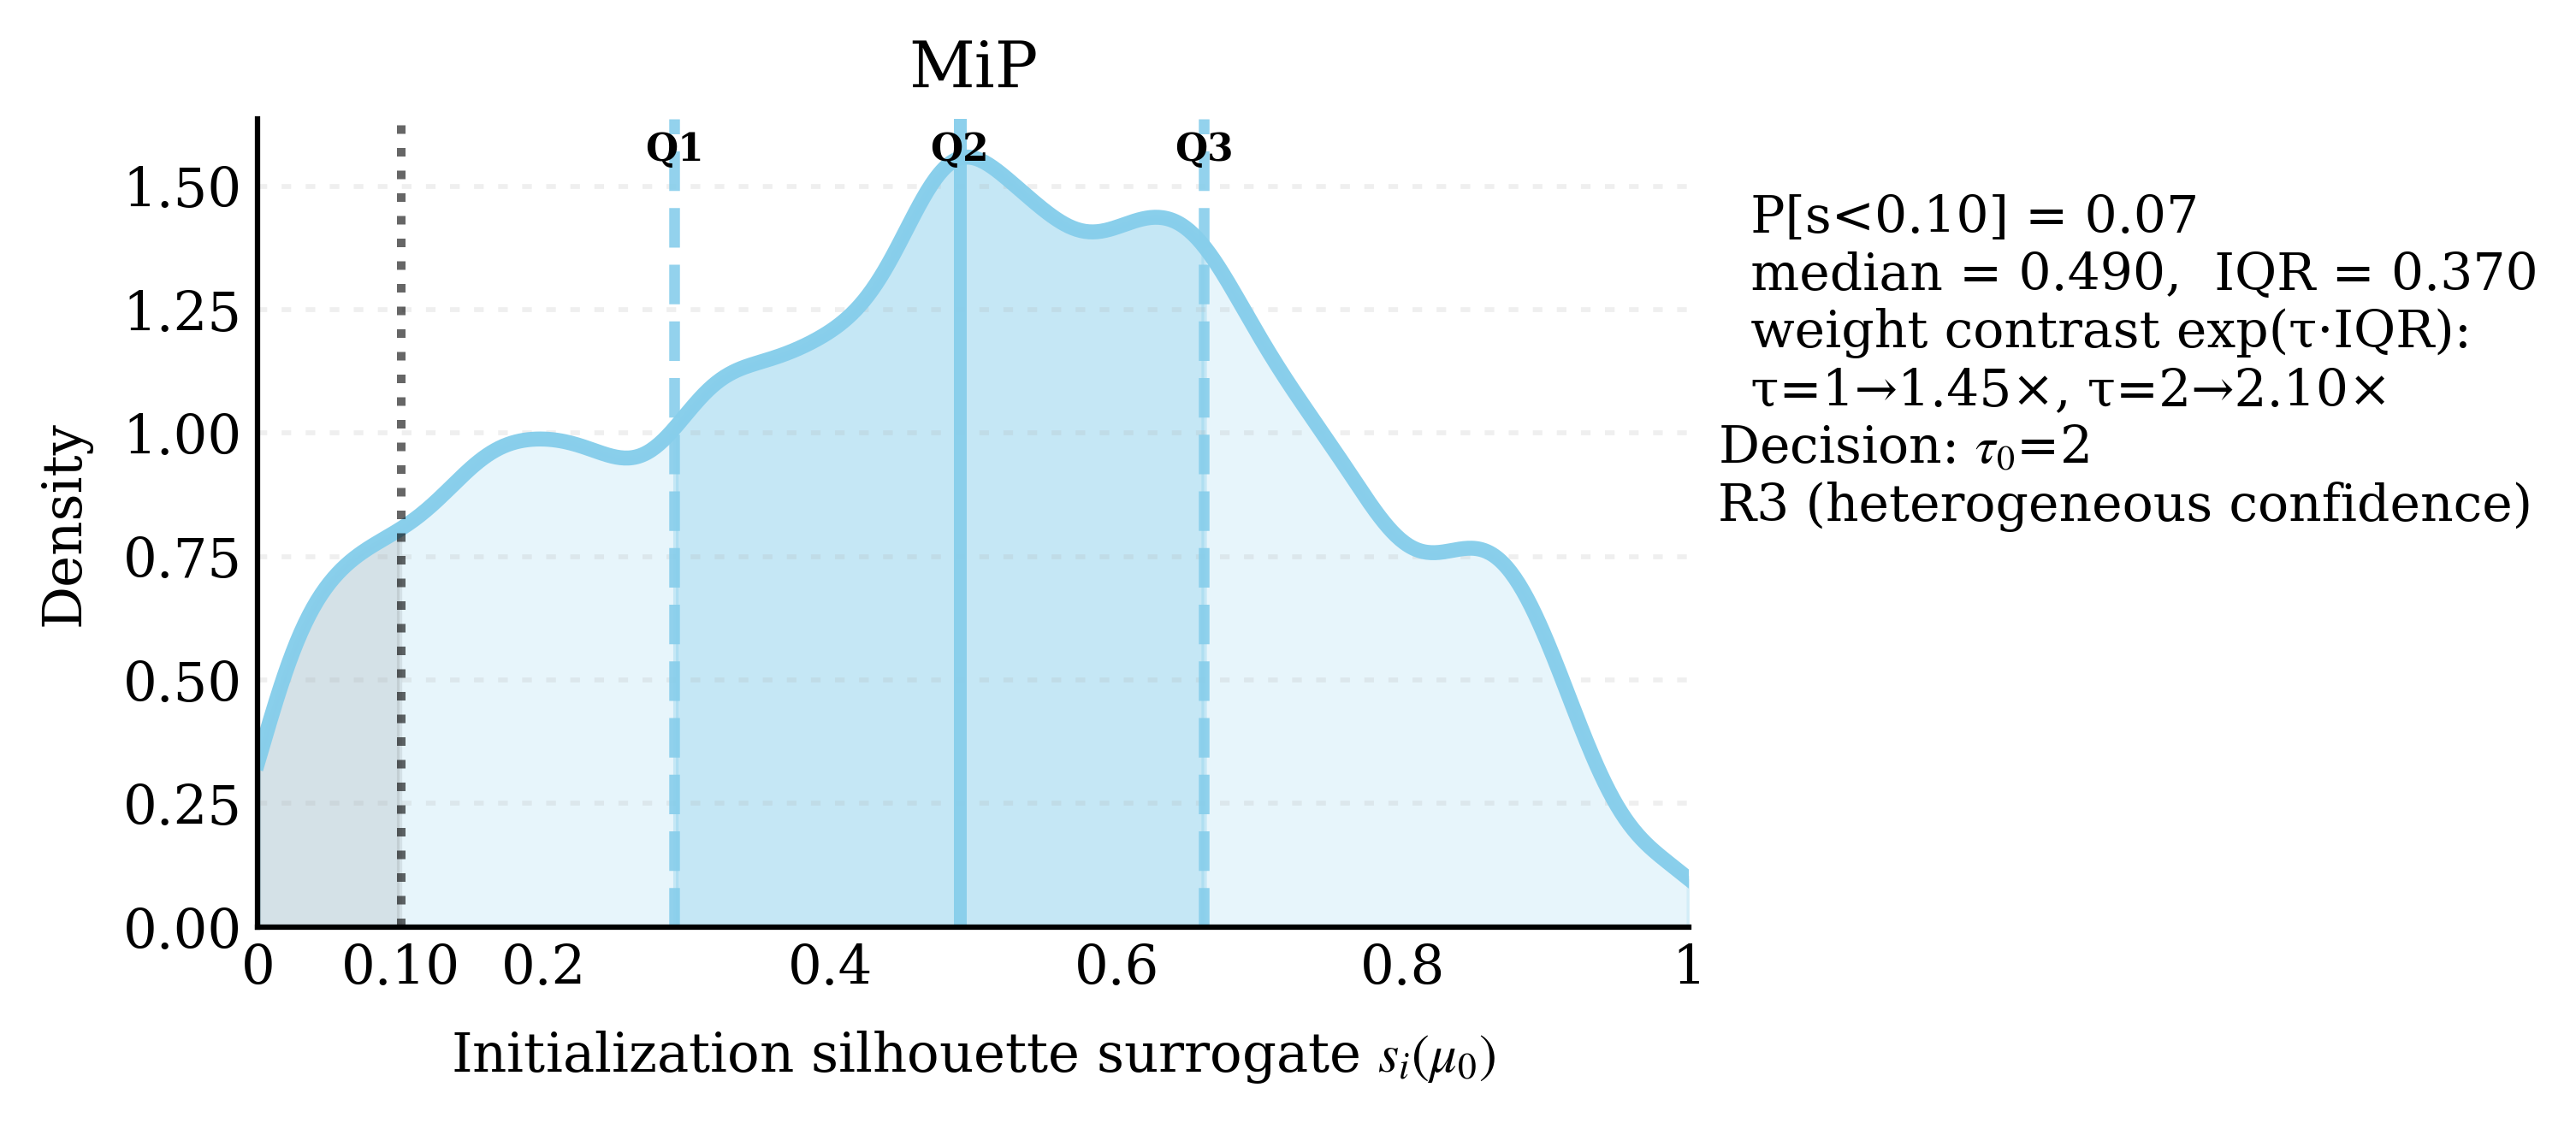

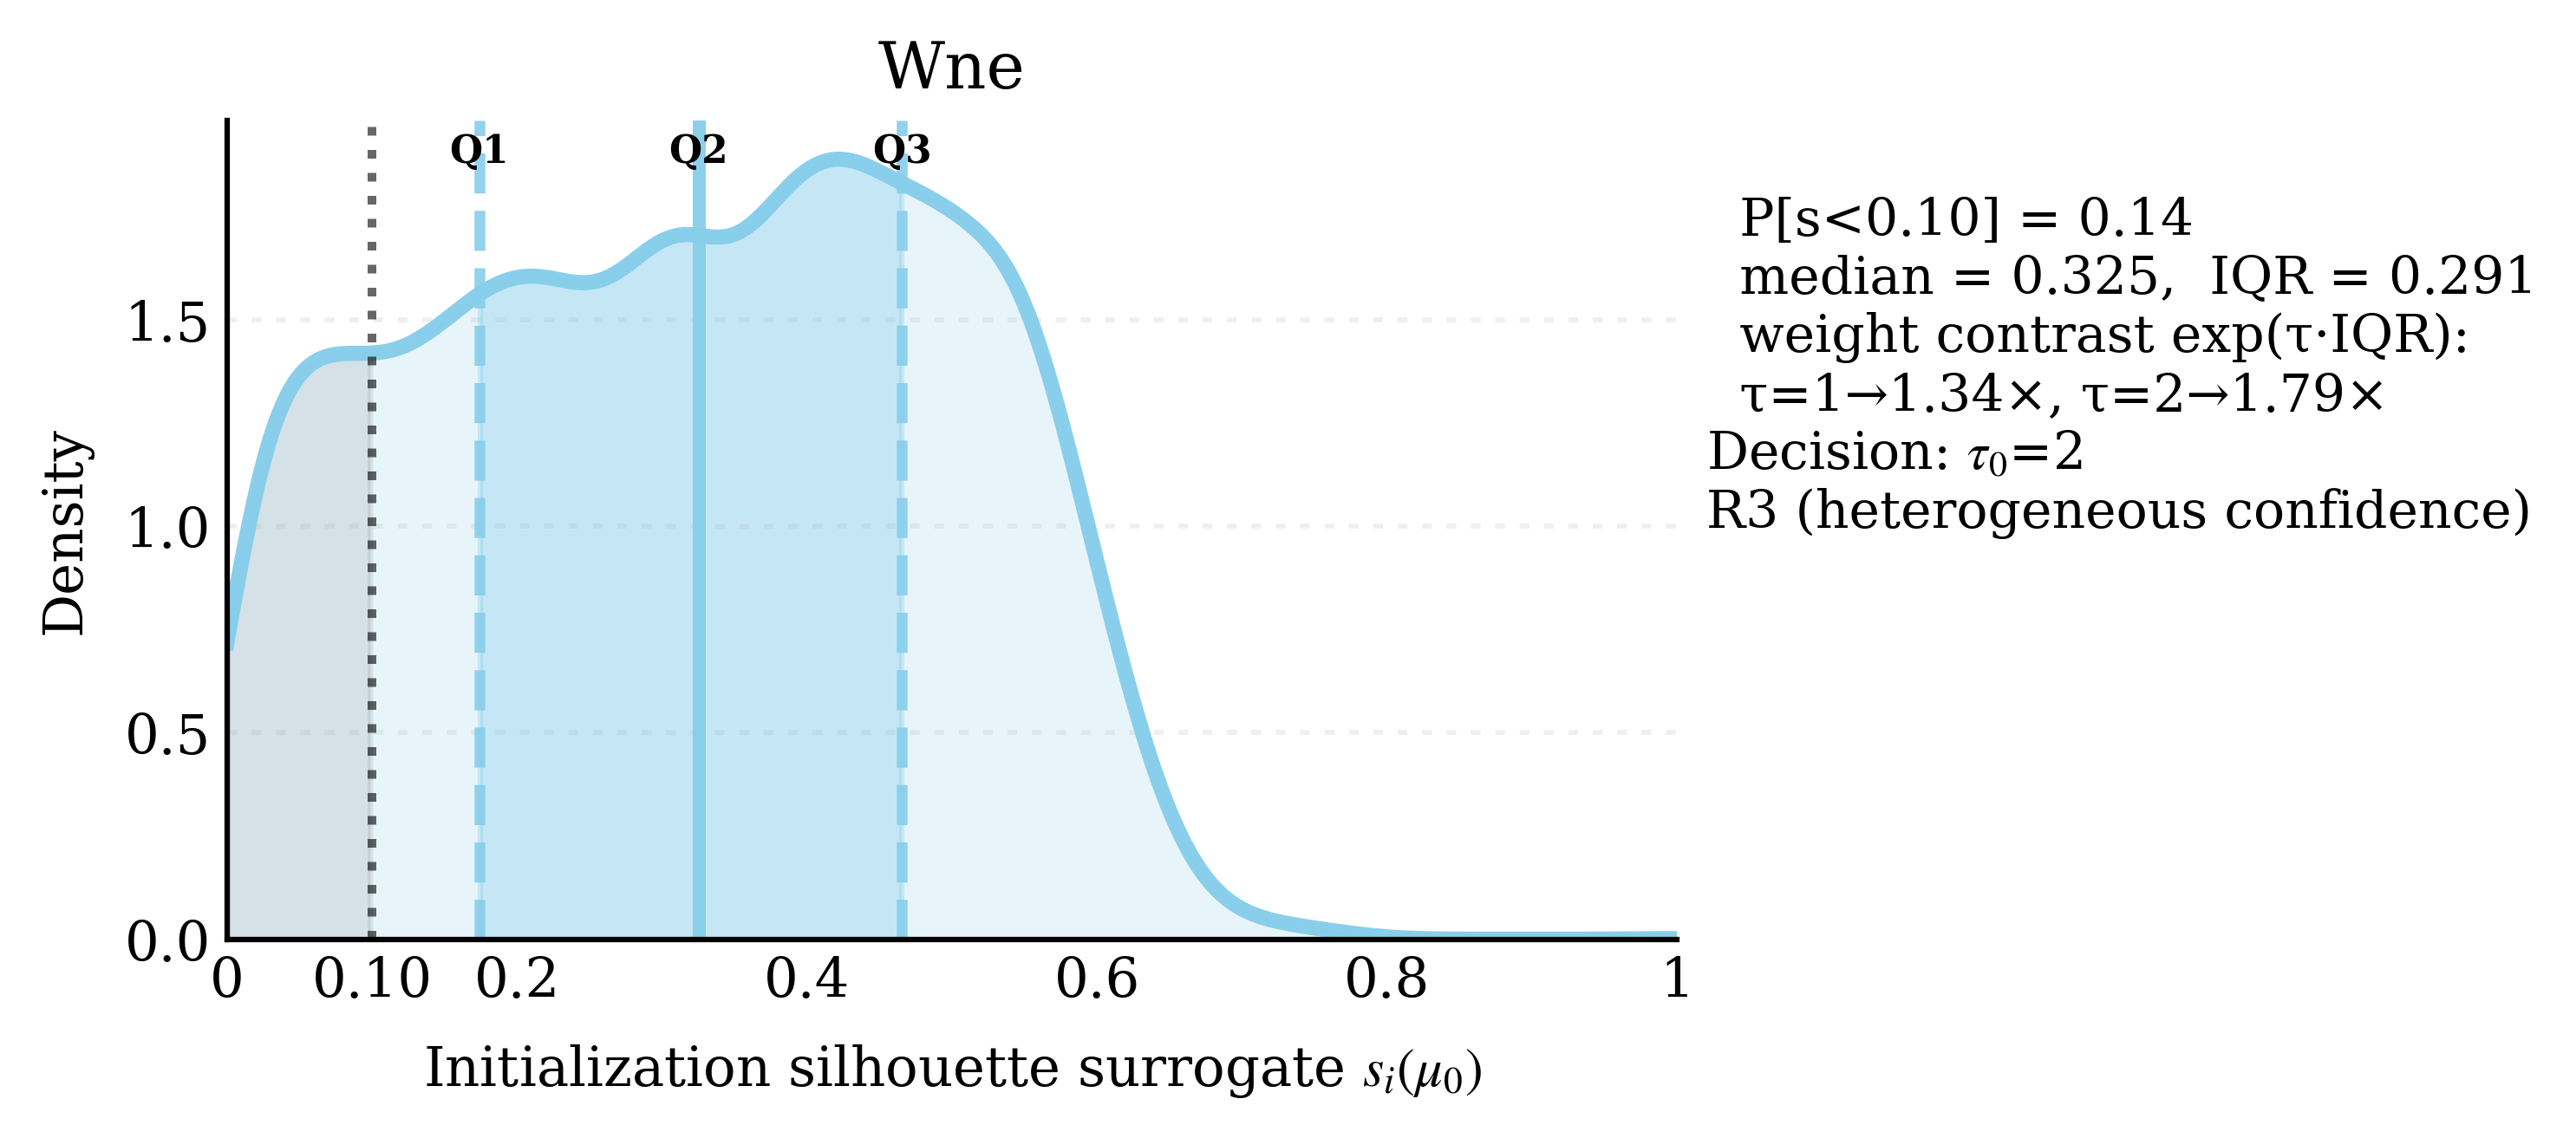

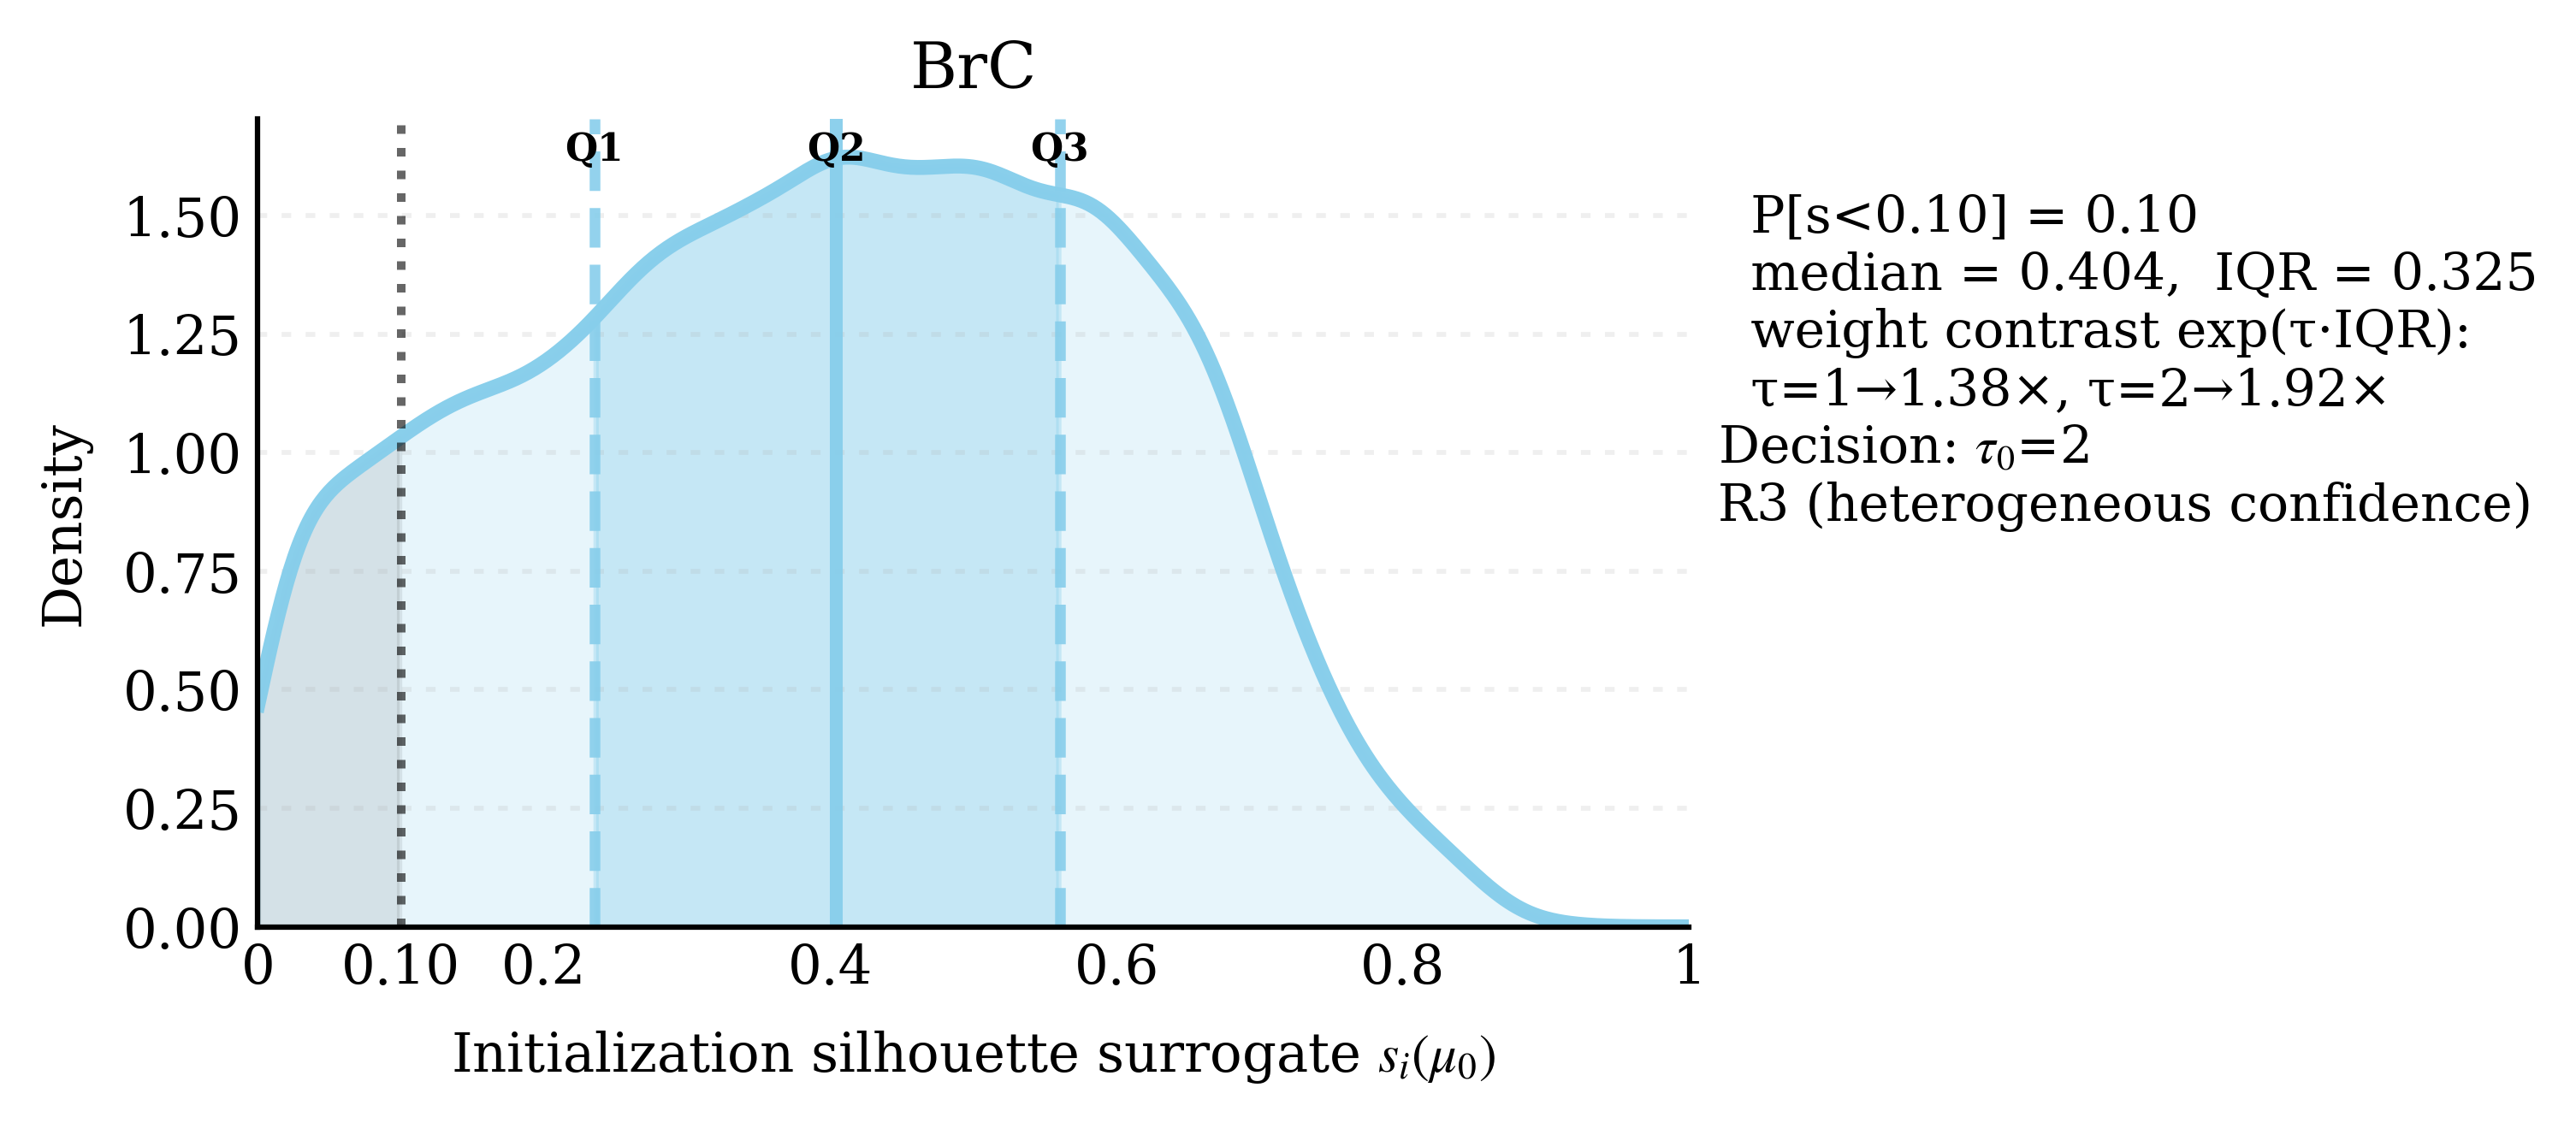

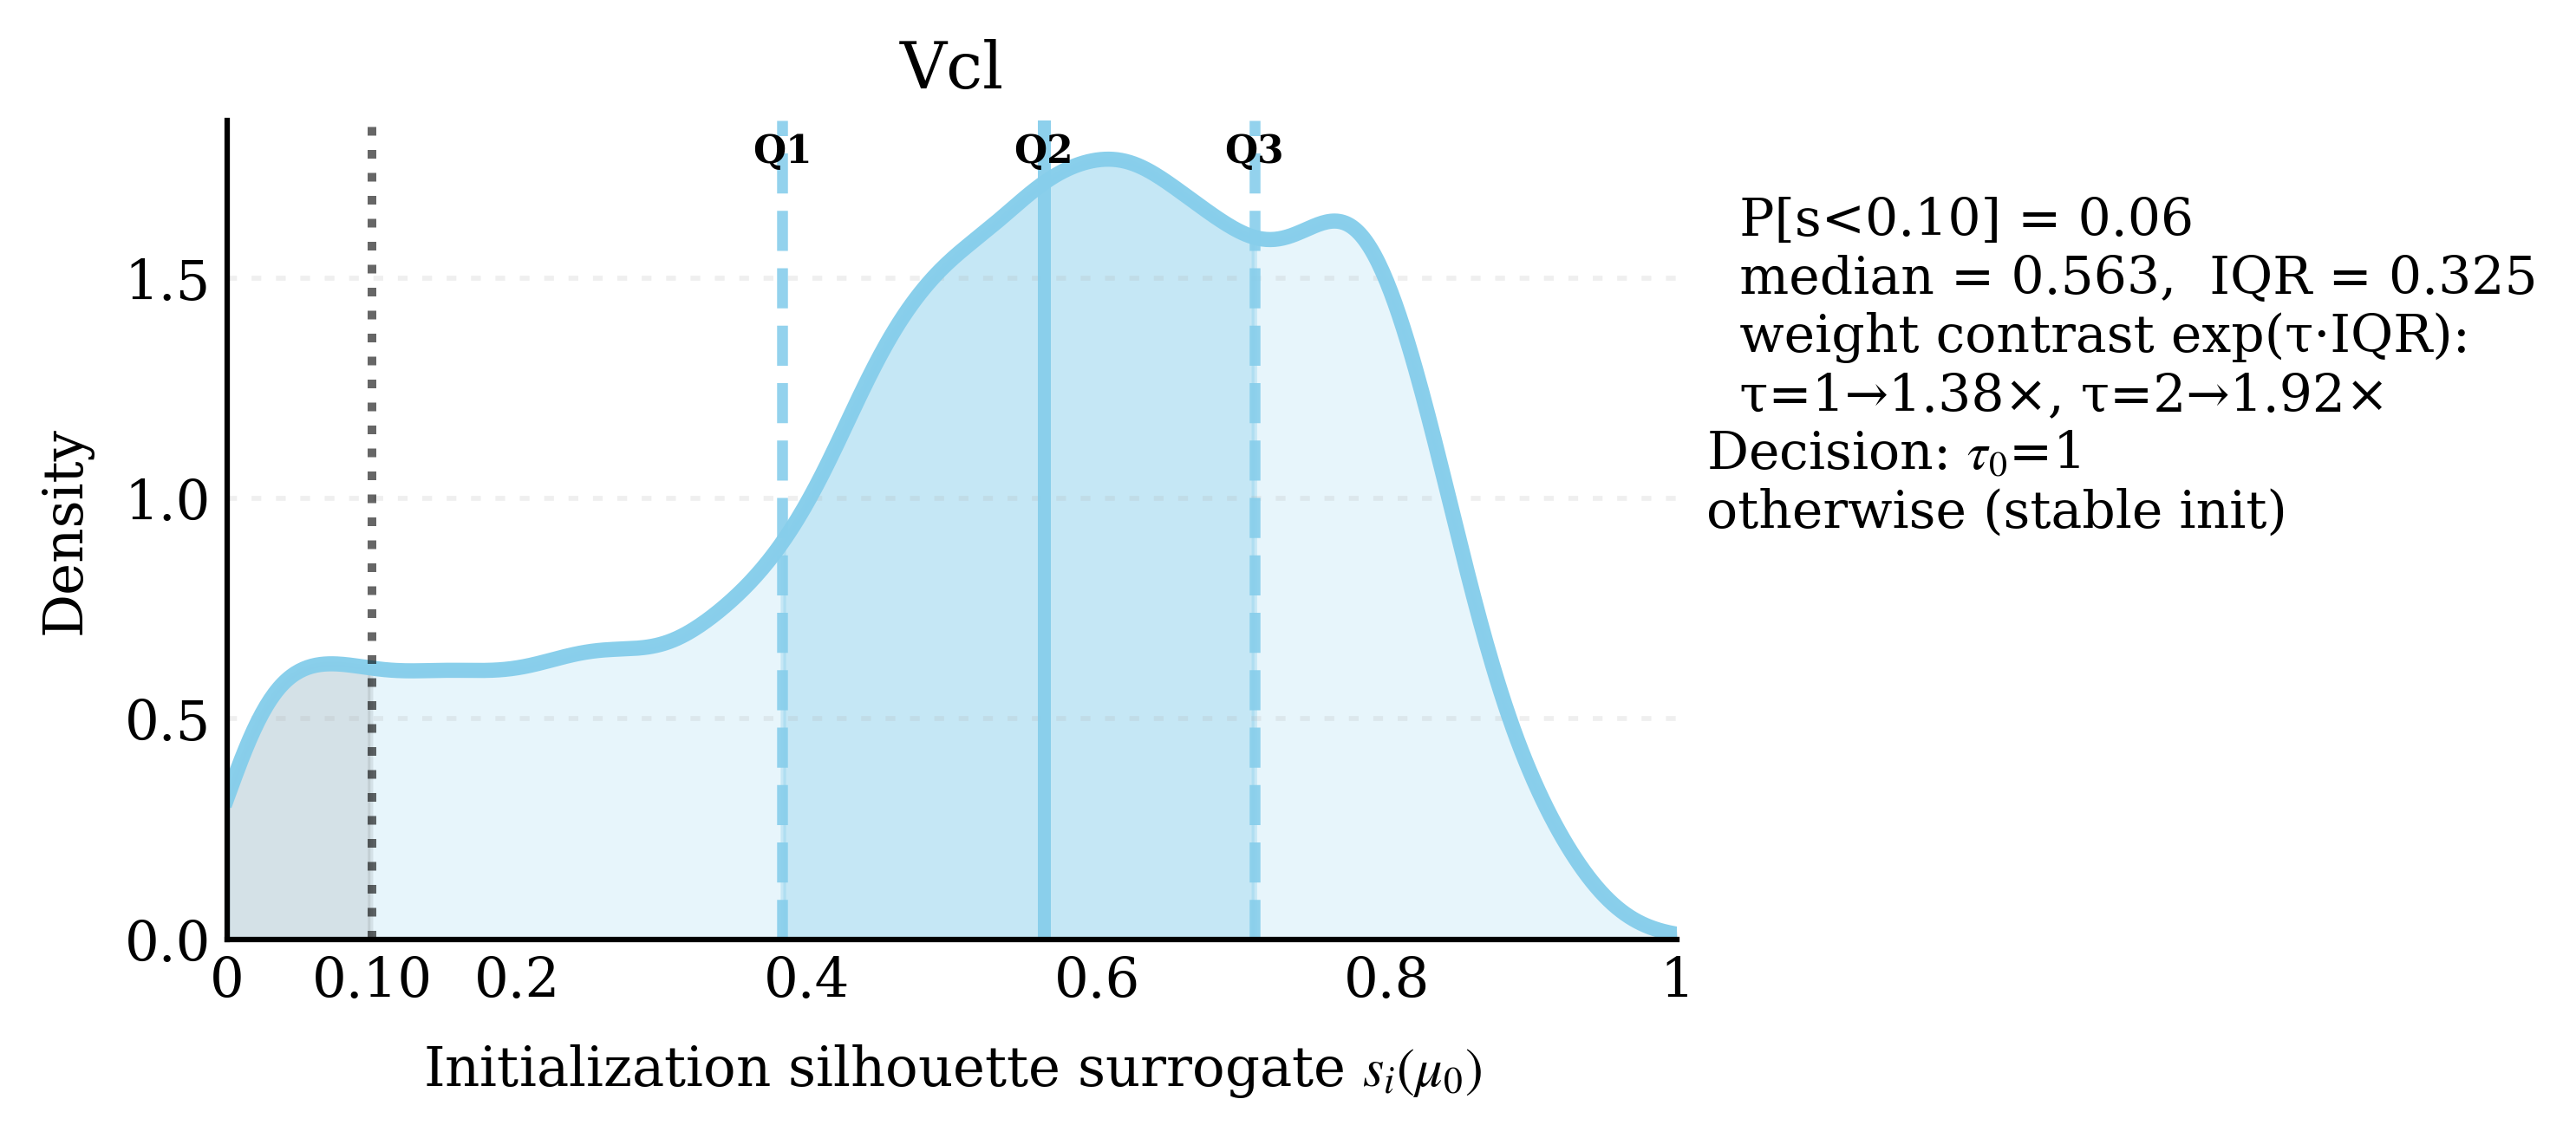

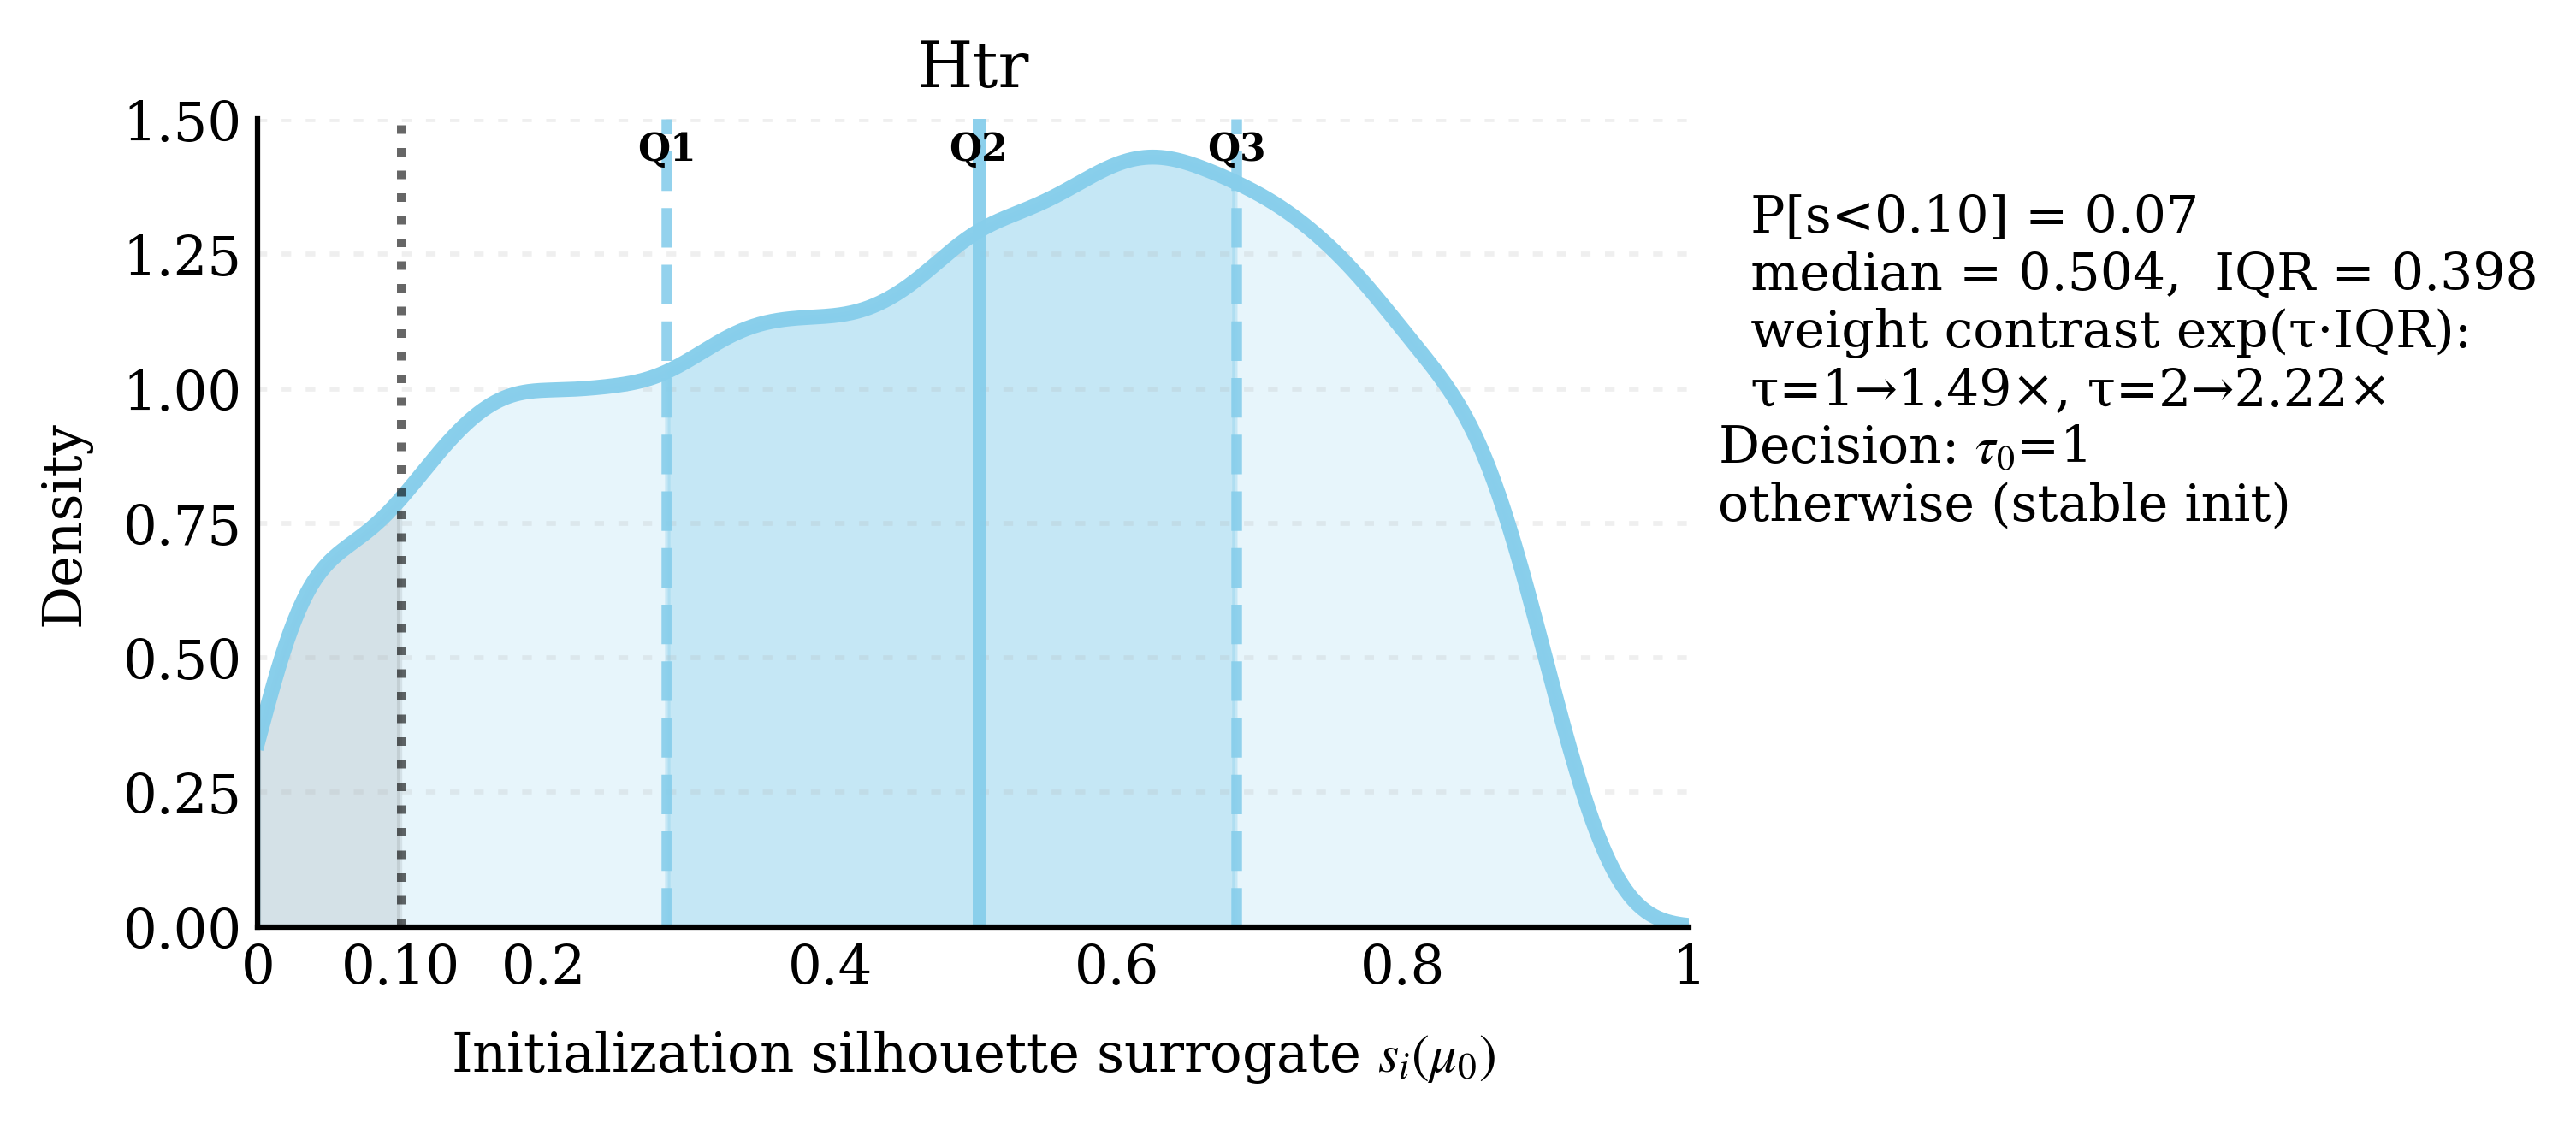

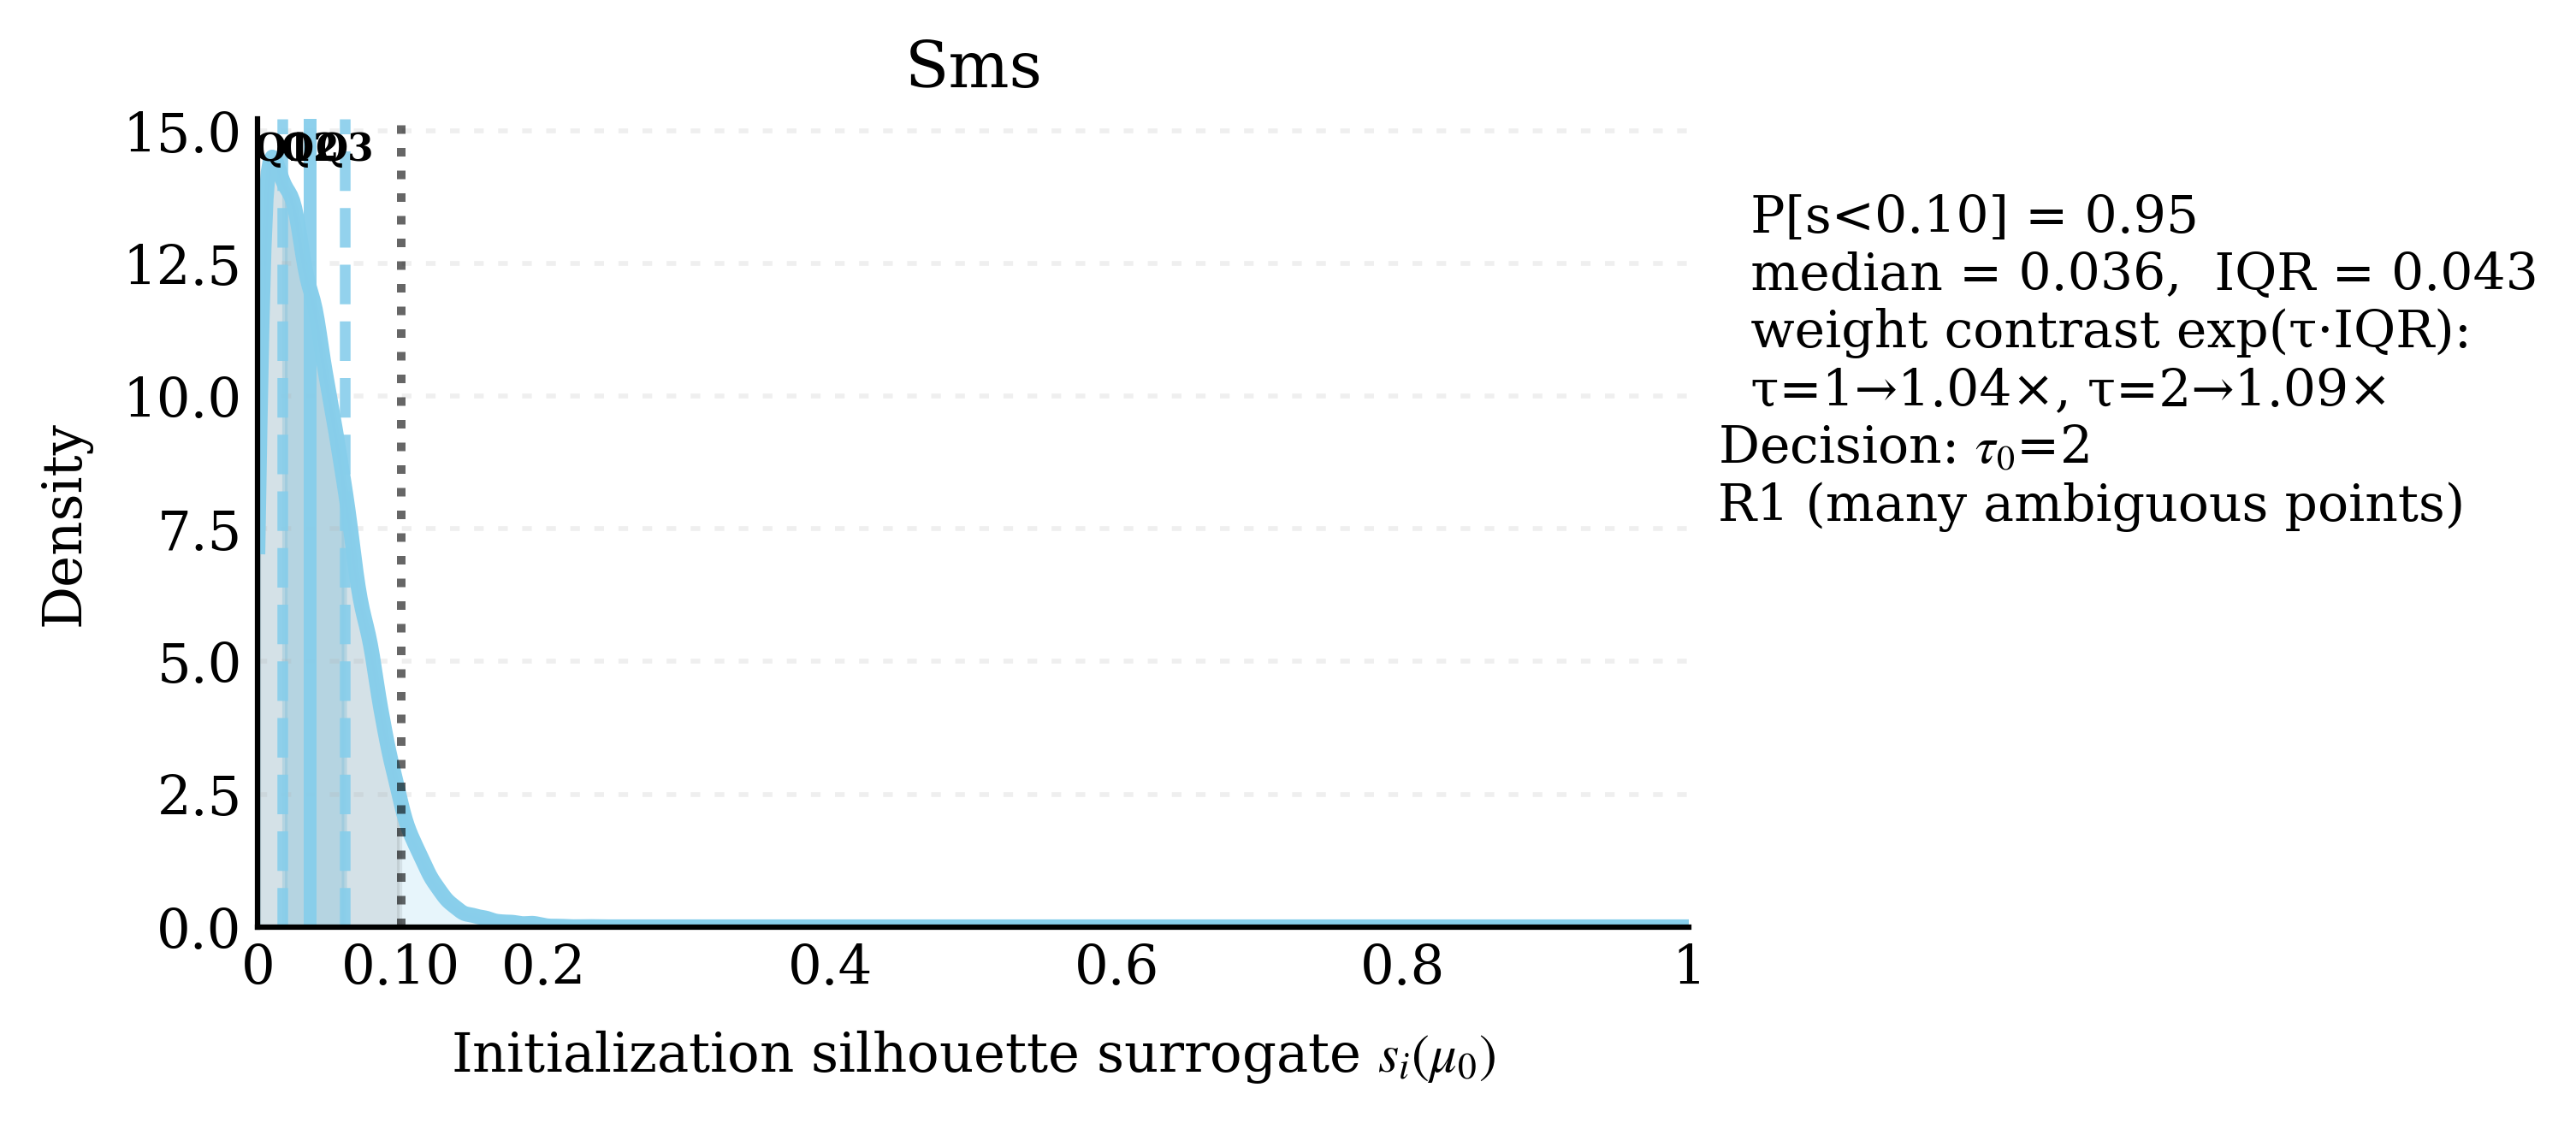

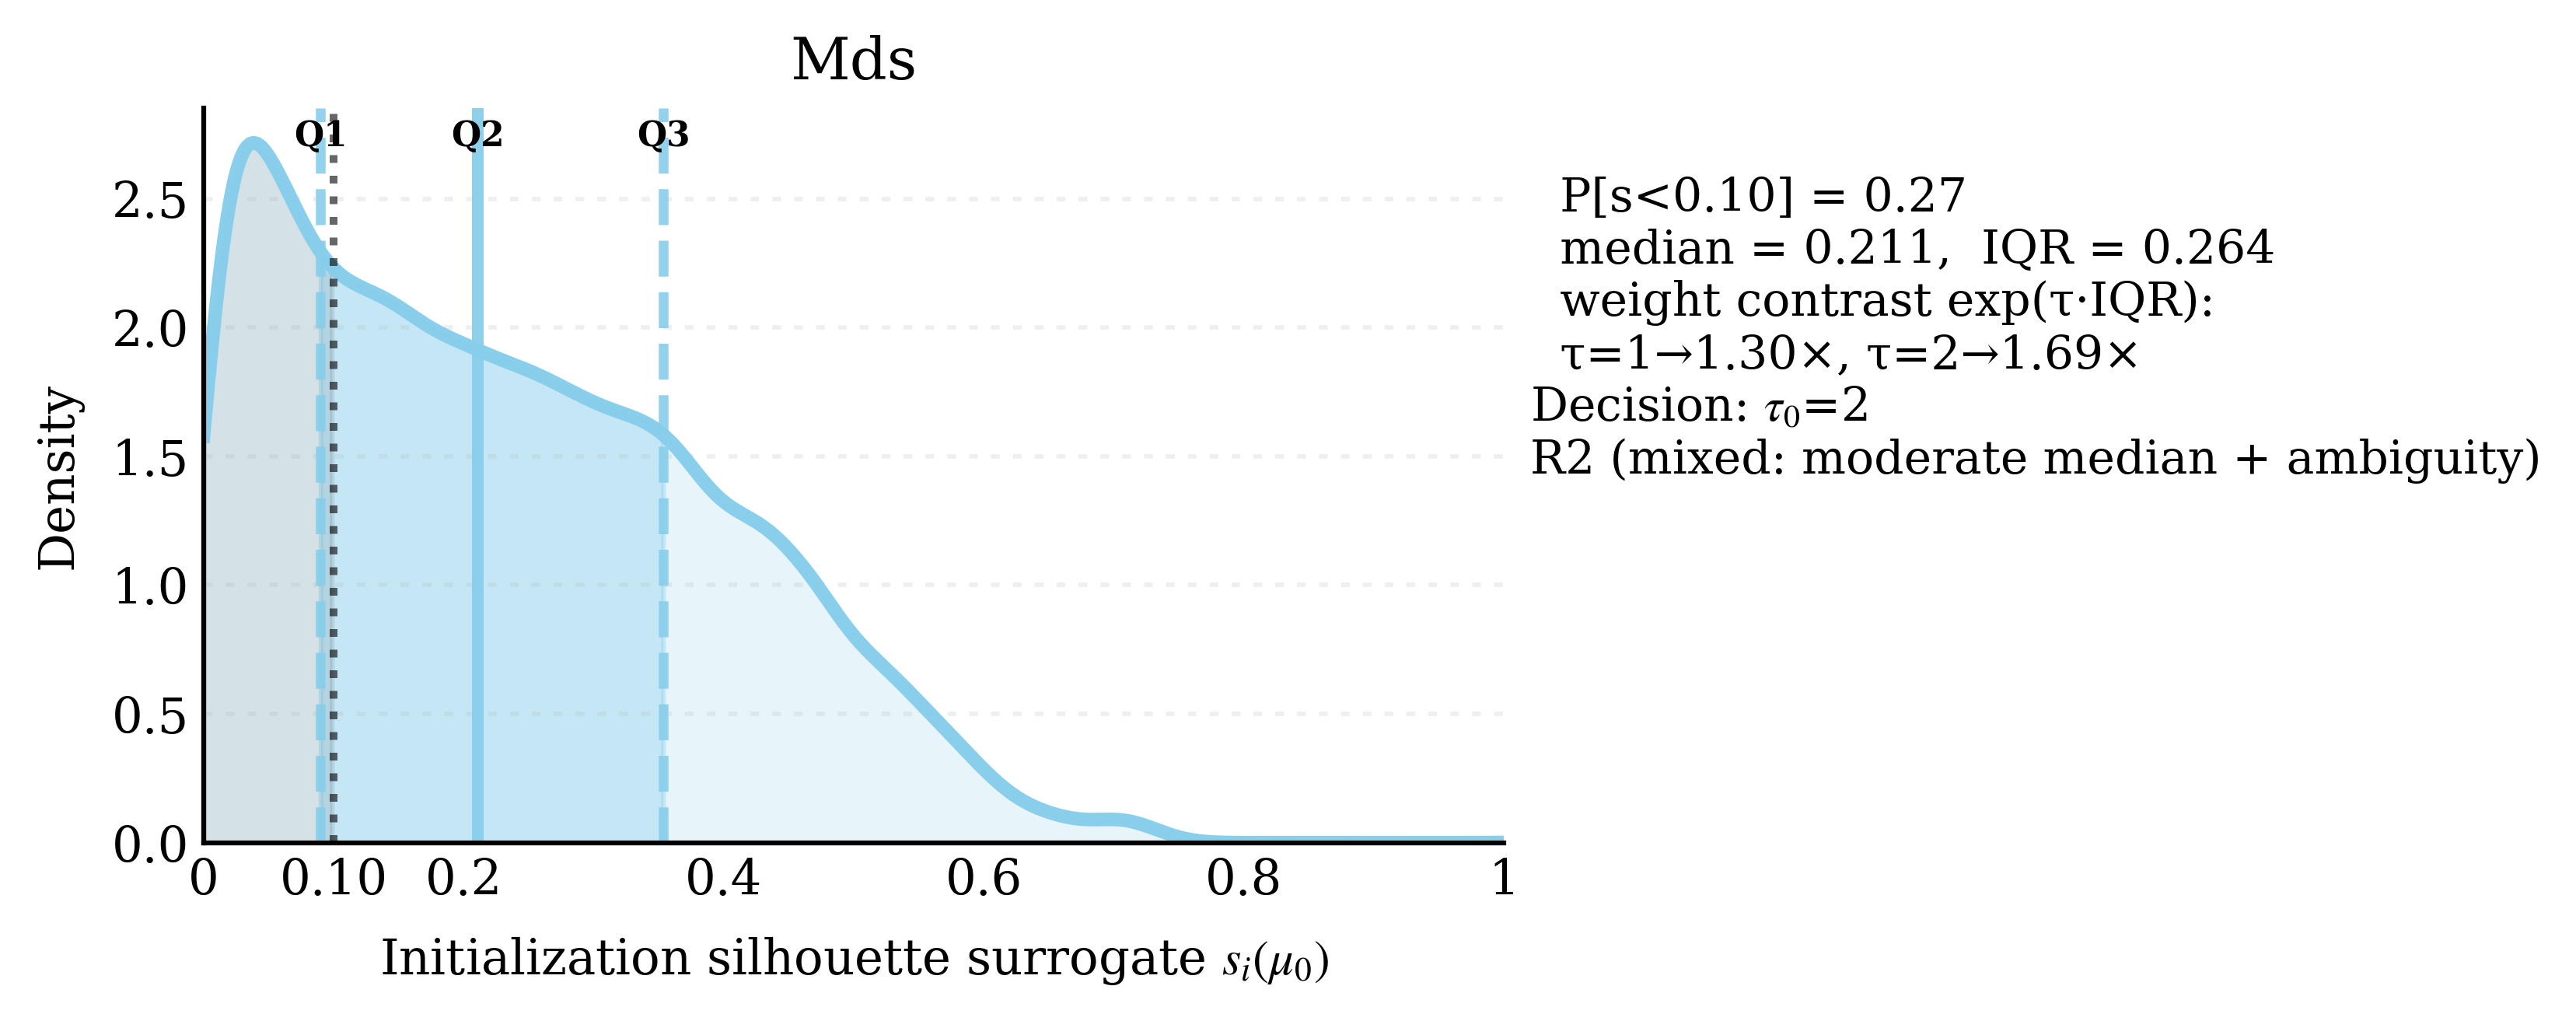

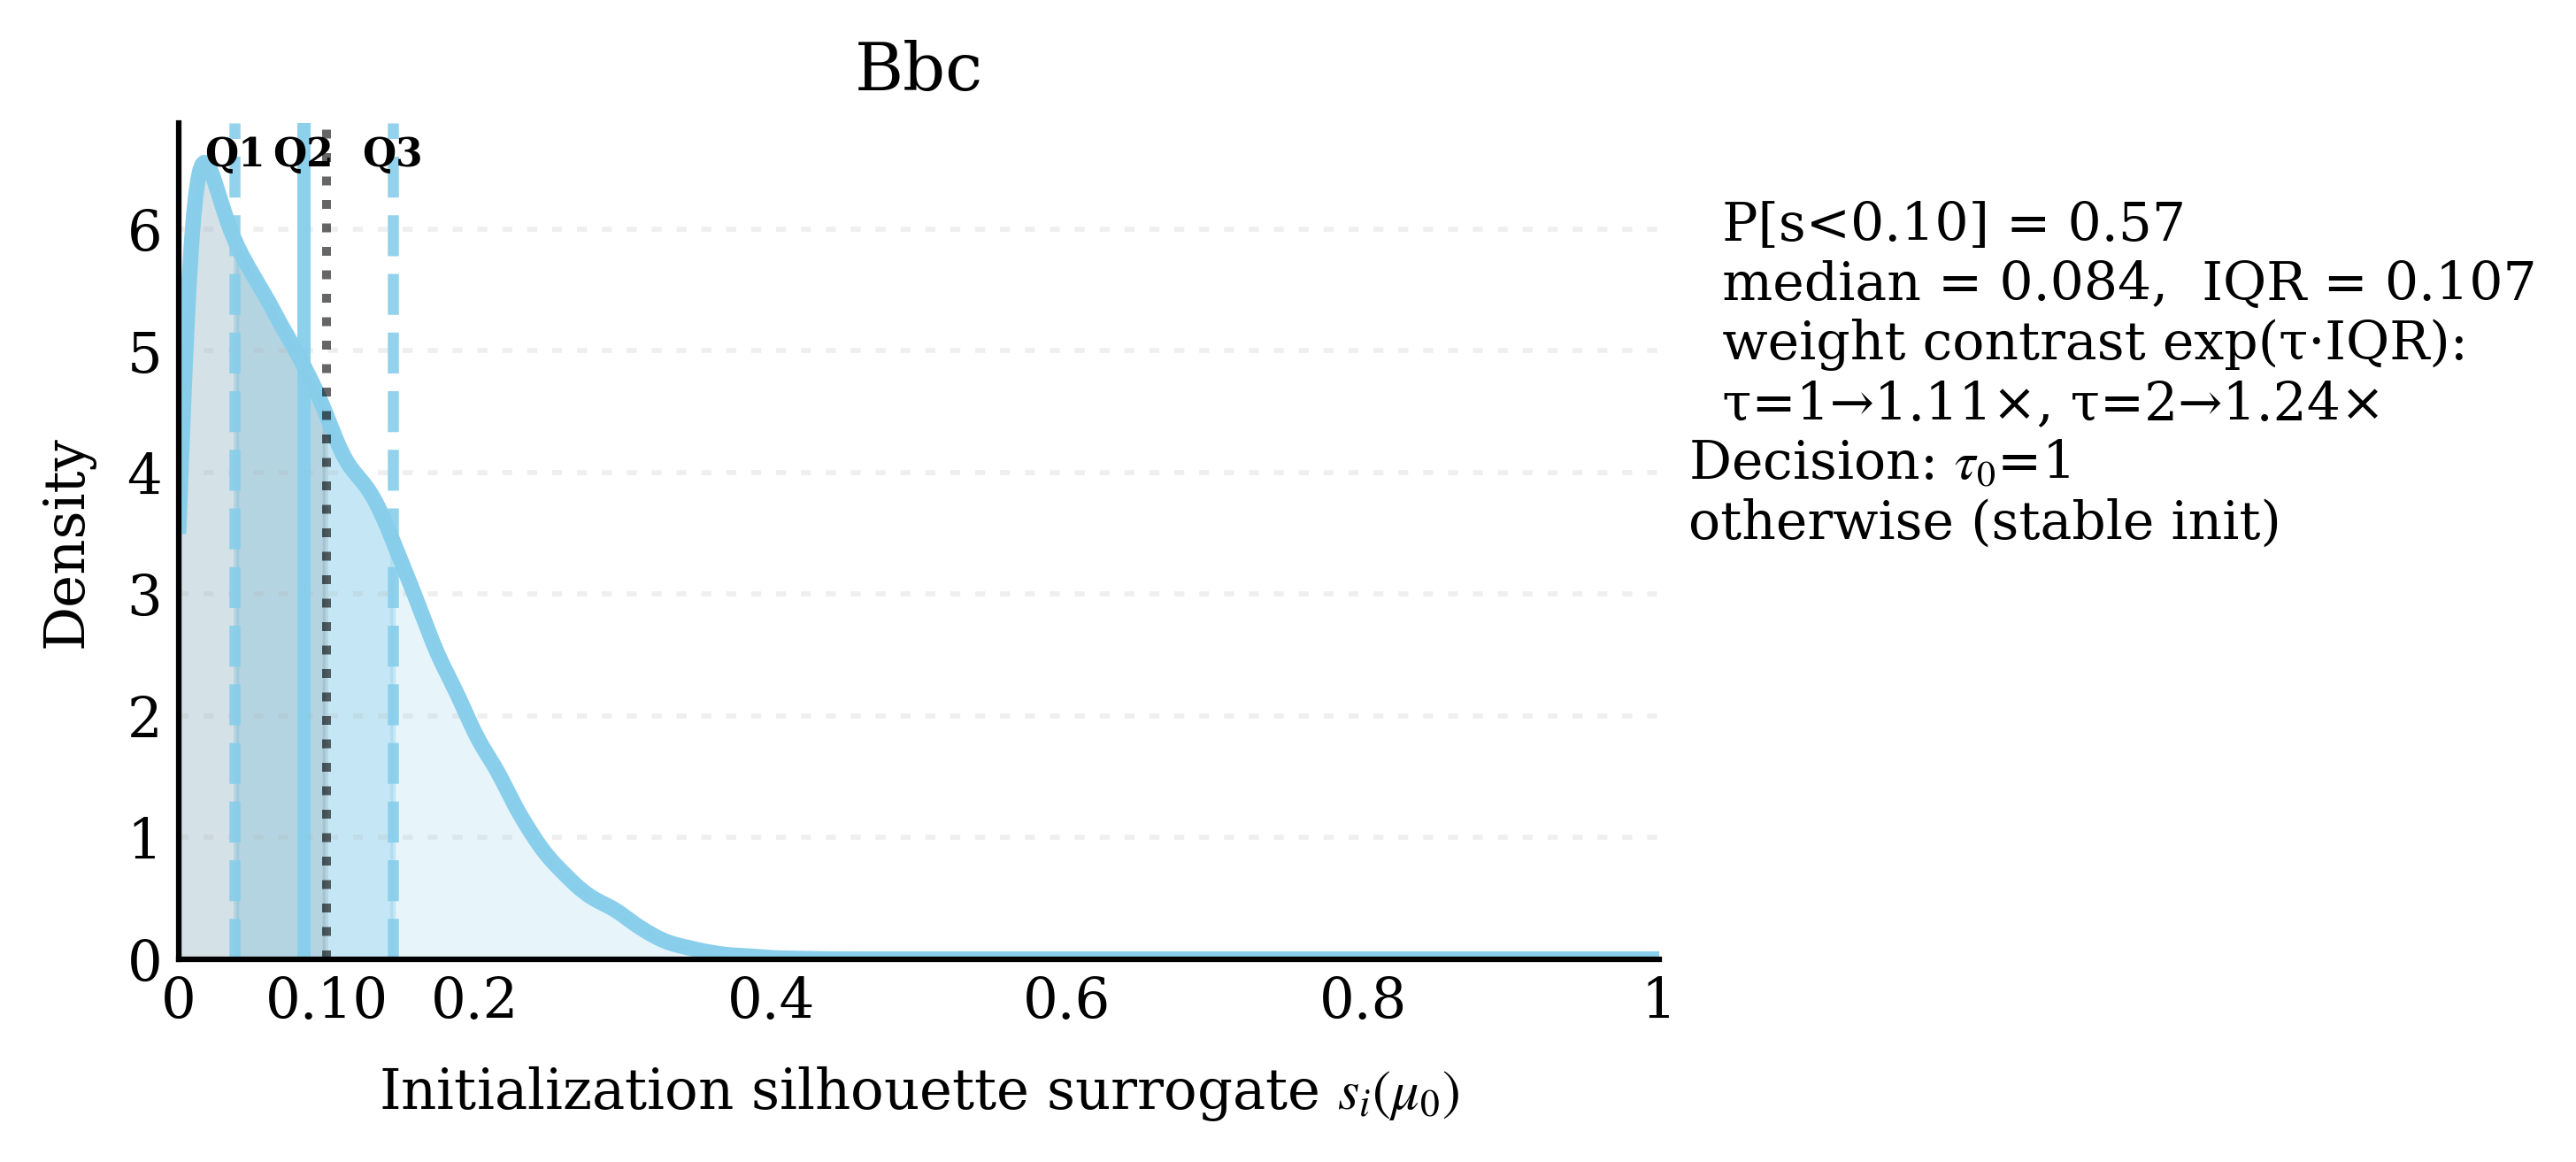

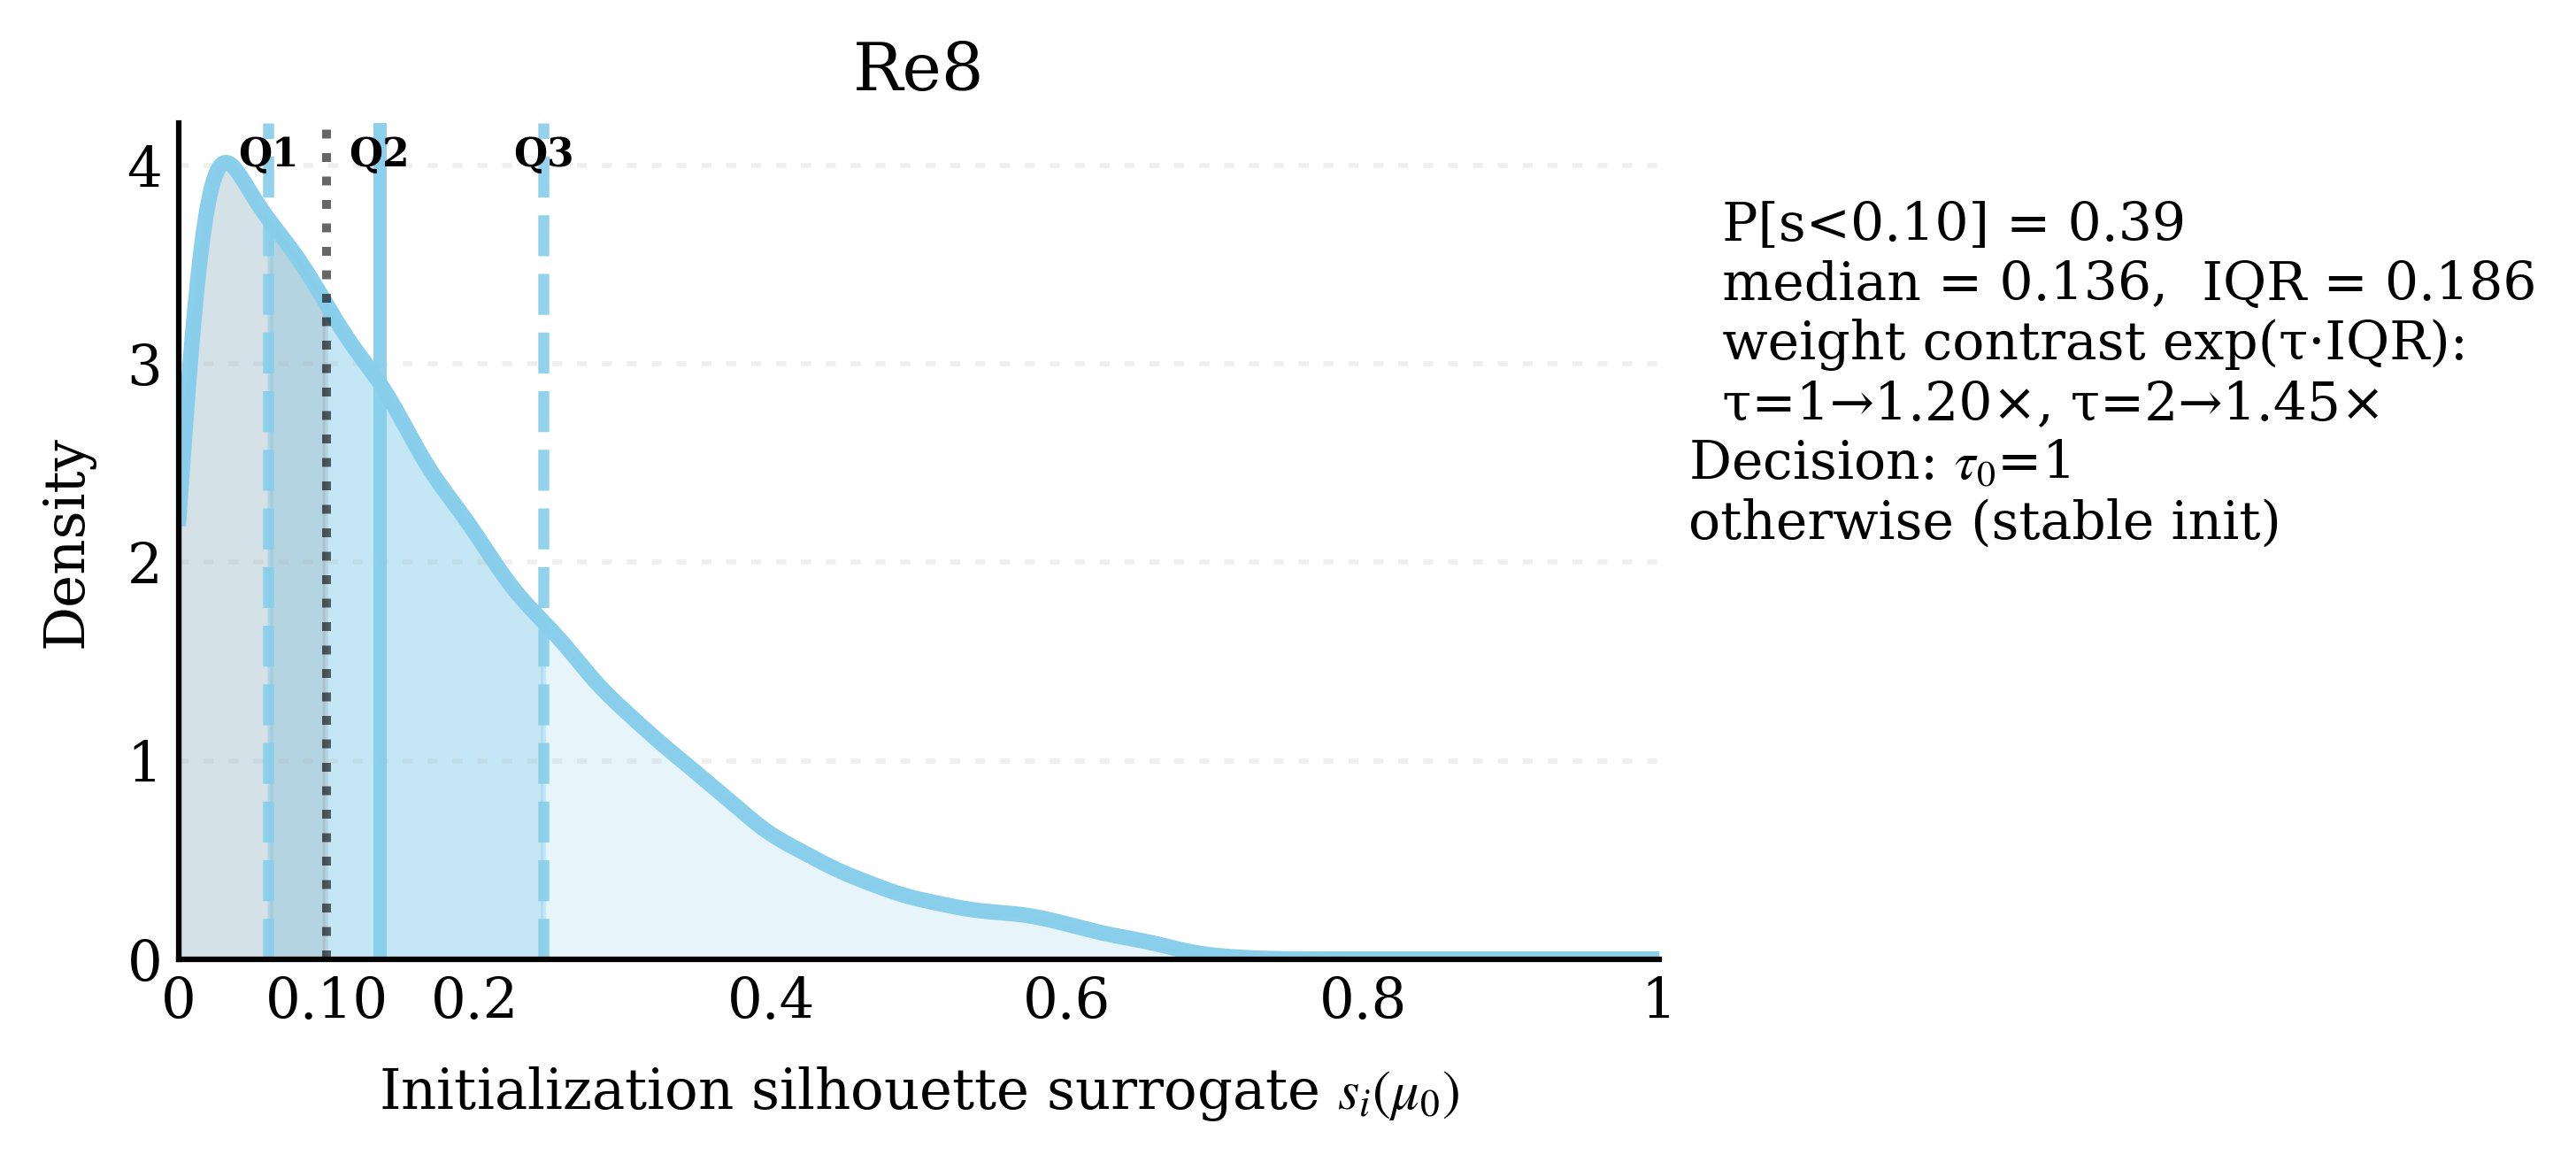

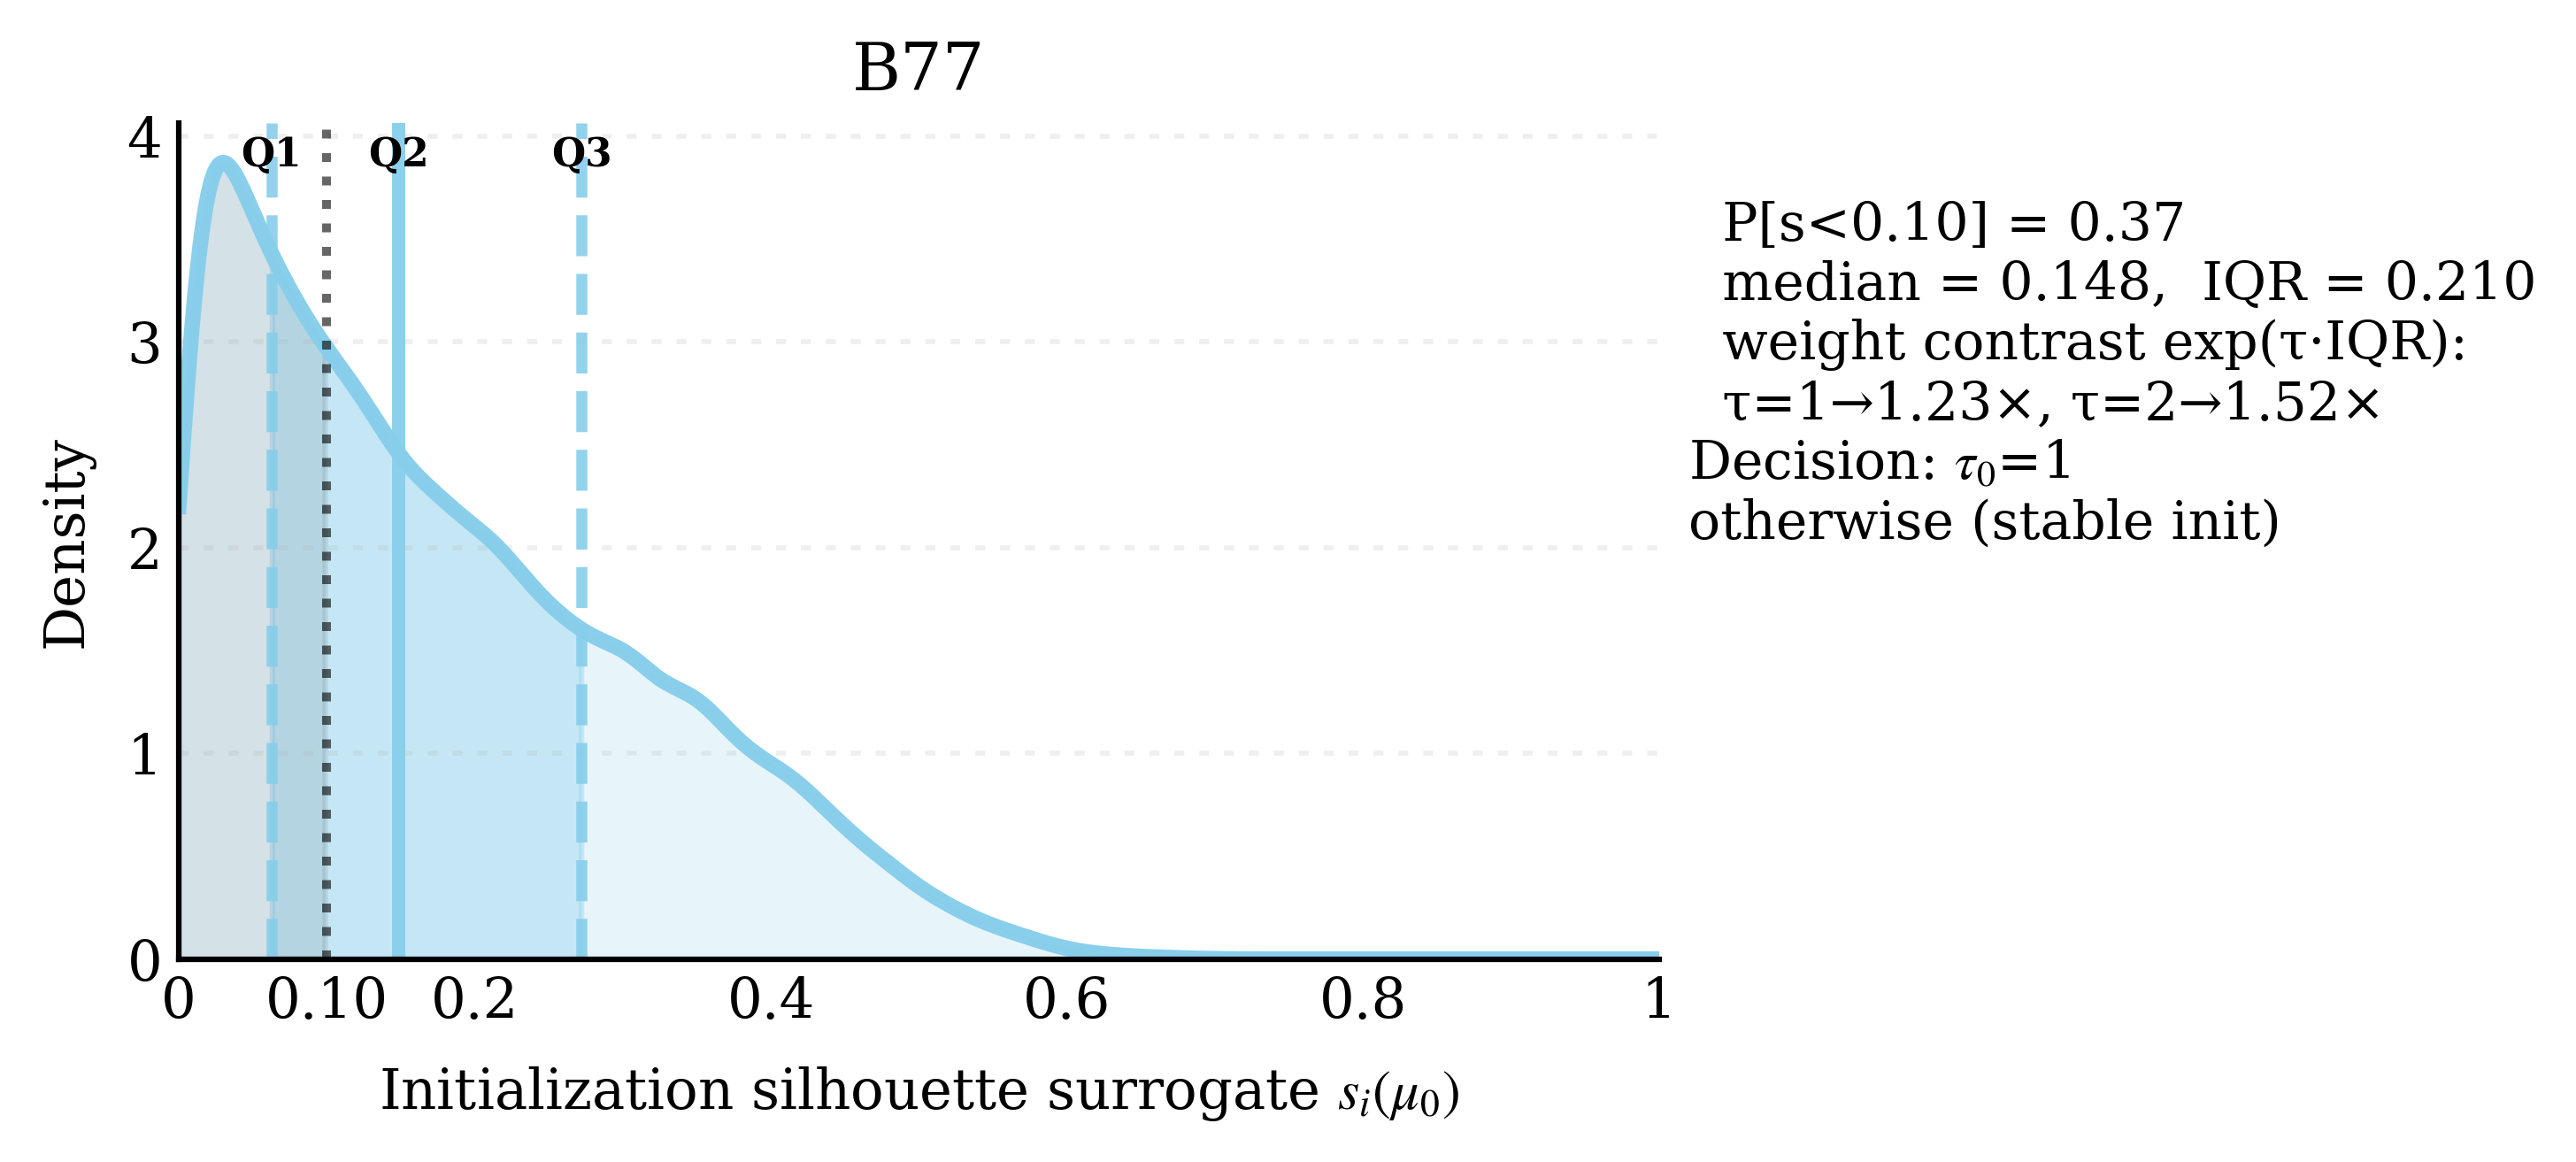

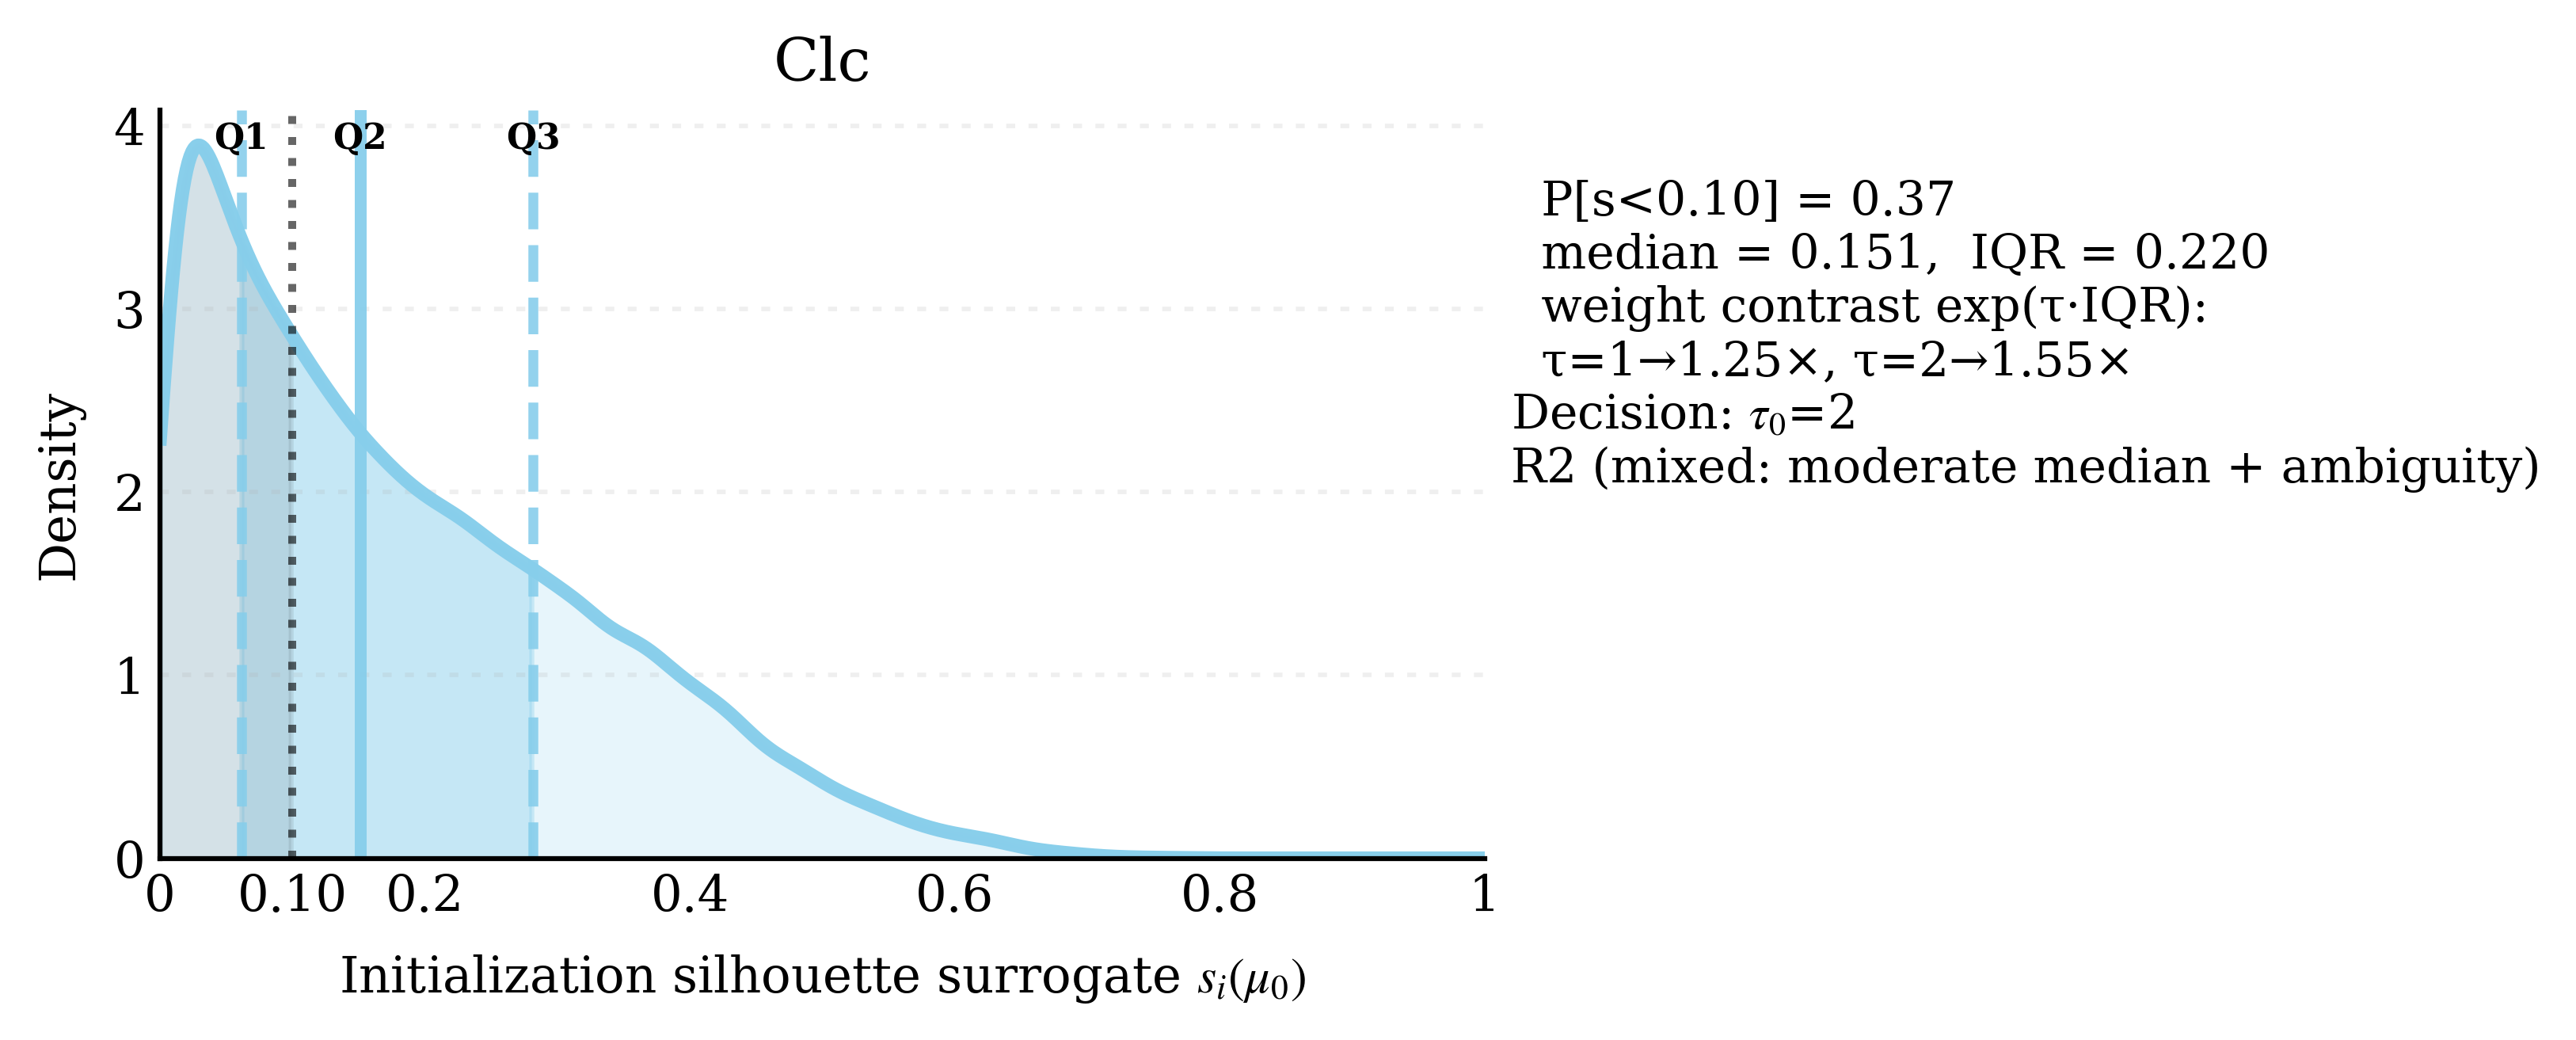

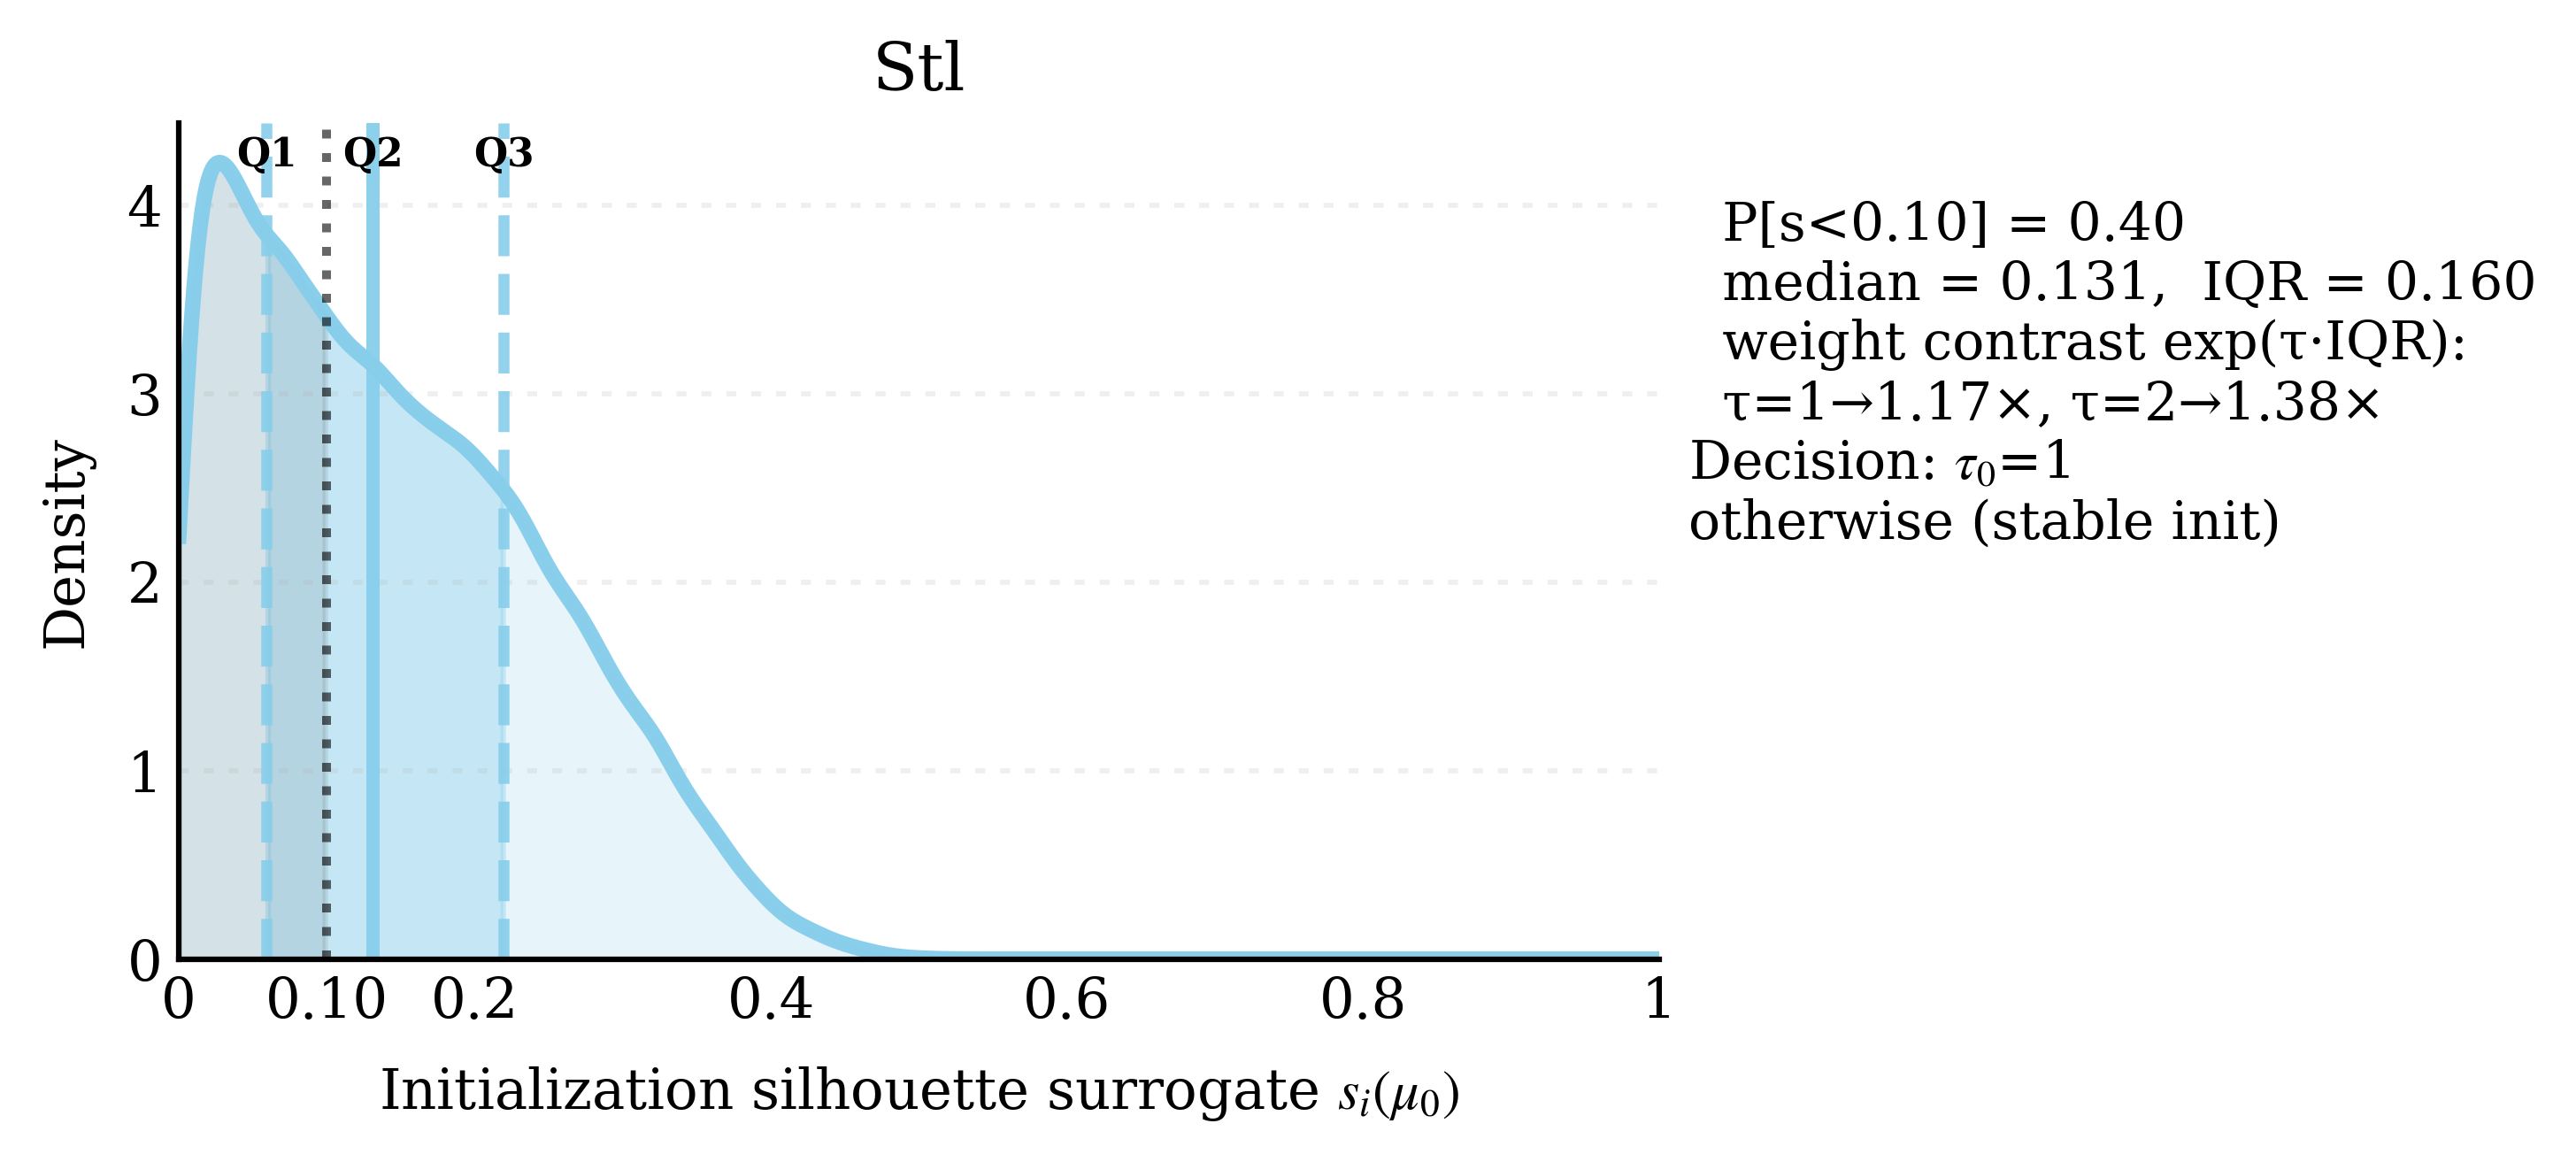


--- Init silhouette diagnostics (pooled over seeds) ---
   Sms | med=0.036  IQR=0.043  p[s<0.10]=0.95  Q3/Q1(w) tau1=1.04x  tau2=1.09x  => tau0=2  (R1 (many ambiguous points))
   Clc | med=0.151  IQR=0.220  p[s<0.10]=0.37  Q3/Q1(w) tau1=1.25x  tau2=1.55x  => tau0=2  (R2 (mixed: moderate median + ambiguity))
   Mds | med=0.211  IQR=0.264  p[s<0.10]=0.27  Q3/Q1(w) tau1=1.30x  tau2=1.69x  => tau0=2  (R2 (mixed: moderate median + ambiguity))
   Lkm | med=0.182  IQR=0.161  p[s<0.10]=0.23  Q3/Q1(w) tau1=1.17x  tau2=1.38x  => tau0=2  (R2 (mixed: moderate median + ambiguity))
   Dbt | med=0.270  IQR=0.262  p[s<0.10]=0.17  Q3/Q1(w) tau1=1.30x  tau2=1.69x  => tau0=2  (R3 (heterogeneous confidence))
   Wne | med=0.325  IQR=0.291  p[s<0.10]=0.14  Q3/Q1(w) tau1=1.34x  tau2=1.79x  => tau0=2  (R3 (heterogeneous confidence))
   BrC | med=0.404  IQR=0.325  p[s<0.10]=0.10  Q3/Q1(w) tau1=1.38x  tau2=1.92x  => tau0=2  (R3 (heterogeneous confidence))
   MiP | med=0.490  IQR=0.370  p[s<0.10]=0.07  Q3/Q1(w)

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as mtransforms
from scipy.stats import gaussian_kde


def init_sil_scores(X, k, seed, init="random"):
    X = np.asarray(X, dtype=float)
    m = KSil(
        n_clusters=int(k),
        init=init,
        max_iter=1,
        random_state=int(seed),
        learning_rate=0.2,
        tol=1e-4,
        n_init=1,
        n_jobs=1,
    )
    centers, labels = m._initialization(X, int(k))
    s, _, _ = KSil.sil_scores(X, labels, centers)
    s = np.asarray(s, dtype=float)
    s = s[np.isfinite(s)]
    return np.clip(s, 0.0, 1.0)


def pooled_init_stats(X, k, seeds=range(50), init="random", max_points=50000, low_thr=0.10, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    s = []
    for sd in seeds:
        s.append(init_sil_scores(X, k, seed=sd, init=init))
    s = np.concatenate(s, axis=0)

    if s.size > max_points:
        idx = rng.choice(s.size, size=max_points, replace=False)
        s = s[idx]

    q1, med, q3 = np.quantile(s, [0.25, 0.50, 0.75])
    iqr = float(q3 - q1)
    p_low = float(np.mean(s < float(low_thr)))

    return {
        "q1": float(q1),
        "med": float(med),
        "q3": float(q3),
        "iqr": float(iqr),
        "p_low": float(p_low),
        "low_thr": float(low_thr),
        "w_spread_tau1": float(np.exp(1.0 * iqr)),
        "w_spread_tau2": float(np.exp(2.0 * iqr)),
        "s": s,
    }


def choose_tau0(stats, low_thr=0.10):
    m = float(stats["med"])
    i = float(stats["iqr"])
    p = float(stats["p_low"])

    r1 = (p >= 0.90)
    r2 = ((0.15 <= m <= 0.25) and (p >= 0.20))
    r3 = ((i >= 0.25) and (m <= 0.50))

    if r1:
        return 2, "R1 (many ambiguous points)"
    if r2:
        return 2, "R2 (mixed: moderate median + ambiguity)"
    if r3:
        return 2, "R3 (heterogeneous confidence)"
    return 1, "otherwise (stable init)"


def plot_init_kde_tau0(
    X,
    k,
    ds_name="dataset",
    seeds=range(50),
    init="random",
    max_points=50000,
    color="skyblue",
    low_thr=0.10,
    outpath=None,
    dpi=450,
    show_rule=False,
):
    stats = pooled_init_stats(X, k, seeds=seeds, init=init, max_points=max_points, low_thr=low_thr)
    s = stats["s"]
    q1, med, q3, iqr = stats["q1"], stats["med"], stats["q3"], stats["iqr"]
    p_low = stats["p_low"]
    tau0, rule_hit = choose_tau0(stats, low_thr=low_thr)

    rc = {
        "figure.dpi": dpi,
        "savefig.dpi": dpi,
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "STIXGeneral", "DejaVu Serif"],
        "mathtext.fontset": "stix",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.linewidth": 1.0,
    }

    with mpl.rc_context(rc):
        fig, ax = plt.subplots(figsize=(6.3, 3.0), dpi=dpi)
        fig.subplots_adjust(left=0.10, right=0.69, bottom=0.18, top=0.88)

        grid = np.linspace(0.0, 1.0, 700)
        dens = gaussian_kde(s)(grid) if s.size >= 10 else np.zeros_like(grid)

        ax.margins(y=0)
        ax.set_ylim(0, float(dens.max()) * 1.05 if dens.size else 1.0)

        ax.plot(grid, dens, color=color, linewidth=2.8, alpha=0.98)
        ax.fill_between(grid, dens, 0.0, color=color, alpha=0.20)

        mask_iqr = (grid >= q1) & (grid <= q3)
        ax.fill_between(grid[mask_iqr], dens[mask_iqr], 0.0, color=color, alpha=0.35)

        mask_low = (grid >= 0.0) & (grid <= float(low_thr))
        ax.fill_between(grid[mask_low], dens[mask_low], 0.0, color="black", alpha=0.08)

        ax.axvline(low_thr, color="black", linewidth=1.6, alpha=0.60, linestyle=":")
        ax.axvline(q1,  color=color, linewidth=2.0, alpha=0.90, linestyle="--")
        ax.axvline(med, color=color, linewidth=2.4, alpha=0.95, linestyle="-")
        ax.axvline(q3,  color=color, linewidth=2.0, alpha=0.90, linestyle="--")

        t = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        for x, lab in [(q1, "Q1"), (med, "Q2"), (q3, "Q3")]:
            ax.text(
                x, 0.985, lab,
                transform=t,
                ha="center", va="top",
                fontsize=7, fontweight="bold",
                clip_on=False,
            )

        xt = [0.0, float(low_thr), 0.2, 0.4, 0.6, 0.8, 1.0]
        xt = sorted(set([round(v, 2) for v in xt if 0.0 <= v <= 1.0]))
        ax.set_xticks(xt)
        ax.set_xticklabels([f"{v:.2f}" if abs(v-low_thr) < 1e-12 else f"{v:g}" for v in xt])

        rule_txt = (
            "Rule (global, fixed): choose $\\tau_0$=2 if\n"
            f"  R1: P[s<{low_thr:.2f}] ≥ 0.90,  or\n"
            f"  R2: median∈[0.15,0.25] AND P[s<{low_thr:.2f}] ≥ 0.20,  or\n"
            "  R3: IQR ≥ 0.25 AND median ≤ 0.50.\n\n"
        ) if show_rule else ""

        dataset_txt = (
            "\n"
            f"  P[s<{low_thr:.2f}] = {p_low:.2f}\n"
            f"  median = {med:.3f},  IQR = {iqr:.3f}\n"
            f"  weight contrast exp(τ·IQR):\n"
            f"  τ=1→{stats['w_spread_tau1']:.2f}×, τ=2→{stats['w_spread_tau2']:.2f}×\n"
            f"Decision: $\\tau_0$={tau0}  \n{rule_hit}"
        )

        ax.text(
            1.02, 0.98, rule_txt + dataset_txt,
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=9.6,
            clip_on=False,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.93, boxstyle="round,pad=0.30"),
        )

        ax.set_title(ds_name, pad=6)
        ax.set_xlabel(r"Initialization silhouette surrogate $s_i(\mu_0)$", labelpad=6)
        ax.set_ylabel("Density", labelpad=6)
        ax.set_xlim(0.0, 1.0)

        ax.grid(True, axis="y", linestyle=(0, (2, 3)), alpha=0.20, linewidth=0.9)
        ax.grid(False, axis="x")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="both", length=0, pad=3)

        if outpath is not None:
            d = os.path.dirname(outpath)
            if d:
                os.makedirs(d, exist_ok=True)
            fig.savefig(outpath, bbox_inches="tight")

    out = dict(stats)
    out.pop("s", None)
    out["tau0"] = int(tau0)
    out["rule_hit"] = rule_hit
    return fig, out

seeds = range(50)
stats_by_ds = {}

for i, (ds_name, X, k) in enumerate(zip(name_list, X_list, k_list)):
    fig, st = plot_init_kde_tau0(
        X=X,
        k=k,
        ds_name=ds_name,
        seeds=seeds,
        init="random",
        max_points=50000,
        color="skyblue",
        low_thr=0.10,
        dpi=450,
        outpath=None,
        show_rule=(i == 0),
    )
    stats_by_ds[ds_name] = st

plt.show()

print("\n--- Init silhouette diagnostics (pooled over seeds) ---")
for ds_name in sorted(stats_by_ds, key=lambda n: (stats_by_ds[n]["tau0"], stats_by_ds[n]["p_low"], stats_by_ds[n]["iqr"]), reverse=True):
    st = stats_by_ds[ds_name]
    print(
        f"{ds_name:>6s} | "
        f"med={st['med']:.3f}  IQR={st['iqr']:.3f}  "
        f"p[s<{st['low_thr']:.2f}]={st['p_low']:.2f}  "
        f"Q3/Q1(w) tau1={st['w_spread_tau1']:.2f}x  tau2={st['w_spread_tau2']:.2f}x  "
        f"=> tau0={st['tau0']}  ({st['rule_hit']})"
    )